In [1]:
import pandas as pd
import torch
from torch.nn import Linear
import torch.nn.functional as F
import numpy as np
import torch_geometric
from torch_geometric.data import Data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from torch_geometric.nn.norm import LayerNorm
from pathlib import Path
import seaborn as sns

In [2]:
folder_path = r"C:\Users\msi\Desktop\workspace\042_materials_GNN\Data Sets for ML\Data Sets for ML"
folder = Path(folder_path)

In [3]:
df = pd.DataFrame()
for idx, p in enumerate(folder.glob("*/*/*/MergedGrainsData*")):
    df_tmp = pd.read_excel(p, header=1)
        
    percent = int(p.parts[-2][:-1])
    tmp = p.parts[-3].split("_")
    temperature = int(tmp[0])
    speed = tmp[1]
    speed = 0 if speed == "LS" else 1
    direction = int(p.parts[-4][1:])

    df_tmp["percent"] = percent
    df_tmp["temperature"] = temperature
    df_tmp["speed"] = speed
    df_tmp["direction"] = direction
    df_tmp["set_num"] = idx
    
    if idx == 0:
        df = df_tmp
    else:
        df = pd.concat([df, df_tmp], axis=0, ignore_index=True)

In [4]:
df.columns

Index(['merged ID', 'original grain id', 'phi1', 'phi', 'phi2',
       'merged grain area', 'parent Area', 'daughter Area', 'other area',
       'no. of parent grains', 'no. of daughter grains',
       'daughter grains percent', 'other daughters', 'other daughters area',
       'major axis', 'aspect ratio', 'total boundary length',
       'border boundary length', 'internal boundary length', 'GOS', 'GAM',
       'Schmid SF1', 'Schmid SF2', 'Schmid SF3', 'Schmid SF4', 'Schmid SF5',
       'Schmid SF6', 'Taylor TF1', 'Taylor TF2', 'Taylor TF3', 'Taylor TF4',
       'Taylor TF5', 'Taylor TF6', 'Twin Count for Var1',
       'Twin Count for Var2', 'Twin Count for Var3', 'Twin Count for Var4',
       'Twin Count for Var5', 'Twin Count for Var6', 'Area Twinned for Var1',
       'Area Twinned for Var2', 'Area Twinned for Var3',
       'Area Twinned for Var4', 'Area Twinned for Var5',
       'Area Twinned for Var6', 'Schmid for Var1', 'Schmid for Var2',
       'Schmid for Var3', 'Schmid for Var

In [5]:
y = (df["daughter grains percent"] > 0).astype(int).to_numpy()

In [6]:
sum(y)

np.int64(2678)

In [7]:
ID_COL = 'merged ID'
FEATURE_COLS = [
    'phi1',
    'phi',
    'phi2',
    'merged grain area',
    'major axis',
    'aspect ratio',
    'total boundary length',
    'GOS',
    'GAM',
    'Schmid SF1',
    'Schmid SF2',
    'Schmid SF3',
    'Schmid SF4',
    'Schmid SF5',
    'Schmid SF6',
    'Taylor TF1',
    'Taylor TF2',
    'Taylor TF3',
    'Taylor TF4',
    'Taylor TF5',
    'Taylor TF6',
    'Schmid for Var1',
    'Schmid for Var2',
    'Schmid for Var3',
    'Schmid for Var4',
    'Schmid for Var5',
    'Schmid for Var6',
    'percent',
    'temperature',
    'speed',
    'direction'
]
FEATURE_COLS_ACHIEVED_AFTERWARDS = [
    'no. of parent grains',
    'parent Area',
    'daughter Area',
    'other area',
    'other daughters',
    'other daughters area'
]
EDGE_COL = 'neighbor grain ids'

VAGUE_COLS = [
    'major axis',
    'aspect ratio',
    'merged grain area',
    'total boundary length'
]
FEATURE_COLS_INSIDE = [c for c in FEATURE_COLS if c not in VAGUE_COLS]

In [8]:
df[FEATURE_COLS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19895 entries, 0 to 19894
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   phi1                   19895 non-null  float64
 1   phi                    19895 non-null  float64
 2   phi2                   19895 non-null  float64
 3   merged grain area      19895 non-null  int64  
 4   major axis             19895 non-null  float64
 5   aspect ratio           19895 non-null  float64
 6   total boundary length  19895 non-null  int64  
 7   GOS                    19895 non-null  float64
 8   GAM                    19895 non-null  float64
 9   Schmid SF1             19895 non-null  float64
 10  Schmid SF2             19895 non-null  float64
 11  Schmid SF3             19895 non-null  float64
 12  Schmid SF4             19895 non-null  float64
 13  Schmid SF5             19895 non-null  float64
 14  Schmid SF6             19895 non-null  float64
 15  Ta

In [9]:
df[FEATURE_COLS].describe()

phi1           phi          phi2  merged grain area  \
count  19895.000000  19895.000000  19895.000000        19895.00000   
mean      29.120824    288.245686     28.832517          325.75049   
std       26.438818    121.361371     28.352330          855.83364   
min        0.001707      0.001946      0.023277           10.00000   
25%       12.136830    314.666119     11.845387           35.00000   
50%       25.605384    339.737126     24.505183          103.00000   
75%       44.762547    351.808186     43.755890          287.00000   
max      359.975532    359.998335    359.990164        29114.00000   

         major axis  aspect ratio  total boundary length           GOS  \
count  19895.000000  19895.000000           19895.000000  19895.000000   
mean      21.244542      2.033940              87.887308      1.263270   
std       19.706067      1.074106             106.378735      1.206655   
min        3.685321      1.000000              14.000000      0.070525   
25%        9.122364      1.421137              34.000000      0.460354   
50%       15.581967      1.742125              58.000000      0.841719   
75%       26.094585      2.266633             100.000000      1.625085   
max      246.901174     20.813044            2365.000000     13.286989   

                GAM    Schmid SF1  ...  Schmid for Var1  Schmid for Var2  \
count  19895.000000  19895.000000  ...     19895.000000     19895.000000   
mean       0.866040      0.332478  ...         0.178527         0.178735   
std        0.514919      0.132308  ...         0.261146         0.261554   
min        0.129033      0.000084  ...        -0.499920        -0.499964   
25%        0.516037      0.238058  ...         0.012569         0.011854   
50%        0.745494      0.367902  ...         0.247278         0.247817   
75%        1.057264      0.444374  ...         0.396695         0.396278   
max        7.579747      0.499994  ...         0.499829         0.499907   

       Schmid for Var3  Schmid for Var4  Schmid for Var5  Schmid for Var6  \
count     19895.000000     19895.000000     19895.000000     19895.000000   
mean          0.169278         0.169258         0.120202         0.120015   
std           0.271687         0.271737         0.261997         0.261373   
min          -0.499985        -0.499807        -0.499997        -0.499496   
25%           0.000826         0.000927        -0.068930        -0.067074   
50%           0.243143         0.241900         0.147296         0.146205   
75%           0.397310         0.396644         0.352671         0.353367   
max           0.499923         0.499828         0.499997         0.499994   

            percent  temperature         speed     direction  
count  19895.000000  19895.00000  19895.000000  19895.000000  
mean       4.841066    238.18673      0.630259     55.673787  
std        1.993725    115.31642      0.482747     43.716888  
min        3.000000     25.00000      0.000000      0.000000  
25%        3.000000    175.00000      0.000000      0.000000  
50%        3.000000    225.00000      1.000000     90.000000  
75%        7.000000    325.00000      1.000000     90.000000  
max        7.000000    425.00000      1.000000     90.000000  

[8 rows x 31 columns]

### Data Analysis

#### 1. Correlation

In [10]:
# new df with the answer
df_with_y = pd.concat([df, pd.Series(y, name="twin_or_not")], axis=1)

# delete columns that cannot be calculated in correlation analysis
df_with_y = df_with_y._get_numeric_data()

df_with_y.head()

merged ID  original grain id       phi1         phi       phi2  \
0          1                  1  51.992588  340.060929   7.927710   
1          2                  2  48.614823  347.530536  19.772951   
2          3                  5  40.321865  353.327411  25.271908   
3          4                  7  44.155840  351.273455  10.917894   
4          5                 10  18.402519  309.171717  18.854361   

   merged grain area  parent Area  daughter Area  other area  \
0                 13           13              0           0   
1                 18           18              0           0   
2                 27           27              0           0   
3                 14           14              0           0   
4                 30           30              0           0   

   no. of parent grains  ...  Rank for Var4  Rank for Var5  Rank for Var6  \
0                     1  ...              4              6              5   
1                     1  ...              2              6              5   
2                     1  ...              5              6              4   
3                     1  ...              3              1              2   
4                     1  ...              2              5              6   

   neighbor grains count  percent  temperature  speed  direction  set_num  \
0                      2        3          125      0          0        0   
1                      3        3          125      0          0        0   
2                      3        3          125      0          0        0   
3                      2        3          125      0          0        0   
4                      2        3          125      0          0        0   

   twin_or_not  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 64 columns]

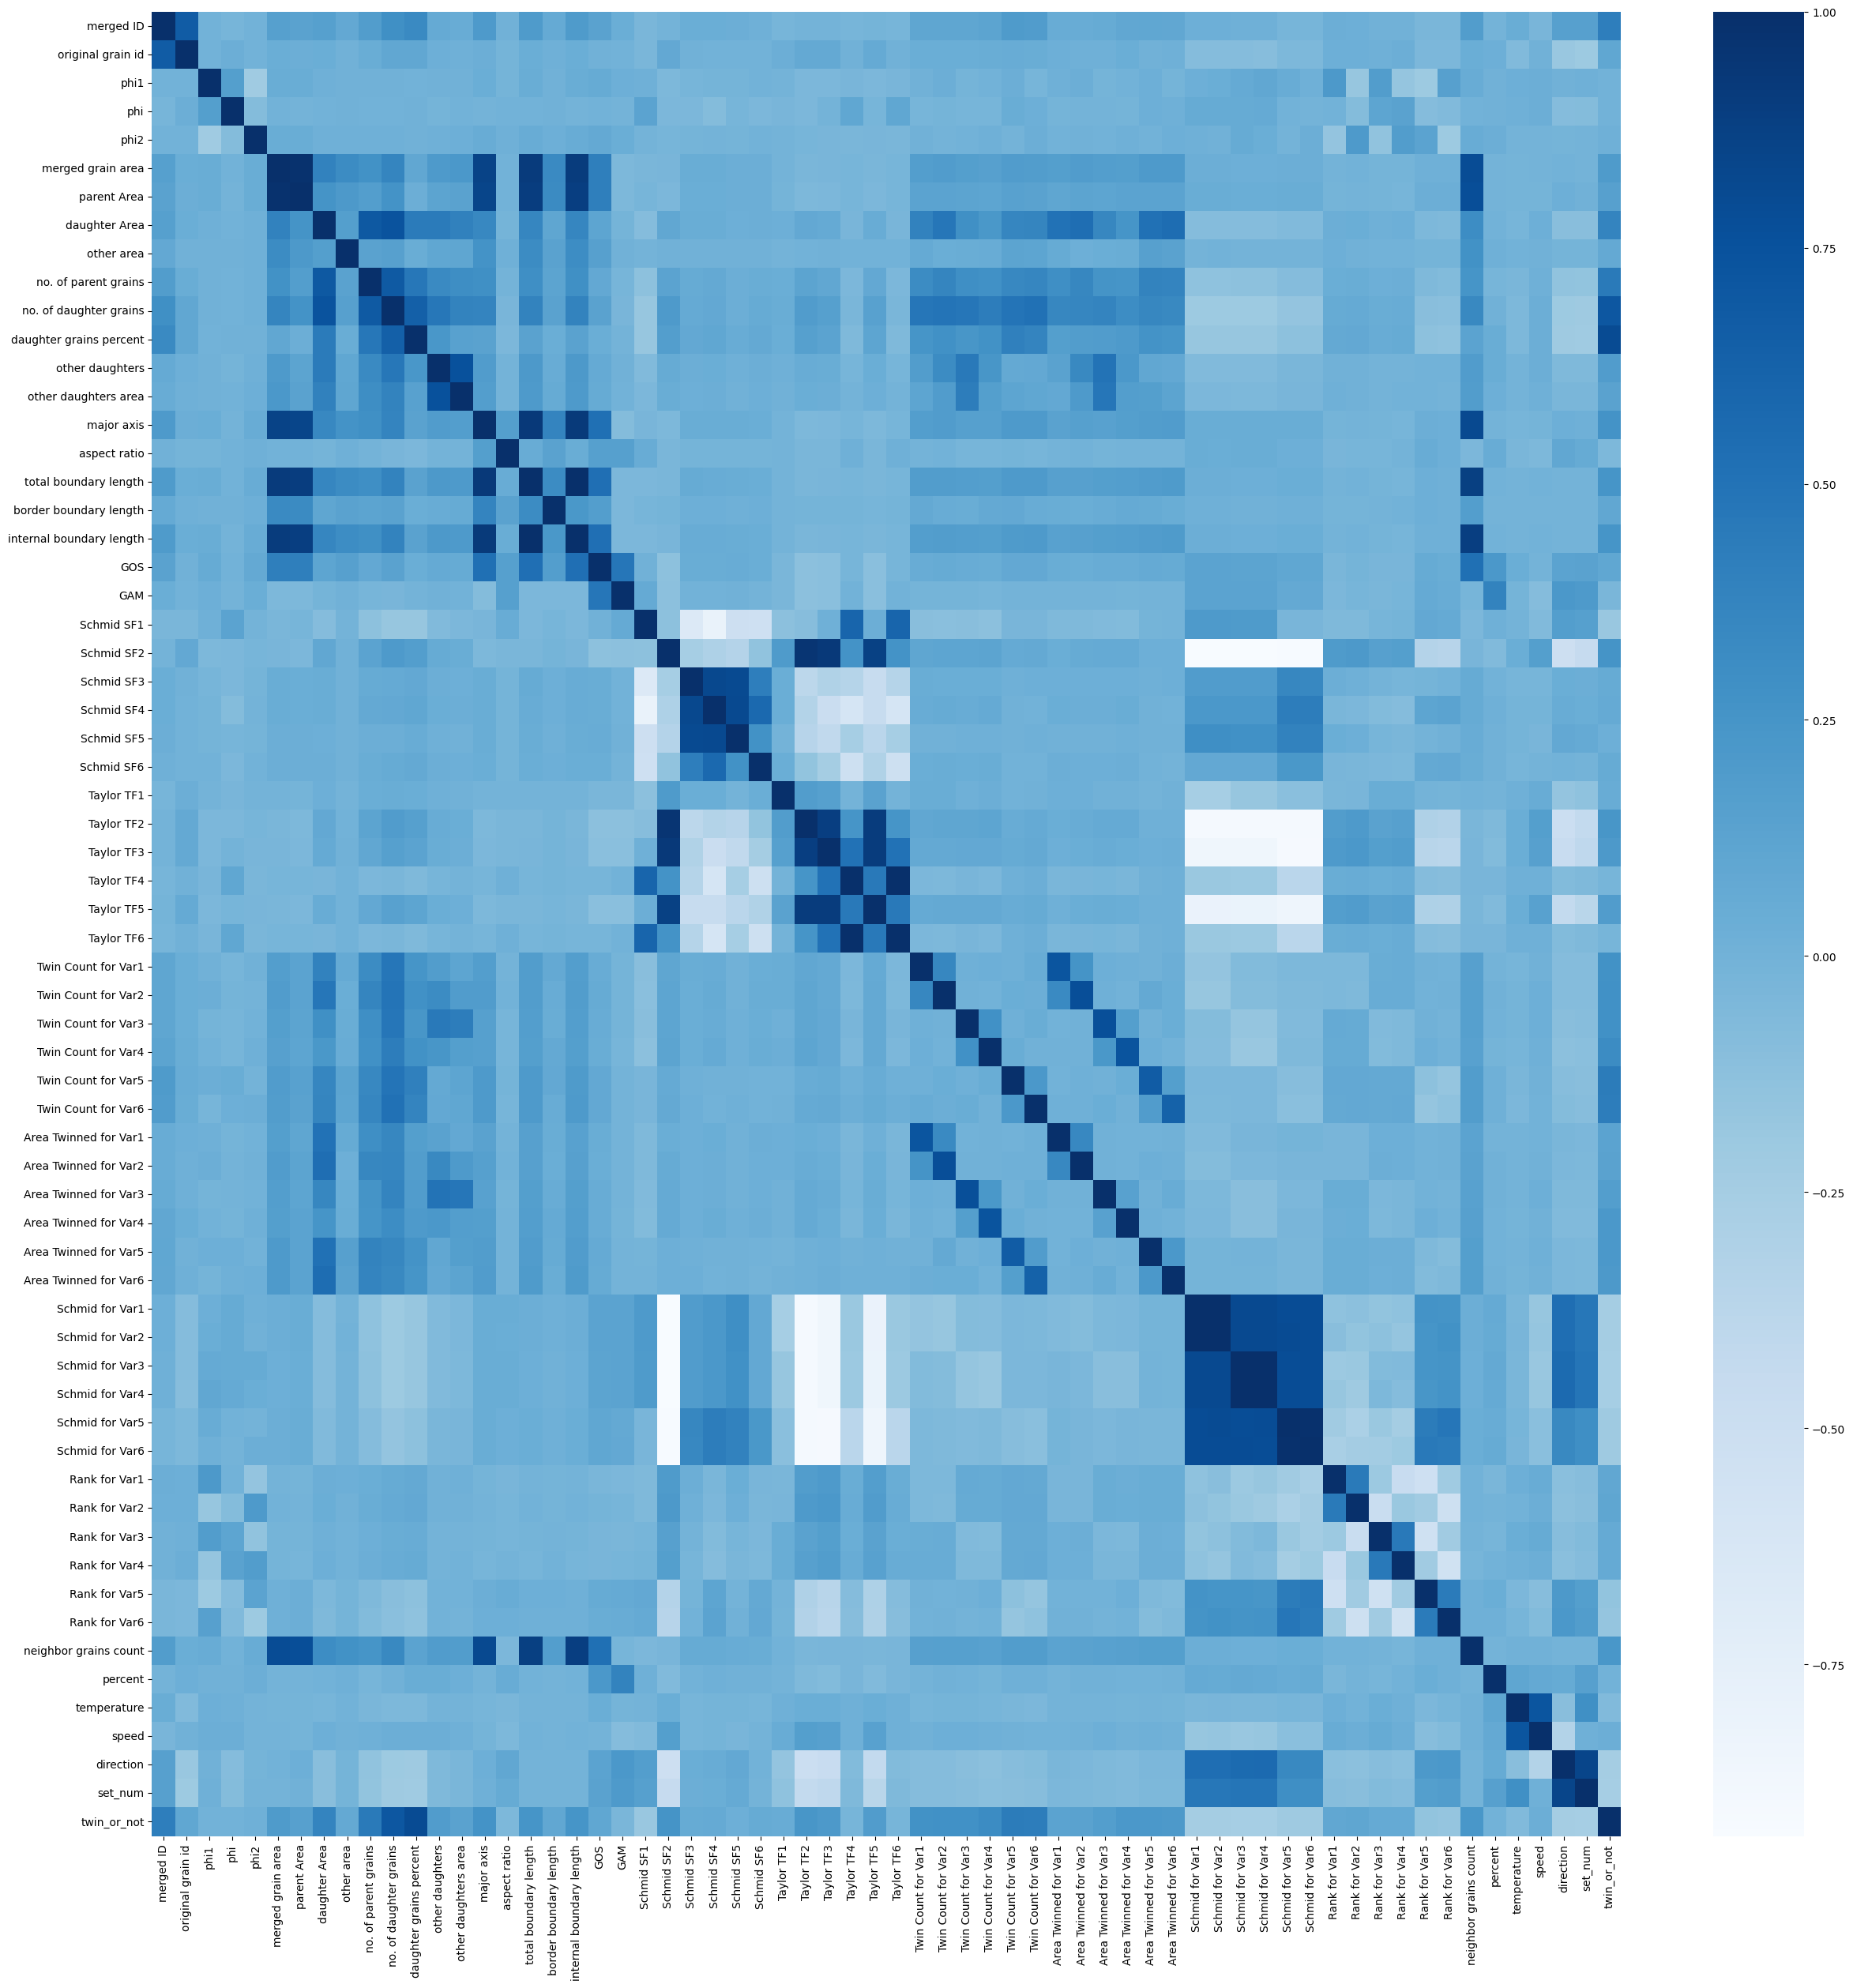

In [11]:
plt.figure(figsize=(30, 30))
sns.heatmap(df_with_y.corr(), cmap="Blues")
plt.show()

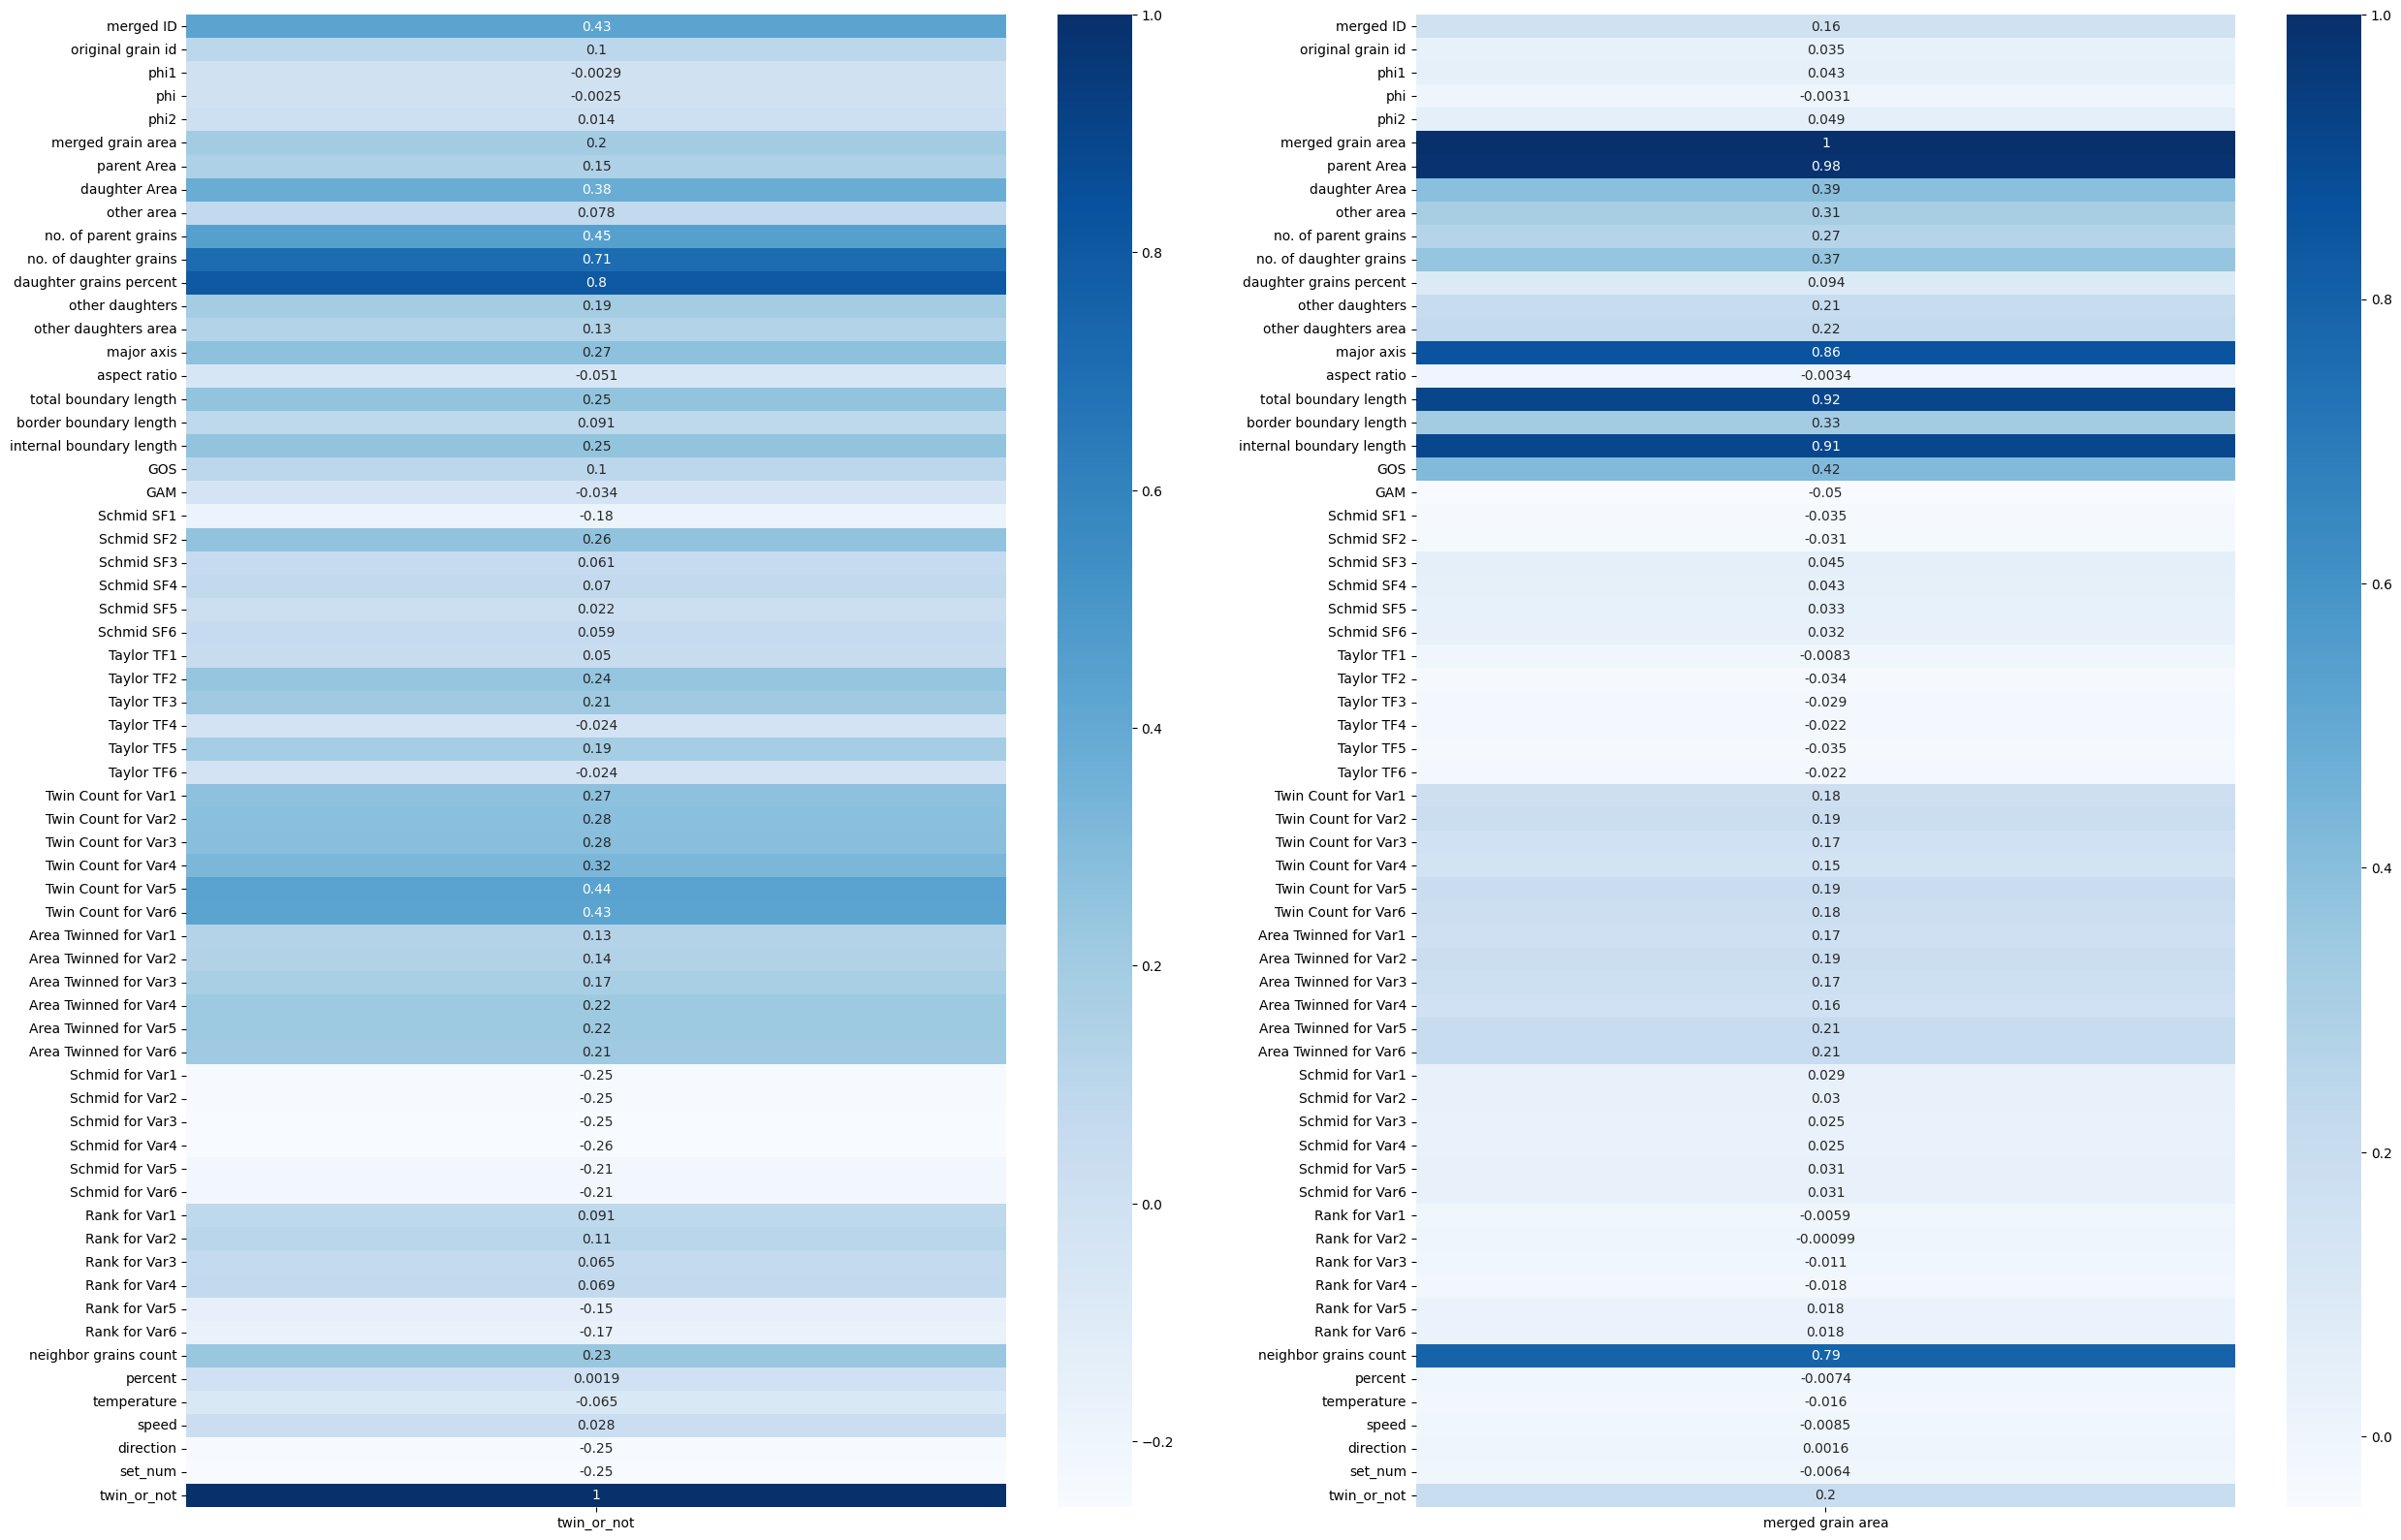

In [12]:
heatmap_data = df_with_y.corr()
h_1 = pd.DataFrame(heatmap_data["twin_or_not"])
h_2 = pd.DataFrame(heatmap_data["merged grain area"])

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(30, 20)
sns.heatmap(h_1, cmap="Blues", annot=True, ax=axes[0])
sns.heatmap(h_2, cmap="Blues", annot=True, ax=axes[1])

file_name = "correlation.png"
plt.savefig(file_name, bbox_inches="tight")

plt.show()

In [170]:
df_with_y[FEATURE_COLS]

phi1         phi       phi2  merged grain area  major axis  \
0      51.992588  340.060929   7.927710                 13    7.005978   
1      48.614823  347.530536  19.772951                 18    6.302616   
2      40.321865  353.327411  25.271908                 27   11.390991   
3      44.155840  351.273455  10.917894                 14    5.912449   
4      18.402519  309.171717  18.854361                 30   10.643656   
...          ...         ...        ...                ...         ...   
19890  39.399561  347.935385  17.936780                 52   19.304603   
19891  16.728591    0.639074  36.101943                309   26.175130   
19892  41.199993  358.019199  15.227974                772   49.512372   
19893  29.561427    1.504001  18.417803               1600   49.019670   
19894  49.563917  336.054992   6.881720                 35   14.336728   

       aspect ratio  total boundary length       GOS       GAM  Schmid SF1  \
0          2.965405                     20  0.330098  0.434837    0.117449   
1          1.733242                     22  0.224122  0.506251    0.493491   
2          3.774410                     38  0.388429  0.535767    0.496330   
3          1.961086                     22  0.467595  0.821457    0.401763   
4          2.965858                     31  0.330013  0.483631    0.138329   
...             ...                    ...       ...       ...         ...   
19890      5.628702                     58  0.695178  0.948414    0.484970   
19891      1.741442                    103  2.695314  1.647018    0.185162   
19892      2.494021                    197  4.378677  1.228912    0.417801   
19893      1.179535                    282  4.792458  0.587868    0.447378   
19894      4.612347                     52  2.436200  1.091397    0.486988   

       ...  Schmid for Var1  Schmid for Var2  Schmid for Var3  \
0      ...        -0.379939        -0.393457        -0.342003   
1      ...         0.152719         0.102248         0.268797   
2      ...         0.278925         0.277615         0.144290   
3      ...         0.091980         0.077800        -0.061026   
4      ...        -0.287217        -0.301246        -0.419138   
...    ...              ...              ...              ...   
19890  ...         0.231981         0.247504         0.103531   
19891  ...        -0.059609        -0.049749        -0.160178   
19892  ...         0.300977         0.341203         0.373084   
19893  ...         0.202070         0.245336         0.290048   
19894  ...         0.198691         0.200016        -0.046666   

       Schmid for Var4  Schmid for Var5  Schmid for Var6  percent  \
0            -0.329391         0.004713         0.005620        3   
1             0.259463         0.040409         0.100213        3   
2             0.089434         0.080978         0.137143        3   
3            -0.098899        -0.276438        -0.224385        3   
4            -0.402633         0.001460        -0.001015        3   
...                ...              ...              ...      ...   
19890         0.150018         0.058690        -0.003319        7   
19891        -0.145161        -0.440625        -0.465501        7   
19892         0.384626         0.305670         0.253903        7   
19893         0.307375         0.168119         0.107527        7   
19894         0.007423        -0.002779        -0.058194        7   

       temperature  speed  direction  
0              125      0          0  
1              125      0          0  
2              125      0          0  
3              125      0          0  
4              125      0          0  
...            ...    ...        ...  
19890          425      1         90  
19891          425      1         90  
19892          425      1         90  
19893          425      1         90  
19894          425      1         90  

[19895 rows x 31 columns]

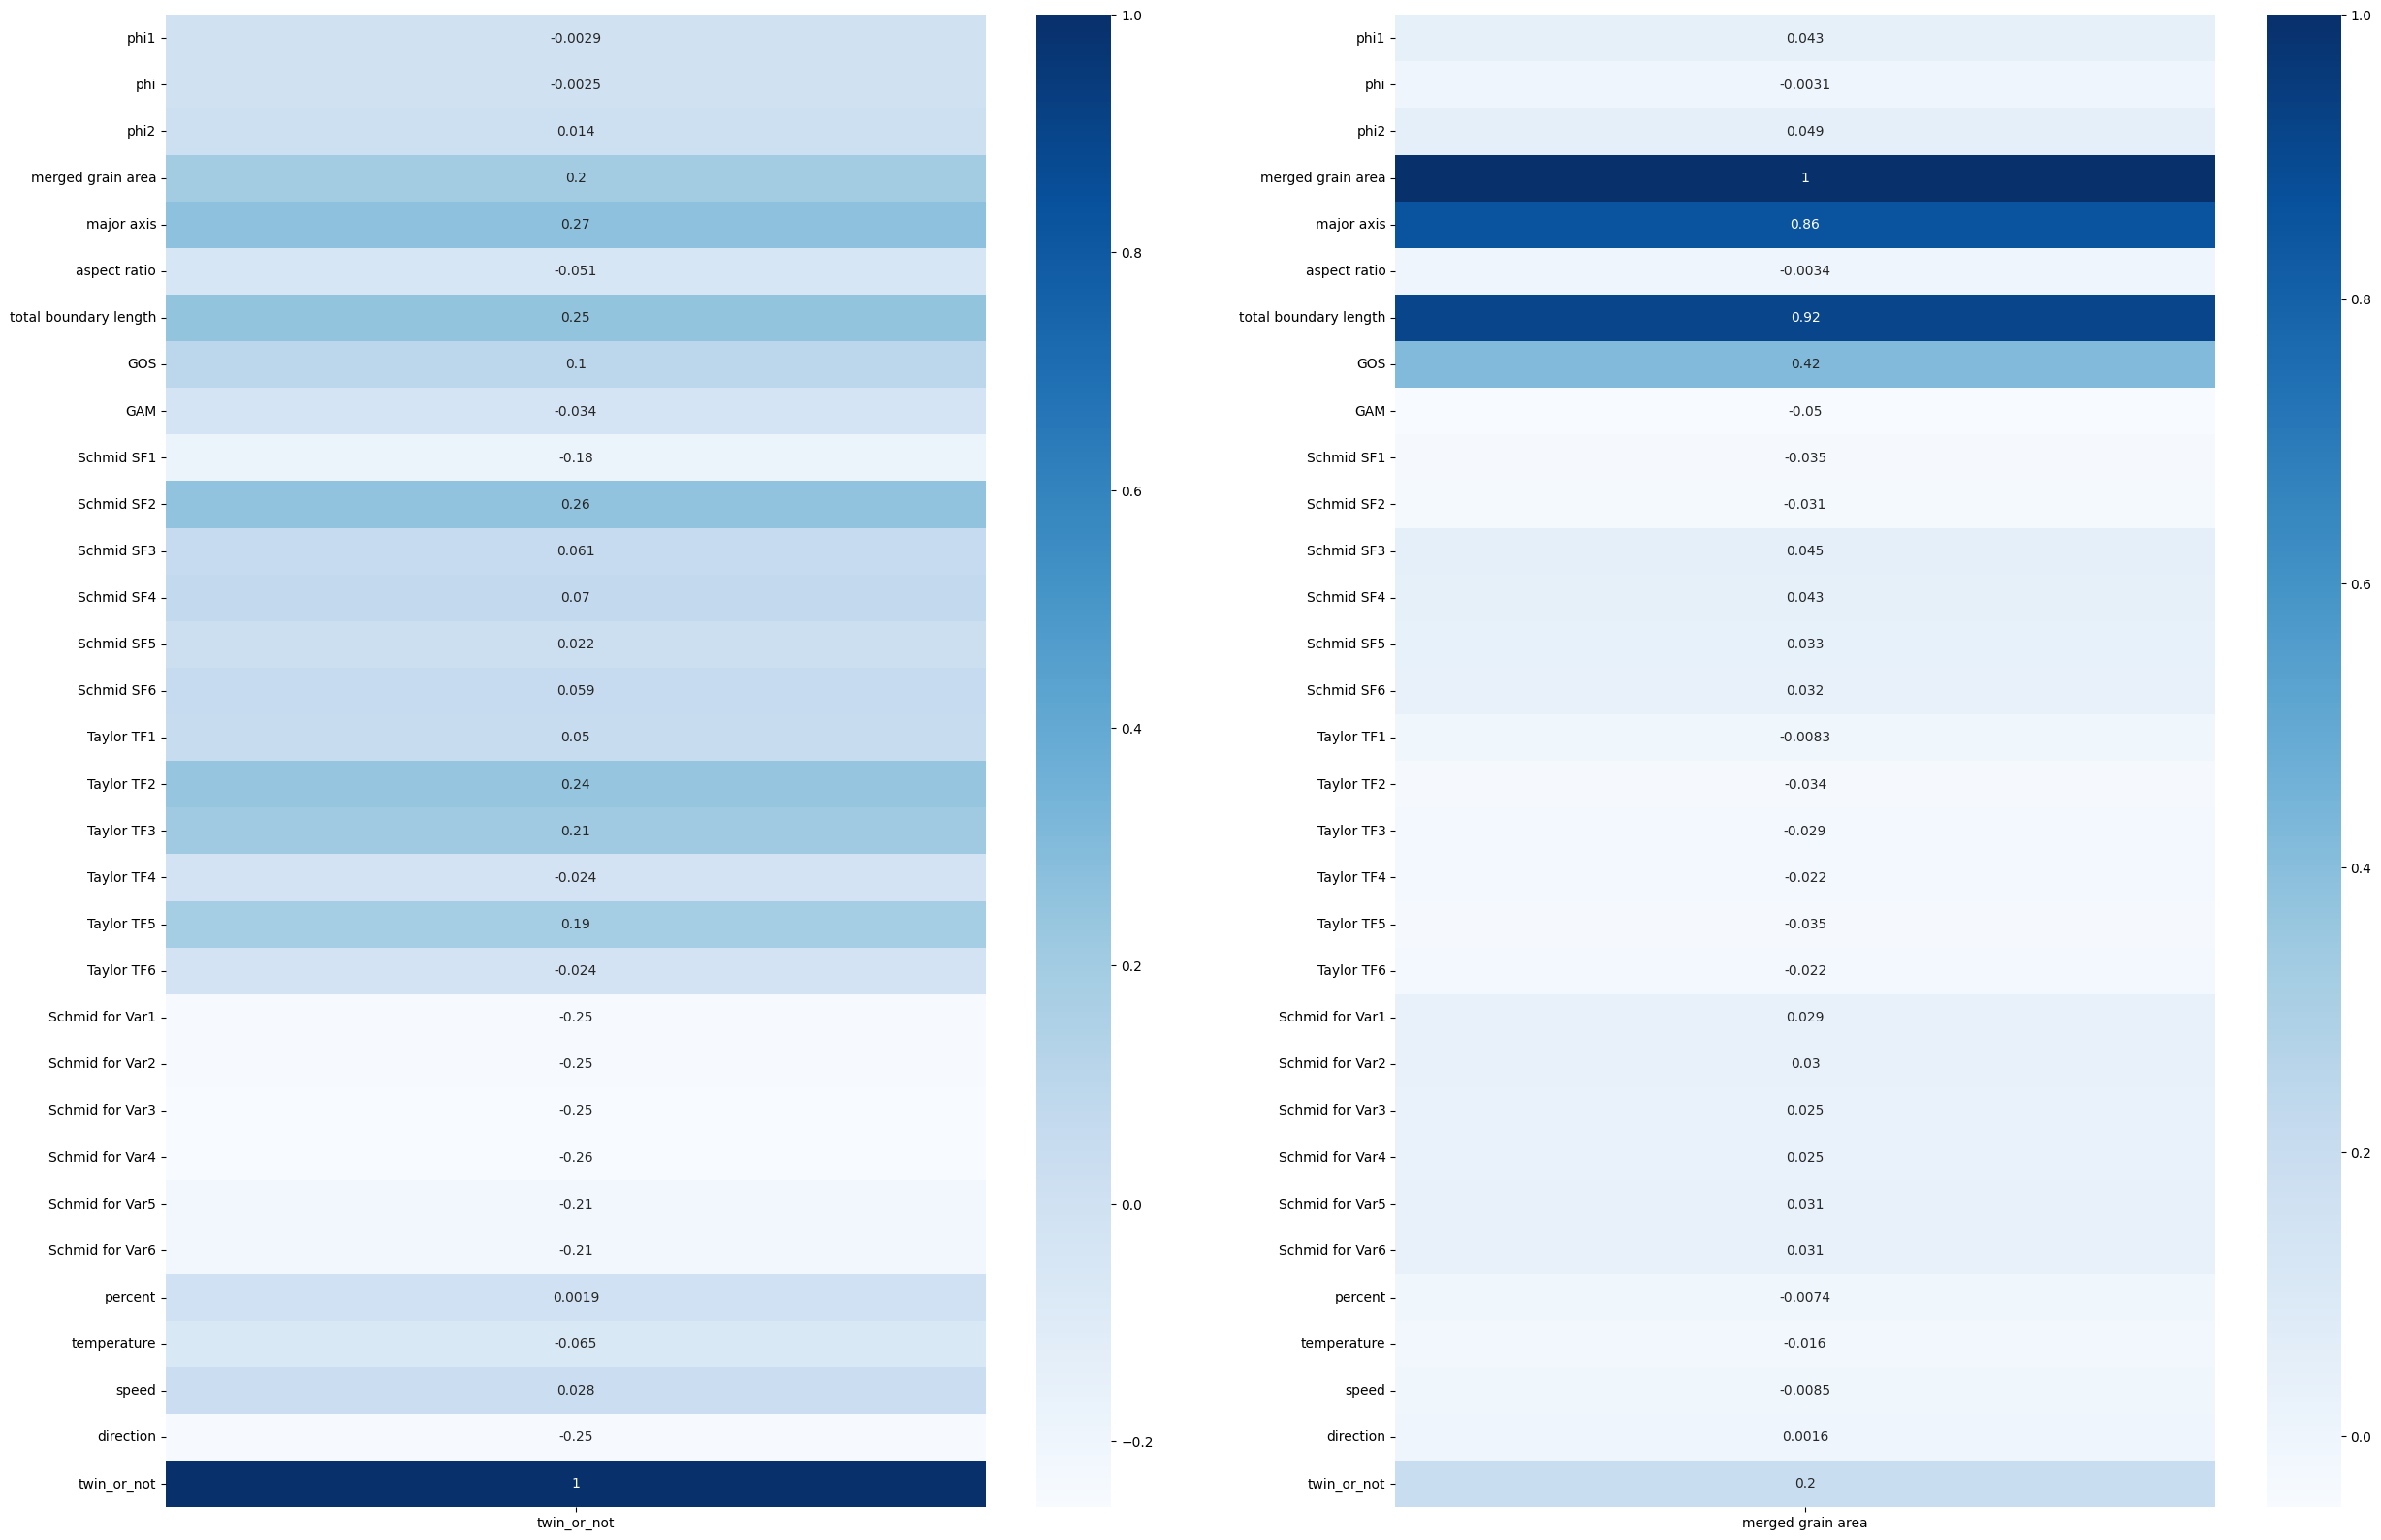

In [173]:
# df_with_y_and_deleted_impactful_columns = df_with_y.drop(columns=FEATURE_COLS_ACHIEVED_AFTERWARDS + [
#     "no. of daughter grains", 
#     "daughter grains percent",
#     ])

df_with_y_and_deleted_impactful_columns = df_with_y[FEATURE_COLS + ["twin_or_not"]]
heatmap_data = df_with_y_and_deleted_impactful_columns.corr()

h_1 = pd.DataFrame(heatmap_data["twin_or_not"])
h_2 = pd.DataFrame(heatmap_data["merged grain area"])

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(30, 20)
sns.heatmap(h_1, cmap="Blues", annot=True, ax=axes[0])
sns.heatmap(h_2, cmap="Blues", annot=True, ax=axes[1])

file_name = "correlation_without_impactful_columns.png"
plt.savefig(file_name, bbox_inches="tight")

plt.show()

In [14]:
edges = []
edge_info = df[EDGE_COL].map(lambda x: list(map(int, x.split(","))))
for i, e_list in enumerate(edge_info):
    for e in e_list:
        df_set = df[df["set_num"] == df.iloc[i]["set_num"]]
        node = df_set.index[df_set["merged ID"] == e].to_list()[0]
        
        new = [i, node]
        edges.append(new)
        
edge_index = torch.Tensor(edges).to(dtype=torch.long).t()

In [15]:
df.tail()

merged ID  original grain id       phi1         phi       phi2  \
19890        919                538  39.399561  347.935385  17.936780   
19891        920                746  16.728591    0.639074  36.101943   
19892        921                754  41.199993  358.019199  15.227974   
19893        922                803  29.561427    1.504001  18.417803   
19894        923                839  49.563917  336.054992   6.881720   

       merged grain area  parent Area  daughter Area  other area  \
19890                 52           30              0          22   
19891                309          233             76           0   
19892                772          590            182           0   
19893               1600         1068              0         532   
19894                 35           21             14           0   

       no. of parent grains  ...  Rank for Var4  Rank for Var5  Rank for Var6  \
19890                     1  ...              3              5              6   
19891                     1  ...              4              2              1   
19892                     1  ...              1              4              6   
19893                     1  ...              1              5              6   
19894                     1  ...              5              6              3   

       neighbor grains count  \
19890                      3   
19891                      7   
19892                      9   
19893                     18   
19894                      1   

                                      neighbor grain ids  percent  \
19890                                        532,545,547        7   
19891                        696,698,705,724,728,746,922        7   
19892                679,682,686,707,711,720,723,763,808        7   
19893  687,692,698,706,715,728,735,739,766,769,770,77...        7   
19894                                                896        7   

       temperature  speed  direction  set_num  
19890          425      1         90       27  
19891          425      1         90       27  
19892          425      1         90       27  
19893          425      1         90       27  
19894          425      1         90       27  

[5 rows x 64 columns]

In [16]:
np.random.seed(1105)

train_ratio = 0.8

pos_indices = np.where(y == 1)[0]
pos_indices_train, pos_indices_others = train_test_split(
    pos_indices,
    train_size=train_ratio
)
pos_indices_val, pos_indices_test = train_test_split(
    pos_indices_others,
    train_size=0.5
)
assert len(pos_indices) == len(pos_indices_train) + len(pos_indices_val) + len(pos_indices_test)
assert set(pos_indices.tolist()) == set(pos_indices_train.tolist()) | set(pos_indices_val.tolist()) | set(pos_indices_test.tolist())
assert len(set(pos_indices_train.tolist()).intersection(set(pos_indices_val.tolist())).intersection(set(pos_indices_test.tolist()))) == 0

neg_indices = np.where(y == 0)[0]
neg_indices_train, neg_indices_others = train_test_split(
    neg_indices,
    train_size=train_ratio
)
neg_indices_val, neg_indices_test = train_test_split(
    neg_indices_others,
    train_size=0.5
)
assert len(neg_indices) == len(neg_indices_train) + len(neg_indices_val) + len(neg_indices_test)
assert set(neg_indices.tolist()) == set(neg_indices_train.tolist()) | set(neg_indices_val.tolist()) | set(neg_indices_test.tolist())
assert len(set(neg_indices_train.tolist()).intersection(set(neg_indices_val.tolist())).intersection(set(neg_indices_test.tolist()))) == 0

train_indices = pos_indices_train.tolist() + neg_indices_train.tolist()
val_indices = pos_indices_val.tolist() + neg_indices_val.tolist()
test_indices = pos_indices_test.tolist() + neg_indices_test.tolist()

print(f"{len(train_indices) = }")
print(f"{len(val_indices) = }")
print(f"{len(test_indices) = }")

print("split done!")

len(train_indices) = 15915
len(val_indices) = 1990
len(test_indices) = 1990
split done!


In [17]:
tmp_train_mask = np.zeros_like(y)
for i in train_indices:
    tmp_train_mask[i] = 1
train_mask = torch.Tensor(tmp_train_mask).to(dtype=bool)

tmp_val_mask = np.zeros_like(y)
for i in val_indices:
    tmp_val_mask[i] = 1
val_mask = torch.Tensor(tmp_val_mask).to(dtype=bool)

tmp_test_mask = np.zeros_like(y)
for i in test_indices:
    tmp_test_mask[i] = 1
test_mask = torch.Tensor(tmp_test_mask).to(dtype=bool)

assert (train_mask.to(dtype=torch.int16) + val_mask.to(dtype=torch.int16) + test_mask.to(dtype=torch.int16) == 1).all()

In [18]:
FEATURE_COLS_COMBINED = FEATURE_COLS + FEATURE_COLS_ACHIEVED_AFTERWARDS

In [376]:
X_train = df.loc[train_mask.numpy(), FEATURE_COLS]
X_val = df.loc[val_mask.numpy(), FEATURE_COLS]
X_test = df.loc[test_mask.numpy(), FEATURE_COLS]
y_train = y[train_mask.numpy()]
y_val = y[val_mask.numpy()]
y_test = y[test_mask.numpy()]

print(f"{X_train.shape = } / {X_val.shape} / {X_test.shape}")
print(f"{y_train.shape = } / {y_val.shape} / {y_test.shape}")

X_train.shape = (15915, 31) / (1990, 31) / (1990, 31)
y_train.shape = (15915,) / (1990,) / (1990,)


In [377]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

In [378]:
X = np.zeros_like(df[FEATURE_COLS])
X[train_mask.numpy(), :] = X_train_norm
X[val_mask.numpy(), :] = X_val_norm
X[test_mask.numpy(), :] = X_test_norm

In [379]:
data = Data(
    x=torch.Tensor(X),
    y=torch.Tensor(y),
    edge_index=edge_index,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)

In [380]:
data

Data(x=[19895, 31], edge_index=[2, 107484], y=[19895], train_mask=[19895], val_mask=[19895], test_mask=[19895])

In [382]:
pd.DataFrame(X, columns=FEATURE_COLS).describe()

phi1           phi          phi2  merged grain area  \
count  19895.000000  19895.000000  19895.000000       19895.000000   
mean      -0.002250     -0.000063      0.002114           0.002729   
std        1.003738      0.999527      1.002992           0.995452   
min       -1.107744     -2.374025     -1.017041          -0.364533   
25%       -0.647040      0.217535     -0.598822          -0.335454   
50%       -0.135712      0.424019     -0.150969          -0.256361   
75%        0.591582      0.523435      0.530043          -0.042344   
max       12.558506      0.590889     11.717143          33.487426   

         major axis  aspect ratio  total boundary length           GOS  \
count  19895.000000  19895.000000           19895.000000  19895.000000   
mean       0.003605      0.000826               0.001525      0.003949   
std        1.009343      0.992778               0.995571      1.001371   
min       -0.895777     -0.954828              -0.689968     -0.985878   
25%       -0.617292     -0.565578              -0.502793     -0.662369   
50%       -0.286432     -0.268894              -0.278183     -0.345884   
75%        0.252023      0.215900               0.114884      0.304210   
max       11.561715     17.358032              21.312434      9.982114   

                GAM    Schmid SF1  ...  Schmid for Var1  Schmid for Var2  \
count  19895.000000  19895.000000  ...     19895.000000     19895.000000   
mean       0.001588     -0.003218  ...         0.002789         0.002162   
std        1.000073      1.002071  ...         0.999717         0.999759   
min       -1.429823     -2.520698  ...        -2.594438        -2.592082   
25%       -0.678186     -0.718339  ...        -0.632532        -0.635718   
50%       -0.232537      0.265074  ...         0.265983         0.266222   
75%        0.372982      0.844258  ...         0.837979         0.833695   
max       13.040906      1.265505  ...         1.232796         1.229805   

       Schmid for Var3  Schmid for Var4  Schmid for Var5  Schmid for Var6  \
count     19895.000000     19895.000000     19895.000000     19895.000000   
mean         -0.001701        -0.002692         0.003786         0.005443   
std           1.004813         1.004602         0.998704         0.998843   
min          -2.476915        -2.476202        -2.360346        -2.362032   
25%          -0.624708        -0.625007        -0.717164        -0.709522   
50%           0.271481         0.265862         0.107064         0.105531   
75%           0.841656         0.837945         0.889934         0.897203   
max           1.221162         1.219414         1.451523         1.457544   

            percent   temperature         speed     direction  
count  19895.000000  19895.000000  19895.000000  19895.000000  
mean       0.001909     -0.000805      0.001245     -0.002332  
std        1.000179      0.996510      0.999690      1.000597  
min       -0.921687     -1.843064     -1.303919     -1.276601  
25%       -0.921687     -0.546835     -1.303919     -1.276601  
50%       -0.921687     -0.114759      0.766919      0.783330  
75%        1.084968      0.749394      0.766919      0.783330  
max        1.084968      1.613546      0.766919      0.783330  

[8 rows x 31 columns]

In [383]:
# from torch_geometric.datasets import Planetoid
# from torch_geometric.transforms import NormalizeFeatures

# dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]

In [384]:
rf_model = RandomForestClassifier(
    # n_estimators=30,
    # max_depth=10,
    # random_state=1105
)

rf_model.fit(X_train_norm, y[train_mask])
y_pred = rf_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


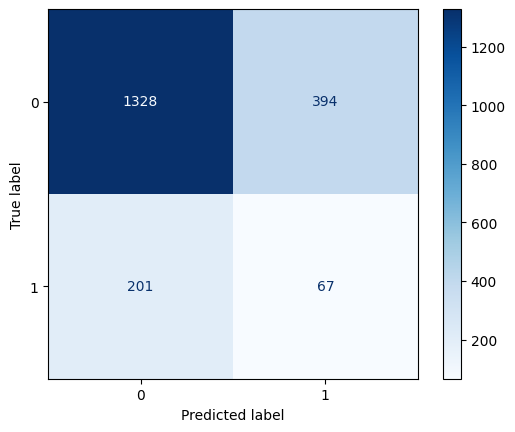

Accuracy: 0.7010
Precision: 0.1453
Recall: 0.2500
f1 score: 0.1838


In [385]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

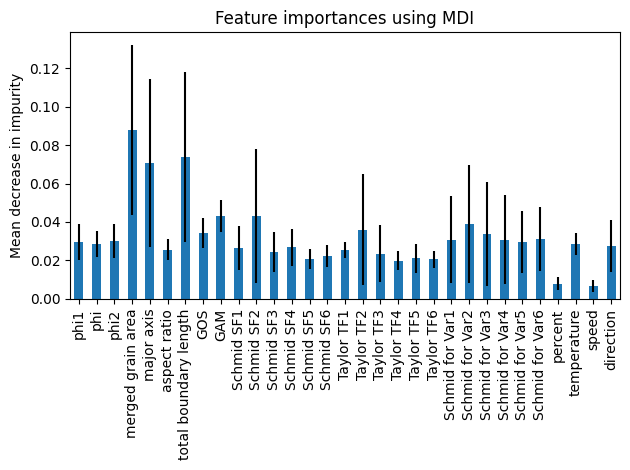

In [386]:
importances = rf_model.feature_importances_
forest_std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=FEATURE_COLS)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=forest_std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


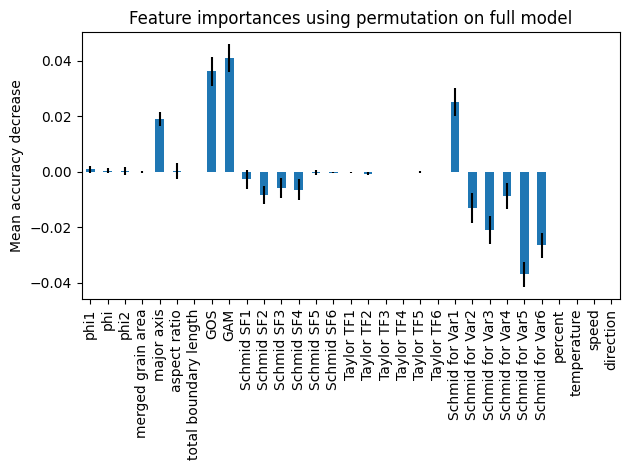

In [387]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_model, X_test, y_test, n_repeats=30, random_state=1105, n_jobs=3
)
pm_importances = pd.Series(result.importances_mean, index=FEATURE_COLS)

fig, ax = plt.subplots()
pm_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [388]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    random_state=1105
)

lr_model.fit(X_train_norm, y[train_mask])
y_pred = lr_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [389]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

Accuracy: 0.8653
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [390]:
from sklearn.svm import LinearSVC

class_weight = {
    0: 1.0,
    1: 30.0
}
svc_model = LinearSVC(
    class_weight=class_weight,
    random_state=1105
)

svc_model.fit(X_train_norm, y[train_mask])
y_pred = svc_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


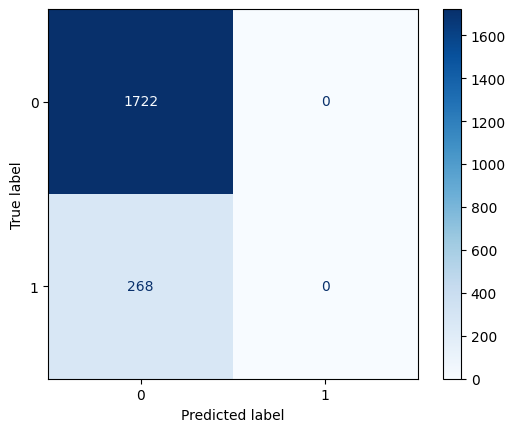

Accuracy: 0.8653
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [391]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [392]:
def count_parameters(params):
    num = sum(p.numel() for p in params if p.requires_grad)
    print(f"{num:,}")
    return num

In [431]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels * 2)
        self.lin3 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.lin4 = Linear(hidden_channels * 4, hidden_channels * 8)
        self.lin5 = Linear(hidden_channels * 8, hidden_channels * 4)
        self.lin6 = Linear(hidden_channels * 4, hidden_channels * 2)
        self.lin7 = Linear(hidden_channels * 2, 1)
        self.norm1 = torch.nn.LayerNorm(hidden_channels)
        self.norm2 = torch.nn.LayerNorm(hidden_channels * 2)
        self.norm3 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm4 = torch.nn.LayerNorm(hidden_channels * 8)
        self.norm5 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm6 = torch.nn.LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin7(x)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x
    
model = MLP(hidden_channels=64)
print(f"MLP model number of params: {count_parameters(model.parameters()):,}")

342,017
MLP model number of params: 342,017


In [432]:
weight = torch.Tensor([1.0, 2.5])
criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    X_tmp = data.x[data.train_mask]
    y_tmp = data.y[data.train_mask]
    preds = model(X_tmp).squeeze()  # Perform a single forward pass.
    loss = criterion(preds, y_tmp)  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_X_tmp = data.x[data.val_mask]
        v_y_tmp = data.y[data.val_mask]
        v_preds = model(v_X_tmp).squeeze()
        v_loss = criterion(v_preds, v_y_tmp)
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.8170 / Val_loss: 0.4073
Epoch: 002, Train_loss: 0.5628 / Val_loss: 0.4012
Epoch: 003, Train_loss: 0.4557 / Val_loss: 0.4168
Epoch: 004, Train_loss: 0.4212 / Val_loss: 0.4288
Epoch: 005, Train_loss: 0.4103 / Val_loss: 0.4361
Epoch: 006, Train_loss: 0.4131 / Val_loss: 0.4397
Epoch: 007, Train_loss: 0.4099 / Val_loss: 0.4406
Epoch: 008, Train_loss: 0.4146 / Val_loss: 0.4393
Epoch: 009, Train_loss: 0.4140 / Val_loss: 0.4362
Epoch: 010, Train_loss: 0.4163 / Val_loss: 0.4318
Epoch: 011, Train_loss: 0.4153 / Val_loss: 0.4265
Epoch: 012, Train_loss: 0.4135 / Val_loss: 0.4206
Epoch: 013, Train_loss: 0.4128 / Val_loss: 0.4147
Epoch: 014, Train_loss: 0.4098 / Val_loss: 0.4089
Epoch: 015, Train_loss: 0.4090 / Val_loss: 0.4037
Epoch: 016, Train_loss: 0.4060 / Val_loss: 0.3992
Epoch: 017, Train_loss: 0.4031 / Val_loss: 0.3958
Epoch: 018, Train_loss: 0.4011 / Val_loss: 0.3934
Epoch: 019, Train_loss: 0.3999 / Val_loss: 0.3919
Epoch: 020, Train_loss: 0.4019 / Val_loss: 0.3911


In [433]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

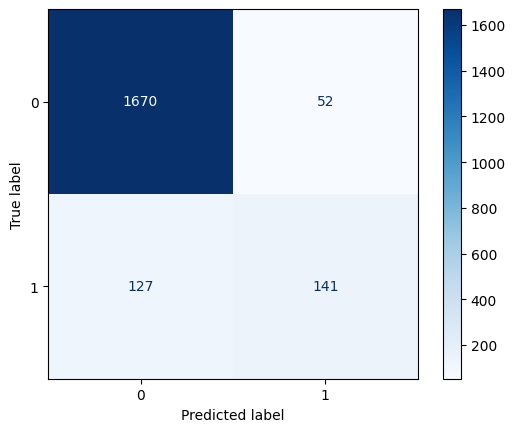

Accuracy: 0.9101
Precision: 0.7306
Recall: 0.5261
f1 score: 0.6117


In [434]:
model.eval()
with torch.no_grad():
    out_mlp = model(data.x[data.test_mask])
# pred = out.argmax(dim=1)  # Use the class with highest probability.
pred_mlp = F.sigmoid(out_mlp).round()

y_true = data.y[data.test_mask].numpy()
y_pred = pred_mlp.numpy()

cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()


print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [435]:
import shap

shap.initjs()

shap_data = data.x[data.train_mask]
background = shap_data[np.random.choice(shap_data.shape[0], 2000, replace=False)]
shap_test = data.x[data.test_mask][np.random.choice(data.x[data.test_mask].shape[0], 200, replace=False)]

explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(shap_test, check_additivity=False)

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f'unrecognized nn.Module: {module_type}')


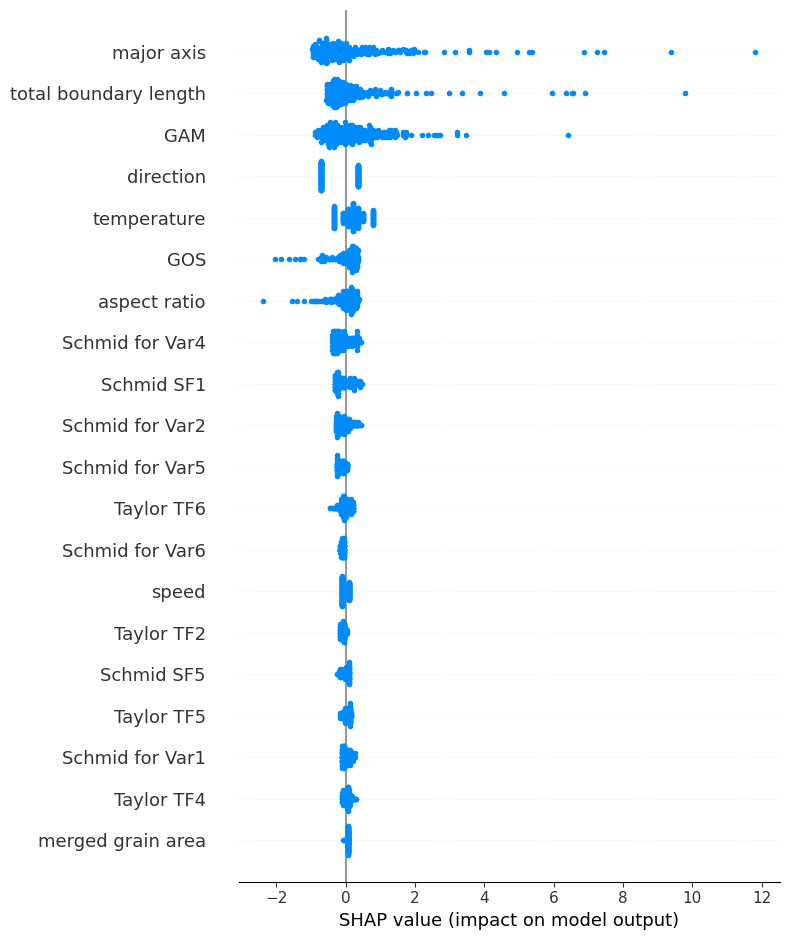

In [436]:
# exp = shap.Explanation(shap_values.squeeze(), feature_names=FEATURE_COLS)
# shap.plots.beeswarm(exp, color=['red', 'blue'])

shap.summary_plot(shap_values.squeeze(), feature_names=FEATURE_COLS)

In [437]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GCNConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GCNConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        x = x.squeeze()
        # x = self.log_softmax(x)
        return x

model = GCN(hidden_channels=64)
print(f"GCN model number of params: {count_parameters(model.parameters()):,}")

342,017
GCN model number of params: 342,017


In [438]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.5200 / Val_loss: 0.5193
Epoch: 002, Train_loss: 0.4676 / Val_loss: 0.4685
Epoch: 003, Train_loss: 0.4331 / Val_loss: 0.4253
Epoch: 004, Train_loss: 0.4343 / Val_loss: 0.4308
Epoch: 005, Train_loss: 0.4220 / Val_loss: 0.4192
Epoch: 006, Train_loss: 0.4212 / Val_loss: 0.4272
Epoch: 007, Train_loss: 0.4170 / Val_loss: 0.4196
Epoch: 008, Train_loss: 0.4118 / Val_loss: 0.4094
Epoch: 009, Train_loss: 0.4101 / Val_loss: 0.4069
Epoch: 010, Train_loss: 0.4109 / Val_loss: 0.4072
Epoch: 011, Train_loss: 0.4084 / Val_loss: 0.4057
Epoch: 012, Train_loss: 0.4072 / Val_loss: 0.4008
Epoch: 013, Train_loss: 0.4035 / Val_loss: 0.4077
Epoch: 014, Train_loss: 0.4029 / Val_loss: 0.4046
Epoch: 015, Train_loss: 0.4018 / Val_loss: 0.3998
Epoch: 016, Train_loss: 0.4018 / Val_loss: 0.3981
Epoch: 017, Train_loss: 0.3970 / Val_loss: 0.4061
Epoch: 018, Train_loss: 0.3980 / Val_loss: 0.3996
Epoch: 019, Train_loss: 0.3966 / Val_loss: 0.4007
Epoch: 020, Train_loss: 0.3955 / Val_loss: 0.3982


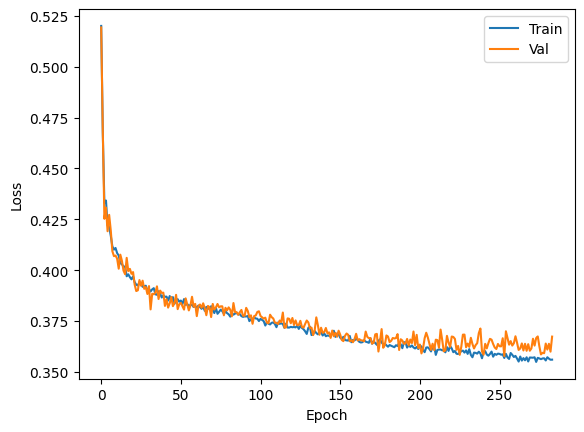

In [439]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [440]:
model.eval()
# pred = out.argmax(dim=1)  # Use the class with highest probability.
with torch.no_grad():
    out_gcn = model(data.x, data.edge_index)
pred_gcn = F.sigmoid(out_gcn).round()

y_pred = pred_gcn[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

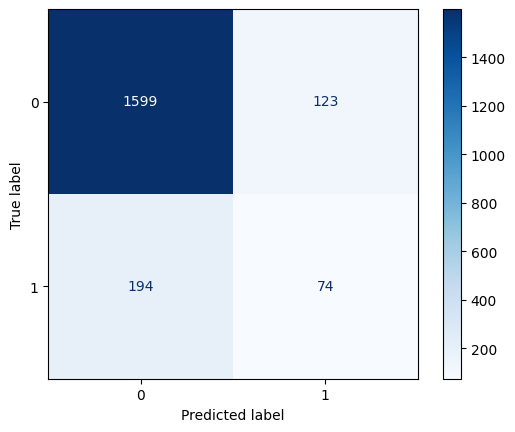

Accuracy: 0.8407
Precision: 0.3756
Recall: 0.2761
f1 score: 0.3183


In [441]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

#### Data analysis for `wrong` samples

In [442]:
y_true.shape

(1990,)

In [443]:
pred_mlp.shape

torch.Size([1990, 1])

In [444]:
pred_gcn[data.test_mask].shape

torch.Size([1990])

In [445]:
mlp = pred_mlp.squeeze().numpy()

mlp_fn = np.where(
    (y_true == 1) &
    (mlp == 0)
)[0]

mlp_fp = np.where(
    (y_true == 0) &
    (mlp == 1)
)[0]

mlp_f = np.where(
    y_true != mlp
)[0]
print(mlp_f)

# the number of wrong predictions shoule be 179
assert len(mlp_f) == 179
assert len(mlp_f) == len(mlp_fn) + len(mlp_fp)
assert len(set(mlp_fp).intersection(set(mlp_fn))) == 0

[  10   30   39   43   53   67   70  111  112  122  133  140  145  151
  156  158  159  160  162  166  167  173  176  178  183  184  190  192
  193  230  234  236  238  240  242  243  253  258  260  282  286  287
  297  298  310  312  320  349  351  355  359  361  380  386  412  414
  415  418  423  425  427  431  444  448  464  470  480  481  483  484
  494  495  496  497  498  499  500  502  508  509  511  523  534  543
  550  557  564  565  566  568  569  571  580  588  600  601  602  603
  604  605  608  609  611  612  613  614  617  618  630  656  658  660
  662  663  664  665  666  669  745  768  811  812  814  815  818  819
  886  888  889  890  891  947  977 1046 1047 1048 1049 1050 1051 1054
 1055 1056 1058 1141 1144 1145 1219 1220 1222 1223 1300 1301 1302 1337
 1384 1387 1388 1389 1443 1444 1445 1526 1528 1533 1583 1622 1623 1625
 1673 1674 1760 1763 1821 1822 1823 1897 1898 1899 1902]


In [446]:
gcn = pred_gcn[data.test_mask].numpy()

gcn_fn = np.where(
    (y_true == 1) &
    (gcn == 0)
)[0]

gcn_fp = np.where(
    (y_true == 0) &
    (gcn == 1)
)[0]

gcn_f = np.where(
    y_true != gcn
)[0]
print(gcn_f)

# the number of wrong predictions shoule be 317
assert len(gcn_f) == 317
assert len(gcn_f) == len(gcn_fn) + len(gcn_fp)
assert len(set(gcn_fp).intersection(set(gcn_fn))) == 0

[   1    3    4    5    6    7    8    9   12   13   17   18   19   20
   22   23   24   25   27   28   29   30   31   32   33   35   36   44
   53   76   80   87   91   94   95   97   98   99  111  112  113  114
  117  118  119  120  121  122  123  124  130  131  132  136  143  150
  152  160  165  166  167  168  170  171  173  174  176  177  178  183
  189  196  207  213  224  226  228  230  232  233  234  235  236  242
  244  250  255  258  260  261  263  264  265  267  268  272  278  285
  286  287  288  289  291  294  297  299  300  312  314  318  319  320
  336  349  350  351  352  354  356  357  360  361  363  377  378  379
  381  390  397  399  400  412  413  414  415  416  417  418  419  420
  422  423  424  427  428  429  430  431  432  440  442  444  445  447
  448  449  451  452  456  457  458  461  462  480  487  489  491  492
  494  495  496  497  498  501  502  503  504  505  508  509  512  514
  531  554  556  564  565  569  570  573  580  585  590  592  594  596
  597 

In [447]:
len(set(mlp_f.tolist()).difference(set(gcn_f.tolist())))

57

In [448]:
len(set(gcn_f.tolist()).difference(set(mlp_f.tolist())))

195

In [449]:
len(set(mlp_f.tolist()).intersection(set(gcn_f.tolist())))

122

#### MLP는 맞았는데 GCN은 틀린 예측

In [83]:
df_with_y_again = pd.concat([df, pd.Series(y, name="twin_or_not")], axis=1)
df_with_y_again

merged ID  original grain id       phi1         phi       phi2  \
0              1                  1  51.992588  340.060929   7.927710   
1              2                  2  48.614823  347.530536  19.772951   
2              3                  5  40.321865  353.327411  25.271908   
3              4                  7  44.155840  351.273455  10.917894   
4              5                 10  18.402519  309.171717  18.854361   
...          ...                ...        ...         ...        ...   
19890        919                538  39.399561  347.935385  17.936780   
19891        920                746  16.728591    0.639074  36.101943   
19892        921                754  41.199993  358.019199  15.227974   
19893        922                803  29.561427    1.504001  18.417803   
19894        923                839  49.563917  336.054992   6.881720   

       merged grain area  parent Area  daughter Area  other area  \
0                     13           13              0           0   
1                     18           18              0           0   
2                     27           27              0           0   
3                     14           14              0           0   
4                     30           30              0           0   
...                  ...          ...            ...         ...   
19890                 52           30              0          22   
19891                309          233             76           0   
19892                772          590            182           0   
19893               1600         1068              0         532   
19894                 35           21             14           0   

       no. of parent grains  ...  Rank for Var5  Rank for Var6  \
0                         1  ...              6              5   
1                         1  ...              6              5   
2                         1  ...              6              4   
3                         1  ...              1              2   
4                         1  ...              5              6   
...                     ...  ...            ...            ...   
19890                     1  ...              5              6   
19891                     1  ...              2              1   
19892                     1  ...              4              6   
19893                     1  ...              5              6   
19894                     1  ...              6              3   

       neighbor grains count  \
0                          2   
1                          3   
2                          3   
3                          2   
4                          2   
...                      ...   
19890                      3   
19891                      7   
19892                      9   
19893                     18   
19894                      1   

                                      neighbor grain ids  percent  \
0                                                455,479        3   
1                                            457,462,552        3   
2                                               8,11,459        3   
3                                                461,463        3   
4                                                458,481        3   
...                                                  ...      ...   
19890                                        532,545,547        7   
19891                        696,698,705,724,728,746,922        7   
19892                679,682,686,707,711,720,723,763,808        7   
19893  687,692,698,706,715,728,735,739,766,769,770,77...        7   
19894                                                896        7   

       temperature  speed  direction  set_num  twin_or_not  
0              125      0          0        0            0  
1              125      0          0        0            0  
2              125      0          0        0            0  
3              125      0          0        0            0  
4

In [84]:
test_indices_arr = torch.where(data.test_mask == True)[0].numpy()
only_mlp_got_right_indices_for_indices = list(set(gcn_f.tolist()).difference(set(mlp_f.tolist())))
only_mlp_got_right = test_indices_arr[only_mlp_got_right_indices_for_indices]

only_gcn_got_right_indices_for_indices = list(set(mlp_f.tolist()).difference(set(gcn_f.tolist())))
only_gcn_got_right = test_indices_arr[only_gcn_got_right_indices_for_indices]

In [85]:
df_with_y_again.iloc[only_mlp_got_right]

merged ID  original grain id       phi1         phi       phi2  \
5078          48                 96  38.946765  341.612387  32.864185   
20            21                 68  25.738989  340.820804  46.377058   
5102          72                136  27.407944  339.788286  44.473190   
39            40                130  26.945316   10.288850  20.015697   
55            56                190  44.263149  332.250381  15.586187   
...          ...                ...        ...         ...        ...   
5007         703               1456   4.967168  328.975805  47.537274   
5019         715               1496  56.893544  353.814662   1.683632   
15200        710                477  52.252208  340.049560  11.079468   
15206        716                496  45.204426  328.026948  14.663868   
15223        733                711   8.522937   25.820689  46.627534   

       merged grain area  parent Area  daughter Area  other area  \
5078                  11           11              0           0   
20                   342          342              0           0   
5102                 316          316              0           0   
39                    43           43              0           0   
55                    12           12              0           0   
...                  ...          ...            ...         ...   
5007                 786          604            182           0   
5019                 857          562            276           0   
15200               3010         2816            114          80   
15206                333          143            190           0   
15223                485          443             42           0   

       no. of parent grains  ...  Rank for Var5  Rank for Var6  \
5078                      1  ...              6              3   
20                        1  ...              5              6   
5102                      1  ...              5              6   
39                        1  ...              3              4   
55                        1  ...              4              3   
...                     ...  ...            ...            ...   
5007                      1  ...              6              5   
5019                      2  ...              5              6   
15200                     1  ...              6              5   
15206                     1  ...              2              1   
15223                     1  ...              4              6   

       neighbor grains count  \
5078                       4   
20                         5   
5102                      11   
39                         7   
55                         4   
...                      ...   
5007                      17   
5019                      14   
15200                     14   
15206                      4   
15223                      5   

                                      neighbor grain ids  percent  \
5078                                        44,52,72,487        3   
20                                      44,48,66,458,481        3   
5102               46,48,49,52,59,78,112,487,496,501,513        3   
39                              31,42,49,469,480,485,486        3   
55                                        53,102,487,492        3   
...                                                  ...      ...   
5007   393,402,404,407,416,418,420,429,431,435,440,44...        7   
5019   392,409,447,448,449,450,678,685,686,696,702,70...        7   
15200  281,282,283,293,299,310,312,328,331,343,703,70...        7   
15206                                    318,327,341,729        7   
15223                                419,421,435,734,738        7   

       temperature  speed  direction  set_num  twin_or_not  
5078           325      1          0        8            0  
20             125      0          0        0            0  
5102           325      1          0        8            0  
39             125      0          0        0            0  
5

In [86]:
df_with_y_again.iloc[only_gcn_got_right]

merged ID  original grain id       phi1         phi       phi2  \
7890         303                388   8.632781    2.170229  20.421722   
3876         276                669  33.553765  336.363348  26.670082   
1523         120                498  12.954536  306.875335  17.070824   
97            98                327  23.214725  316.667229  29.033981   
5185         155                335  12.950816  319.462275  36.480869   
1560         157                642   8.470975  312.147318  30.230196   
1638         235                951   4.128451  341.119357  53.048989   
5255         225                487  28.630288  340.455923  33.488492   
1701         298               1126  29.122365  344.455550  46.440187   
6774         519                646  23.429394  327.875759  41.202237   
6778         523                666  55.851520  351.050075   1.379537   
2855         350               1280  30.651555    7.858752   3.957122   
1747         344               1253  22.729881  350.777942   5.137925   
6790         535                757   8.114234  332.772034  49.666973   
1760         357               1290   4.165013  355.305920  56.815292   
5341         311                667  11.781204  321.409463  40.004746   
1765         362               1303   7.042093  318.105679  38.362219   
1793         390                195  22.786462  350.879709  23.548758   
5402         372                781  29.118005  337.302832  38.372700   
487          488                181  35.712563  358.285475  17.197177   
4257         657                913  56.934579  355.012759   0.600443   
3008         503               1046  56.470978  351.695211   4.970032   
512          513                373   6.589349  332.926761  49.664431   
5440         410                864  28.260176  336.361605  35.405211   
15802        530                575  51.263346  336.797387   9.630967   
9572         515                628  25.415492  310.713799  12.630403   
5521         491                115  26.209442  357.752907  46.592230   
3088          44                108  11.919313  319.284587  38.507009   
5572         542                480  39.969720  338.763410  29.678178   
1990          39                 59  54.931774  343.959670   2.788490   
13187        269                408  22.535834  323.223347  35.614426   
5643         613               1008  36.226821  345.637813  25.823844   
2021          70                110   5.542343  346.368275  54.096166   
2040          89                161   2.411605    7.833567  55.528347   
2045          94                172   5.697632    7.138437  55.522300   
790           84                160   1.405458  351.683109  56.635478   
830          124                247  55.209009  351.135192   8.470454   
5874         230                663   5.226312  321.023299  41.549273   
4611         307               1008  22.154679  324.630622  35.635160   
4659         355               1208  40.952836  333.437514  21.075365   
6056         412                 49  19.672872  337.583303  43.211565   
6095         451                267  11.189754  315.306398  33.927066   
6109         465                346   8.692984  321.611937  41.631240   
4780         476                140  32.801898  358.183215   4.734322   
3546         502                437  56.024688  352.840322   9.367789   
6171         527                750  46.154435    0.538043   5.899125   
4827         523                368   0.544147  355.197310  56.300259   
4832         528                414   2.927278  317.183208  37.959902   
3582         538                721  23.844088  355.250290  17.319208   
2458         507                689   5.296389   23.702358  51.206311   
2469         518                748  48.151937  343.449147   9.556365   
2496         545                910   7.714421  348.386894  55.427256   
4982         678               1306  35.670723    1.407419   6.054578   
4992         688               1362   8.840512  313.362401  31.91

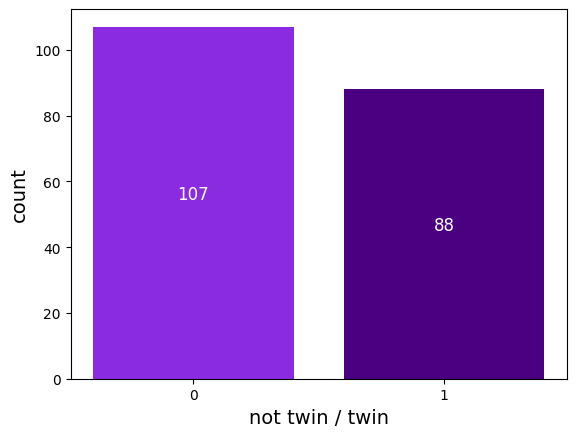

In [103]:
bar_y = df_with_y_again.iloc[only_mlp_got_right]["twin_or_not"].value_counts()
bar_x = [0, 1]
bar_colours = ["blueviolet", "indigo"]

plt.figure()
bars = plt.bar(bar_x, bar_y, color=bar_colours)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
             f'{bar.get_height():d}', ha='center', va='bottom', fontsize=12, c="white")
plt.xticks(bar_x)
plt.xlabel("not twin / twin", fontsize=14)
plt.ylabel("count", fontsize=14)
plt.show()

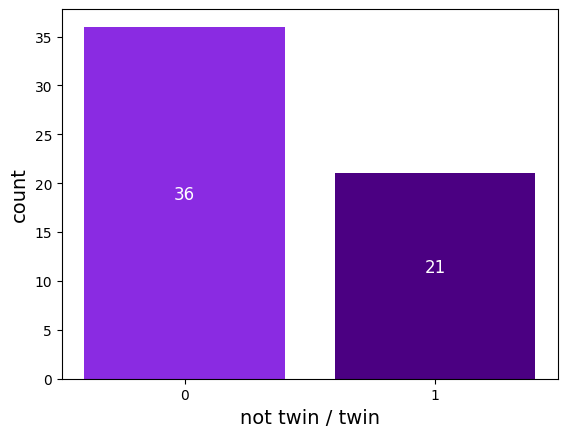

In [104]:
bar_y = df_with_y_again.iloc[only_gcn_got_right]["twin_or_not"].value_counts()
bar_x = [0, 1]
bar_colours = ["blueviolet", "indigo"]

plt.figure()
bars = plt.bar(bar_x, bar_y, color=bar_colours)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
             f'{bar.get_height():d}', ha='center', va='bottom', fontsize=12, c="white")
plt.xticks(bar_x)
plt.xlabel("not twin / twin", fontsize=14)
plt.ylabel("count", fontsize=14)
plt.show()

In [107]:
df_with_y_again.iloc[only_mlp_got_right]["set_num"].value_counts()

set_num
0     27
6     20
7     20
4     17
1     16
2     15
9     12
3     11
5     10
10     9
21     6
8      6
17     5
14     4
15     3
24     3
12     3
19     2
16     2
22     1
23     1
13     1
26     1
Name: count, dtype: int64

In [111]:
df_with_y_again.iloc[only_mlp_got_right]["set_num"].value_counts().sum()

np.int64(195)

In [112]:
27/ 195

0.13846153846153847

In [108]:
df_with_y_again.iloc[only_gcn_got_right]["set_num"].value_counts()

set_num
8     9
2     8
3     7
7     7
9     5
10    3
6     3
0     3
4     3
5     3
1     2
12    1
14    1
22    1
19    1
Name: count, dtype: int64

In [109]:
file_path_list = list(folder.glob("*/*/*/MergedGrainsData*"))

In [120]:
file_path_arr = np.array(["_".join(p.parts[-1].split("_")[1:]) for p in file_path_list])
gcn_wrong_file_names = file_path_arr[df_with_y_again.iloc[only_mlp_got_right]["set_num"].value_counts().index.tolist()]
pd.DataFrame({
    "file_name": gcn_wrong_file_names, 
    "wrong_count": df_with_y_again.iloc[only_mlp_got_right]["set_num"].value_counts().values
    })

file_name  wrong_count
0    V0_125_0083_3pct.xlsx           27
1    V0_275_1666_3pct.xlsx           20
2    V0_275_1666_7pct.xlsx           20
3    V0_225_1666_7pct.xlsx           17
4    V0_175_1666_3pct.xlsx           16
5    V0_175_1666_7pct.xlsx           15
6    V0_325_1666_7pct.xlsx           12
7    V0_225_1666_3pct.xlsx           11
8     V0_25_0083_3pct.xlsx           10
9    V0_425_1666_3pct.xlsx            9
10   V90_25_0083_7pct.xlsx            6
11   V0_325_1666_3pct.xlsx            6
12  V90_225_1666_7pct.xlsx            5
13  V90_175_0083_3pct.xlsx            4
14  V90_175_0083_7pct.xlsx            3
15  V90_325_1666_3pct.xlsx            3
16  V90_125_0083_3pct.xlsx            3
17  V90_225_0083_7pct.xlsx            2
18  V90_225_1666_3pct.xlsx            2
19  V90_275_1666_3pct.xlsx            1
20  V90_275_1666_7pct.xlsx            1
21  V90_125_0083_7pct.xlsx            1
22  V90_425_1666_3pct.xlsx            1

In [121]:
mlp_wrong_file_names = file_path_arr[df_with_y_again.iloc[only_gcn_got_right]["set_num"].value_counts().index.tolist()]
pd.DataFrame({
    "file_name": mlp_wrong_file_names, 
    "wrong_count": df_with_y_again.iloc[only_gcn_got_right]["set_num"].value_counts().values
    })

file_name  wrong_count
0    V0_325_1666_3pct.xlsx            9
1    V0_175_1666_7pct.xlsx            8
2    V0_225_1666_3pct.xlsx            7
3    V0_275_1666_7pct.xlsx            7
4    V0_325_1666_7pct.xlsx            5
5    V0_425_1666_3pct.xlsx            3
6    V0_275_1666_3pct.xlsx            3
7    V0_125_0083_3pct.xlsx            3
8    V0_225_1666_7pct.xlsx            3
9     V0_25_0083_3pct.xlsx            3
10   V0_175_1666_3pct.xlsx            2
11  V90_125_0083_3pct.xlsx            1
12  V90_175_0083_3pct.xlsx            1
13  V90_275_1666_3pct.xlsx            1
14  V90_225_0083_7pct.xlsx            1

In [143]:
df_with_y_again.iloc[only_mlp_got_right][df_with_y_again["set_num"] == 6]

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\3767476510.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_with_y_again.iloc[only_mlp_got_right][df_with_y_again["set_num"] == 6]


merged ID  original grain id       phi1         phi       phi2  \
3607          7                 16  55.475681  346.335328   3.833370   
3764        164                423  39.374825  344.708679  22.431558   
3767        167                430  38.700029    4.925406  15.207275   
3772        172                442  18.416949  321.018582  36.730476   
3811        211                519  27.529826  359.760969  27.412543   
3918        318                763  15.191964  321.827303  39.855691   
3980        380                911  52.303175  354.495653  14.884761   
3992        392                937   5.756015   13.364912  54.257757   
3999        399                953  10.949763   19.955418  50.685948   
4126        526               1234  18.835162  318.794919  35.066892   
4152        552                141  42.217150  348.932974  32.233465   
4153        553                159   6.926037  323.643148  43.726457   
4163        563                219  12.451245  316.343711  34.908130   
4180        580                301  42.809520  338.778771  26.021842   
4195        595                465  51.130621  354.721801   6.922875   
4246        646                842  28.432500    1.446979   3.050769   
4277        677               1072  22.163769  308.348175  11.090843   
4280        680               1098  47.414451  358.429243   6.525522   
4284        684               1085   8.202024  308.289194  23.144424   
4286        686               1060  37.099557    3.996863  12.914416   

      merged grain area  parent Area  daughter Area  other area  \
3607                 63           63              0           0   
3764                391          391              0           0   
3767                 97           97              0           0   
3772                148          148              0           0   
3811                 57           57              0           0   
3918                 54           54              0           0   
3980                 98           98              0           0   
3992                 70           70              0           0   
3999                 32           32              0           0   
4126                157          157              0           0   
4152                212           75            137           0   
4153                217          181             36           0   
4163                127           87             40           0   
4180               3219         1154           2065           0   
4195                236          207             29           0   
4246                407          388             19           0   
4277                182          148             34           0   
4280                175          162             13           0   
4284                236          129            107           0   
4286               1252         1041            211           0   

      no. of parent grains  ...  Rank for Var5  Rank for Var6  \
3607                     1  ...              5              6   
3764                     1  ...              6              4   
3767                     1  ...              5              6   
3772                     1  ...              5              6   
3811                     1  ...              5              3   
3918                     1  ...              4              2   
3980                     1  ...              1              4   
3992                     1  ...              5              6   
3999                     1  ...              5              6   
4126                     1  ...              4              3   
4152                     1  ...              6              5   
4153                     1  ...              2              1   
4163                     1  ...              4              3   
4180                     9  ...              5              3   
4195                     1  ...              1              2   
4246                     2  ...              

In [134]:
both_wrong_indices_for_indices = list(set(mlp_f.tolist()).intersection(set(gcn_f.tolist())))
both_wrong = test_indices_arr[both_wrong_indices_for_indices]

In [135]:
both_wrong

array([ 5050, 10443, 10448, 10450, 10460, 10465, 10479, 10500,   409,
       10507, 10505, 10515,  5517,  5519,   630,  5580,  5789, 16064,
       16077,  6082, 16082,  6105,  6112,  6134,  6150,  6165,  6172,
        6180,  6198,  6204,  1258,  1261, 11252,  6424, 11266, 11271,
        1398, 16598, 16606,  6709,  6718,  6728,  6756,  6760,  6776,
        1780,  1846,  1848,  1909,  1927,  1948,  1977, 12047, 12054,
       12071, 12084, 17451, 17471,  2399,  7576,  2428,  2448,  2495,
        2649,  2672, 12887, 12900, 12901, 18112,  2922,  2946, 18114,
       18127,  3006,  8238,  8246,  8268,  8274,  8294,  8298,  3100,
        3189,  3482,  3494, 13693,  3587, 18929, 13726, 13732, 13734,
       18936, 18953, 18969,  8976,  9012,  9026,  9034,  9055,  4125,
        4146,  4151,  4161, 14423, 14426, 14430,  4210,  4271,  4285,
        4369,  4425,  9834,  4770,  4944,  4957,  4962,  4965,  4971,
        5002, 15185, 15196,  5047, 15254])

In [136]:
both_wrong_file_names = file_path_arr[df_with_y_again.iloc[both_wrong]["set_num"].value_counts().index.tolist()]
pd.DataFrame({
    "file_name": both_wrong_file_names, 
    "wrong_count": df_with_y_again.iloc[both_wrong]["set_num"].value_counts().values
    })

file_name  wrong_count
0    V0_325_1666_7pct.xlsx           11
1   V90_175_0083_7pct.xlsx           10
2    V0_275_1666_7pct.xlsx            9
3    V0_275_1666_3pct.xlsx            7
4    V0_425_1666_3pct.xlsx            7
5    V0_175_1666_7pct.xlsx            6
6   V90_125_0083_3pct.xlsx            6
7    V0_225_1666_7pct.xlsx            5
8    V0_325_1666_3pct.xlsx            5
9    V0_225_1666_3pct.xlsx            5
10    V0_25_0083_3pct.xlsx            5
11  V90_125_0083_7pct.xlsx            5
12  V90_225_0083_7pct.xlsx            4
13  V90_425_1666_3pct.xlsx            4
14  V90_225_1666_7pct.xlsx            4
15  V90_225_1666_3pct.xlsx            3
16   V90_25_0083_3pct.xlsx            3
17   V0_175_1666_3pct.xlsx            3
18  V90_275_1666_3pct.xlsx            3
19   V90_25_0083_7pct.xlsx            3
20  V90_325_1666_7pct.xlsx            3
21  V90_225_0083_3pct.xlsx            3
22   V0_125_0083_3pct.xlsx            2
23  V90_275_1666_7pct.xlsx            2
24  V90_325_1666_3pct.xlsx            2
25   V0_425_1666_7pct.xlsx            1
26  V90_175_0083_3pct.xlsx            1

In [140]:
df_with_y_again.iloc[both_wrong]["set_num"].value_counts()

set_num
9     11
15    10
7      9
6      7
10     7
2      6
12     6
4      5
8      5
3      5
5      5
13     5
19     4
26     4
17     4
16     3
20     3
1      3
22     3
21     3
25     3
18     3
0      2
23     2
24     2
11     1
14     1
Name: count, dtype: int64

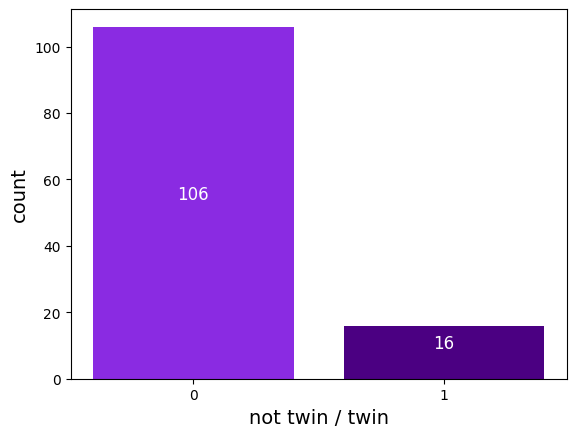

In [139]:
bar_y = df_with_y_again.iloc[both_wrong]["twin_or_not"].value_counts()
bar_x = [0, 1]
bar_colours = ["blueviolet", "indigo"]

plt.figure()
bars = plt.bar(bar_x, bar_y, color=bar_colours)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
             f'{bar.get_height():d}', ha='center', va='bottom', fontsize=12, c="white")
plt.xticks(bar_x)
plt.xlabel("not twin / twin", fontsize=14)
plt.ylabel("count", fontsize=14)
plt.show()

In [141]:
df_with_y_again.iloc[both_wrong][df_with_y_again["set_num"] == 9]

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\2505358332.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_with_y_again.iloc[both_wrong][df_with_y_again["set_num"] == 9]


merged ID  original grain id       phi1         phi       phi2  \
5789        145                421  21.493375  336.179140  44.441888   
6082        438                222  27.312808  316.913179  23.870763   
6105        461                325  14.835622  327.762344  44.213081   
6112        468                361  48.132226  340.714945  19.537067   
6134        490                496   5.222317  313.488180  33.047275   
6150        506                594  46.379806  342.033012  22.399574   
6165        521                695  18.551084    2.458167  14.797086   
6172        528                758  31.727560  336.919045  41.684184   
6180        536                799   8.355522  315.874130  34.868970   
6198        554                874  36.338893    0.759024   4.831754   
6204        560                921  46.767278  346.282248  30.034808   

      merged grain area  parent Area  daughter Area  other area  \
5789               2095         2095              0           0   
6082                377          352             25           0   
6105                546          266            280           0   
6112                 89           79             10           0   
6134                142           64             78           0   
6150                 62           31             31           0   
6165                177           58             90           0   
6172                132          115             17           0   
6180                 52           39             13           0   
6198                225          140             85           0   
6204                 46           25             21           0   

      no. of parent grains  ...  Rank for Var5  Rank for Var6  \
5789                     1  ...              5              6   
6082                     1  ...              1              2   
6105                     2  ...              3              1   
6112                     1  ...              4              3   
6134                     1  ...              4              3   
6150                     1  ...              5              3   
6165                     1  ...              5              6   
6172                     2  ...              4              6   
6180                     1  ...              2              1   
6198                     1  ...              3              4   
6204                     1  ...              6              4   

      neighbor grains count                        neighbor grain ids  \
5789                     10    92,120,153,157,186,446,459,464,471,474   
6082                      8               69,75,85,86,441,442,447,452   
6105                     11  87,89,95,101,102,116,125,130,454,475,477   
6112                      6                   115,122,128,470,472,481   
6134                      6                   156,158,167,172,198,499   
6150                      5                       195,204,223,502,511   
6165                      6                   227,253,254,266,514,520   
6172                      6                   249,264,277,536,541,561   
6180                      5                       264,277,290,528,541   
6198                      6                   293,300,303,543,551,587   
6204                      6                   311,320,332,555,563,579   

      percent  temperature  speed  direction  set_num  twin_or_not  
5789        7          325      1          0        9            0  
6082        7          325      1          0        9            1  
6105        7          325      1          0        9            1  
6112        7          325      1          0        9            1  
6134        7          325      1          0        9            1  
6150        7          325      1          0        9            1  
6165        7          325      1          0        9            1  
6172        7          325      1          0        9            1  
6180        7          325      1          0        9    

In [144]:
df_with_y_again.iloc[only_mlp_got_right]

merged ID  original grain id       phi1         phi       phi2  \
5078          48                 96  38.946765  341.612387  32.864185   
20            21                 68  25.738989  340.820804  46.377058   
5102          72                136  27.407944  339.788286  44.473190   
39            40                130  26.945316   10.288850  20.015697   
55            56                190  44.263149  332.250381  15.586187   
...          ...                ...        ...         ...        ...   
5007         703               1456   4.967168  328.975805  47.537274   
5019         715               1496  56.893544  353.814662   1.683632   
15200        710                477  52.252208  340.049560  11.079468   
15206        716                496  45.204426  328.026948  14.663868   
15223        733                711   8.522937   25.820689  46.627534   

       merged grain area  parent Area  daughter Area  other area  \
5078                  11           11              0           0   
20                   342          342              0           0   
5102                 316          316              0           0   
39                    43           43              0           0   
55                    12           12              0           0   
...                  ...          ...            ...         ...   
5007                 786          604            182           0   
5019                 857          562            276           0   
15200               3010         2816            114          80   
15206                333          143            190           0   
15223                485          443             42           0   

       no. of parent grains  ...  Rank for Var5  Rank for Var6  \
5078                      1  ...              6              3   
20                        1  ...              5              6   
5102                      1  ...              5              6   
39                        1  ...              3              4   
55                        1  ...              4              3   
...                     ...  ...            ...            ...   
5007                      1  ...              6              5   
5019                      2  ...              5              6   
15200                     1  ...              6              5   
15206                     1  ...              2              1   
15223                     1  ...              4              6   

       neighbor grains count  \
5078                       4   
20                         5   
5102                      11   
39                         7   
55                         4   
...                      ...   
5007                      17   
5019                      14   
15200                     14   
15206                      4   
15223                      5   

                                      neighbor grain ids  percent  \
5078                                        44,52,72,487        3   
20                                      44,48,66,458,481        3   
5102               46,48,49,52,59,78,112,487,496,501,513        3   
39                              31,42,49,469,480,485,486        3   
55                                        53,102,487,492        3   
...                                                  ...      ...   
5007   393,402,404,407,416,418,420,429,431,435,440,44...        7   
5019   392,409,447,448,449,450,678,685,686,696,702,70...        7   
15200  281,282,283,293,299,310,312,328,331,343,703,70...        7   
15206                                    318,327,341,729        7   
15223                                419,421,435,734,738        7   

       temperature  speed  direction  set_num  twin_or_not  
5078           325      1          0        8            0  
20             125      0          0        0            0  
5102           325      1          0        8            0  
39             125      0          0        0            0  
5

merged ID  original grain id        phi1         phi       phi2  \
1             2                  2   48.614823  347.530536  19.772951   
3             4                  7   44.155840  351.273455  10.917894   
4             5                 10   18.402519  309.171717  18.854361   
5             6                 15    5.647723    0.121668  17.860995   
6             7                 23   31.807847  354.811231  34.295149   
...         ...                ...         ...         ...        ...   
1897        494                943   57.097792  356.272236   2.219462   
1898        495                944   15.217110  348.279668  39.206742   
1899        496                948   24.661150  335.791123  35.306379   
1901        498                983  359.159887  356.811684  57.200168   
1902        499                989   57.029384  356.822140   4.361501   

      merged grain area  parent Area  daughter Area  other area  \
1                    18           18              0           0   
3                    14           14              0           0   
4                    30           30              0           0   
5                    54           54              0           0   
6                   113          113              0           0   
...                 ...          ...            ...         ...   
1897                188           89             99           0   
1898                162          152             10           0   
1899                412          363             11          38   
1901                326          265             61           0   
1902                286          196             73           0   

      no. of parent grains  ...  neighbor grains count  \
1                        1  ...                      3   
3                        1  ...                      2   
4                        1  ...                      2   
5                        1  ...                      4   
6                        1  ...                      4   
...                    ...  ...                    ...   
1897                     1  ...                      6   
1898                     1  ...                      7   
1899                     1  ...                     10   
1901                     1  ...                      6   
1902                     1  ...                      6   

                           neighbor grain ids  percent  temperature  speed  \
1                                 457,462,552        3          125      0   
3                                     461,463        3          125      0   
4                                     458,481        3          125      0   
5                                11,15,34,466        3          125      0   
6                              16,459,464,479        3          125      0   
...                                       ...      ...          ...    ...   
1897                  219,225,242,483,490,515        7          175      1   
1898              222,223,230,488,500,501,530        7          175      1   
1899  214,221,227,237,242,244,253,481,486,502        7          175      1   
1901                  241,254,267,492,506,513        7          175      1   
1902                  252,491,493,511,515,520        7          175      1   

      direction  set_num  twin_or_not  gcn_result  mlp_result  
1             0        0            0       right       right  
3             0        0            0       right       right  
4             0        0            0       right       right  
5             0        0            0       right       right  
6             0        0            0       right       right  
...         ...      ...          ...         ...         ...  
1897          0        2            1       right       right  
1898          0        2            1       right       right  
1899          0        2            1       right       right  
1901          0        2            1       right 

In [187]:
df[data.test_mask.numpy()]

merged ID  original grain id       phi1         phi       phi2  \
5              6                 15   5.647723    0.121668  17.860995   
20            21                 68  25.738989  340.820804  46.377058   
32            33                111   8.477407  322.794289  42.719571   
39            40                130  26.945316   10.288850  20.015697   
55            56                190  44.263149  332.250381  15.586187   
...          ...                ...        ...         ...        ...   
19822        851                883  41.122353  354.664699  10.726491   
19826        855                887  39.171782  358.232378   4.672034   
19847        876                908  13.258153  313.488069  30.673047   
19863        892                924  13.175674  310.480569  25.632565   
19878        907                939  36.447463  358.999137   3.334605   

       merged grain area  parent Area  daughter Area  other area  \
5                     54           54              0           0   
20                   342          342              0           0   
32                    27           27              0           0   
39                    43           43              0           0   
55                    12           12              0           0   
...                  ...          ...            ...         ...   
19822                 77           77              0           0   
19826                192          192              0           0   
19847               1641         1641              0           0   
19863                 26           26              0           0   
19878                740          740              0           0   

       no. of parent grains  ...  Rank for Var4  Rank for Var5  Rank for Var6  \
5                         1  ...              3              6              5   
20                        1  ...              1              5              6   
32                        1  ...              4              2              1   
39                        1  ...              1              3              4   
55                        1  ...              1              4              3   
...                     ...  ...            ...            ...            ...   
19822                     1  ...              2              5              6   
19826                     1  ...              2              3              6   
19847                     1  ...              2              6              5   
19863                     1  ...              4              6              5   
19878                     1  ...              1              3              6   

       neighbor grains count                           neighbor grain ids  \
5                          4                                 11,15,34,466   
20                         5                             44,48,66,458,481   
32                         4                               28,466,478,539   
39                         7                     31,42,49,469,480,485,486   
55                         4                               53,102,487,492   
...                      ...                                          ...   
19822                      5                          831,853,867,869,888   
19826                      4                              858,871,896,897   
19847                     11  804,807,810,813,823,828,844,874,875,877,878   
19863                      2                                      891,893   
19878                      7                  827,836,848,866,905,906,908   

       percent  temperature  speed  direction  set_num  
5            3          125      0          0        0  
20           3          125      0          0        0  
32           3          125      0          0        0  
39           3          125      0          0        0  
55           3          125      0          0        0  
...        ...          ...    ...        ...      ...  
19822        7  

In [209]:
gcn_result = pd.Series(["NA"] * df.shape[0], name="gcn_result")
mlp_result = pd.Series(["NA"] * df.shape[0], name="mlp_result")

df_whole_data = pd.concat([df_with_y_again, gcn_result, mlp_result], axis=1)

# only test data
df_whole_data.loc[data.test_mask.numpy(), "gcn_result"] = "right"
df_whole_data.loc[data.test_mask.numpy(), "mlp_result"] = "right"

df_whole_data.loc[test_indices_arr[list(set(gcn_f.tolist()))], "gcn_result"] = "wrong"
df_whole_data.loc[test_indices_arr[list(set(mlp_f.tolist()))], "mlp_result"] = "wrong"

In [210]:
df_whole_data.loc[test_indices_arr[list(set(mlp_f.tolist()))], "mlp_result"].map(lambda x: x != "wrong").sum()

np.int64(0)

In [211]:
df_whole_data.loc[test_indices_arr[list(set(gcn_f.tolist()))], "gcn_result"].map(lambda x: x != "wrong").sum()

np.int64(0)

In [214]:
right_cond = df_whole_data[["major axis", "gcn_result"]]["gcn_result"] == "right"
df_whole_data[["major axis", "gcn_result"]][right_cond]

major axis gcn_result
5       11.958639      right
32       8.682339      right
97      24.246085      right
98       5.502293      right
177     10.605479      right
...           ...        ...
19822   10.998456      right
19826   20.609475      right
19847   61.907339      right
19863    7.806896      right
19878   40.256994      right

[1673 rows x 2 columns]

In [215]:
df_whole_data["gcn_result"].value_counts()

gcn_result
NA       17905
right     1673
wrong      317
Name: count, dtype: int64

In [217]:
hue = "gcn_result"

df_whole_data[df_whole_data[hue] != "NA"][["major axis", hue]]

major axis gcn_result
5       11.958639      right
20      24.739526      wrong
32       8.682339      right
39       9.345816      wrong
55       4.528606      wrong
...           ...        ...
19822   10.998456      right
19826   20.609475      right
19847   61.907339      right
19863    7.806896      right
19878   40.256994      right

[1990 rows x 2 columns]

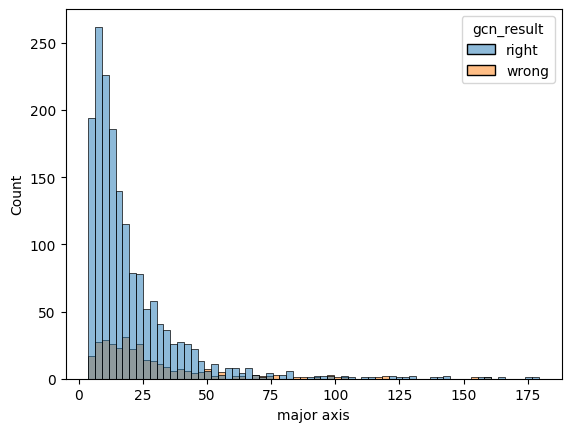

In [223]:
plt.figure()
hue = "gcn_result"
sns_data = df_whole_data[df_whole_data[hue] != "NA"][["major axis", hue]]
sns.histplot(data=sns_data, x="major axis", hue=hue, stat="count")
plt.show()

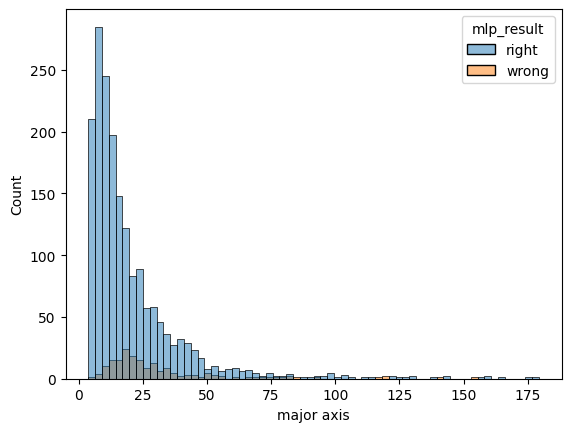

In [224]:
plt.figure()
hue = "mlp_result"
sns_data = df_whole_data[df_whole_data[hue] != "NA"][["major axis", hue]]
sns.histplot(data=sns_data, x="major axis", hue=hue, stat="count")
plt.show()

In [ ]:
# statistical difference between two groups
# 1. both got right 2. only gcn wrong


In [513]:
df_test_only = df_whole_data.loc[data.test_mask.numpy()]
df_train_only = df_whole_data[data.train_mask.numpy()]

In [248]:
cond_gcn_right = df_test_only["gcn_result"] == "right"
cond_mlp_right = df_test_only["mlp_result"] == "right"

both_right_count = int((cond_gcn_right.astype(int) + cond_mlp_right.astype(int)).value_counts()[2])

df_both_right = df_test_only[cond_gcn_right & cond_mlp_right]
assert df_both_right.shape[0] == both_right_count

df_only_gcn_wrong = df_test_only[~cond_gcn_right & cond_mlp_right]
assert df_only_gcn_wrong.shape[0] == 195

In [251]:
df_only_gcn_wrong[FEATURE_COLS].describe()

phi1         phi        phi2  merged grain area  major axis  \
count  195.000000  195.000000  195.000000         195.000000  195.000000   
mean    28.231760  281.416611   27.488017         495.748718   25.535685   
std     15.175400  125.916025   15.498381        1002.348502   22.883567   
min      2.172034    0.206117    1.683632          10.000000    3.983038   
25%     15.024550  314.713416   13.525300          45.500000    9.779586   
50%     28.399905  333.950456   26.534495         175.000000   19.642061   
75%     40.517317  348.412098   40.438972         450.500000   31.278784   
max     56.893544  359.760969   56.694707        7407.000000  159.211116   

       aspect ratio  total boundary length         GOS         GAM  \
count    195.000000             195.000000  195.000000  195.000000   
mean       1.843204             117.046154    1.338756    0.782860   
std        0.732656             130.061218    1.274815    0.308184   
min        1.032286              18.000000    0.104807    0.222790   
25%        1.366065              39.000000    0.459629    0.557831   
50%        1.653906              78.000000    0.891880    0.723906   
75%        2.036272             132.500000    1.858390    0.948466   
max        5.745296             875.000000    8.890322    2.390908   

       Schmid SF1  ...  Schmid for Var1  Schmid for Var2  Schmid for Var3  \
count  195.000000  ...       195.000000       195.000000       195.000000   
mean     0.275093  ...        -0.003493        -0.003800        -0.036259   
std      0.151741  ...         0.269634         0.266578         0.297053   
min      0.001684  ...        -0.495013        -0.497541        -0.498144   
25%      0.153583  ...        -0.223109        -0.209149        -0.312575   
50%      0.286647  ...        -0.005091        -0.010845        -0.014550   
75%      0.421164  ...         0.190003         0.203352         0.205574   
max      0.497235  ...         0.494561         0.499905         0.499020   

       Schmid for Var4  Schmid for Var5  Schmid for Var6     percent  \
count       195.000000       195.000000       195.000000  195.000000   
mean         -0.036953        -0.038510        -0.037509    4.682051   
std           0.296723         0.259699         0.263706    1.979648   
min          -0.499807        -0.476339        -0.491739    3.000000   
25%          -0.309410        -0.241141        -0.225651    3.000000   
50%          -0.019439        -0.053899        -0.053789    3.000000   
75%           0.197277         0.104419         0.116558    7.000000   
max           0.496885         0.499385         0.496176    7.000000   

       temperature       speed   direction  
count   195.000000  195.000000  195.000000  
mean    214.743590    0.712821   14.769231  
std      94.691229    0.453611   33.418975  
min      25.000000    0.000000    0.000000  
25%     175.000000    0.000000    0.000000  
50%     225.000000    1.000000    0.000000  
75%     275.000000    1.000000    0.000000  
max     425.000000    1.000000   90.000000  

[8 rows x 31 columns]

In [252]:
df_both_right[FEATURE_COLS].describe()

phi1          phi         phi2  merged grain area   major axis  \
count  1616.000000  1616.000000  1616.000000        1616.000000  1616.000000   
mean     28.202094   285.833963    28.426472         288.668936    19.599151   
std      26.767562   123.064624    24.059452         805.200441    19.189467   
min       0.048926     0.026795     0.129533          10.000000     3.754717   
25%      11.288036   312.918896    11.699695          29.000000     8.467764   
50%      23.708694   339.048632    25.236292          76.000000    13.377787   
75%      44.346379   351.816292    44.547960         238.000000    23.683515   
max     359.914579   359.995988   359.432667       10391.000000   179.459525   

       aspect ratio  total boundary length          GOS          GAM  \
count   1616.000000            1616.000000  1616.000000  1616.000000   
mean       2.091425              79.063119     1.202430     0.883268   
std        1.212778              97.216861     1.099715     0.539958   
min        1.024631              15.000000     0.070525     0.163840   
25%        1.428990              31.000000     0.461343     0.509489   
50%        1.750271              51.000000     0.831971     0.751415   
75%        2.280615              90.000000     1.502253     1.074965   
max       20.813044            1367.000000     7.520485     4.340393   

        Schmid SF1  ...  Schmid for Var1  Schmid for Var2  Schmid for Var3  \
count  1616.000000  ...      1616.000000      1616.000000      1616.000000   
mean      0.342024  ...         0.221657         0.221017         0.209349   
std       0.126166  ...         0.238164         0.238827         0.256210   
min       0.001220  ...        -0.491262        -0.492837        -0.499918   
25%       0.250512  ...         0.091655         0.082510         0.072319   
50%       0.377617  ...         0.288985         0.292715         0.287448   
75%       0.447387  ...         0.411112         0.409658         0.413123   
max       0.499848  ...         0.499740         0.499234         0.499750   

       Schmid for Var4  Schmid for Var5  Schmid for Var6     percent  \
count      1616.000000      1616.000000      1616.000000  1616.00000   
mean          0.208758         0.157024         0.158254     4.84901   
std           0.255209         0.248760         0.248316     1.99491   
min          -0.498974        -0.497236        -0.490940     3.00000   
25%           0.073346        -0.022052        -0.021922     3.00000   
50%           0.285297         0.206454         0.205446     3.00000   
75%           0.409049         0.370989         0.375099     7.00000   
max           0.499426         0.499785         0.499955     7.00000   

       temperature        speed    direction  
count  1616.000000  1616.000000  1616.000000  
mean    239.449257     0.610149    64.158416  
std     116.356210     0.487867    40.730599  
min      25.000000     0.000000     0.000000  
25%     175.000000     0.000000     0.000000  
50%     225.000000     1.000000    90.000000  
75%     325.000000     1.000000    90.000000  
max     425.000000     1.000000    90.000000  

[8 rows x 31 columns]

In [275]:
df_both_right.loc[:, "analysis_1"] = "both right"
df_only_gcn_wrong.loc[:, "analysis_1"] = "only gcn wrong"

df_both_right_sampled = df_both_right.sample(df_only_gcn_wrong.shape[0])
df_1 = pd.concat([df_both_right_sampled, df_only_gcn_wrong])
df_1

merged ID  original grain id       phi1         phi       phi2  \
3386         342                743  25.013577  339.247563  33.346603   
11924        632                903   5.552408    4.590003  55.891633   
10584         64                 76   6.621302  346.909847  51.041218   
12442        330                429  54.553462  353.485251  14.979376   
10834        314                412  43.009031  338.197215  14.460526   
...          ...                ...        ...         ...        ...   
16590        505                192  38.527122  327.305060  26.534495   
17439        822                298  25.913967  329.656889  39.118657   
17452        835                550  31.407294  314.286901  12.951540   
17453        836                552  45.706970  335.059713  21.128272   
18958        789                645  30.356023    4.758644  34.833031   

       merged grain area  parent Area  daughter Area  other area  \
3386                 139          139              0           0   
11924                 33           33              0           0   
10584                 31           31              0           0   
12442                 34           34              0           0   
10834                 95           95              0           0   
...                  ...          ...            ...         ...   
16590                488          476             12           0   
17439               1979         1739            240           0   
17452               1229         1122             77          30   
17453               1069         1012             57           0   
18958                300          188            112           0   

       no. of parent grains  ...  \
3386                      1  ...   
11924                     1  ...   
10584                     1  ...   
12442                     1  ...   
10834                     1  ...   
...                     ...  ...   
16590                     1  ...   
17439                     1  ...   
17452                     2  ...   
17453                     1  ...   
18958                     2  ...   

                                      neighbor grain ids  percent  \
3386                                             357,545        3   
11924                                        638,814,816        7   
10584                                        51,69,70,81        3   
12442                                    322,328,339,352        3   
10834                                        389,731,732        3   
...                                                  ...      ...   
16590                        133,153,154,168,177,502,509        7   
17439            168,173,184,192,257,275,283,814,816,830        3   
17452  294,298,320,323,338,339,347,353,355,359,361,36...        3   
17453                    365,374,402,413,432,446,830,845        3   
18958                        531,546,553,560,673,788,792        3   

       temperature  speed  direction  set_num  twin_or_not  gcn_result  \
3386            25      0          0        5            0       right   
11924          225      1         90       17            0       right   
10584          225      1         90       16            0       right   
12442          225      0         90       18            0       right   
10834          225      1         90       16            0       right   
...            ...    ...        ...      ...          ...         ...   
16590          275      1         90       23            1       wrong   
17439          325      1         90       24            1       wrong   
17452          325      1         90       24            1       wrong   
17453          325      1         90       24            1       wrong   
18958          425      1         90       26            1       wrong   

       mlp_result      analysis_1  
3386        right      both right  
11924       right      both right  
10584       right      both right  
12442       right 

In [282]:
df_both_right_sampled

merged ID  original grain id       phi1         phi       phi2  \
3386         342                743  25.013577  339.247563  33.346603   
11924        632                903   5.552408    4.590003  55.891633   
10584         64                 76   6.621302  346.909847  51.041218   
12442        330                429  54.553462  353.485251  14.979376   
10834        314                412  43.009031  338.197215  14.460526   
...          ...                ...        ...         ...        ...   
18517        348                417   7.121537  317.150661  37.358820   
16750        133                162  53.116771  355.608854  14.984852   
2390         439                155  13.685183  326.283492  43.990938   
1717         314               1174   4.890544   15.827774  53.839732   
5846         202                586  33.552656    0.197123  32.047420   

       merged grain area  parent Area  daughter Area  other area  \
3386                 139          139              0           0   
11924                 33           33              0           0   
10584                 31           31              0           0   
12442                 34           34              0           0   
10834                 95           95              0           0   
...                  ...          ...            ...         ...   
18517                 22           22              0           0   
16750                194          194              0           0   
2390                6873         6760             61          52   
1717                 132          132              0           0   
5846                  52           52              0           0   

       no. of parent grains  ...  \
3386                      1  ...   
11924                     1  ...   
10584                     1  ...   
12442                     1  ...   
10834                     1  ...   
...                     ...  ...   
18517                     1  ...   
16750                     1  ...   
2390                      1  ...   
1717                      1  ...   
5846                      1  ...   

                                      neighbor grain ids  percent  \
3386                                             357,545        3   
11924                                        638,814,816        7   
10584                                        51,69,70,81        3   
12442                                    322,328,339,352        3   
10834                                        389,731,732        3   
...                                                  ...      ...   
18517                                331,337,349,356,452        3   
16750                            135,136,141,142,143,810        3   
2390   9,11,12,26,33,34,69,77,90,431,444,446,452,454,456        3   
1717                                     303,306,307,327        7   
5846                                         197,198,217        7   

       temperature  speed  direction  set_num  twin_or_not  gcn_result  \
3386            25      0          0        5            0       right   
11924          225      1         90       17            0       right   
10584          225      1         90       16            0       right   
12442          225      0         90       18            0       right   
10834          225      1         90       16            0       right   
...            ...    ...        ...      ...          ...         ...   
18517          425      1         90       26            0       right   
16750          325      1         90       24            0       right   
2390           225      1          0        3            1       right   
1717           175      1          0        2            0       right   
5846           325      1          0        9            0       right   

       mlp_result  analysis_1  
3386        right  both right  
11924       right  both right  
10584       right  both right  
12442       right  both right  
10

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\960289893.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


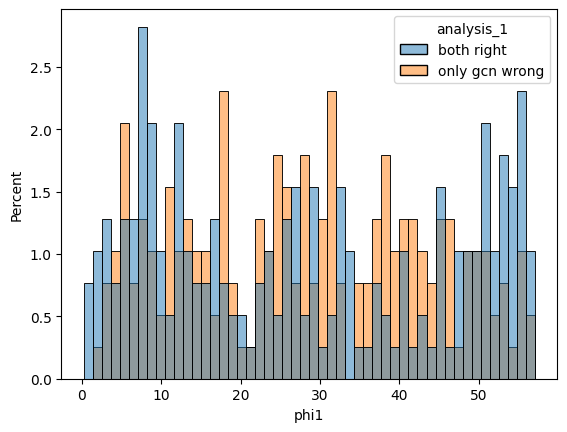

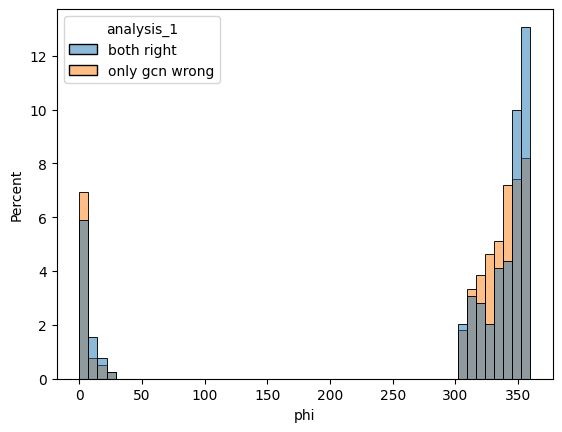

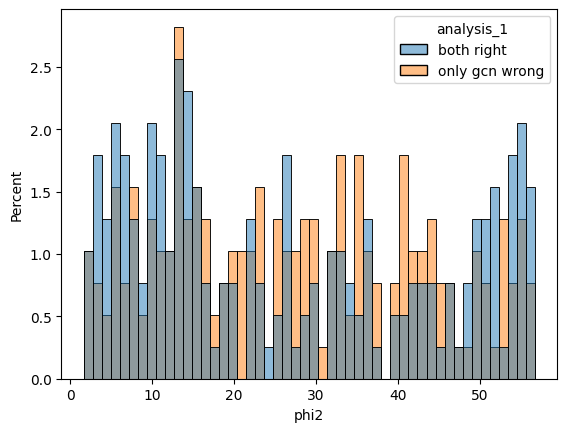

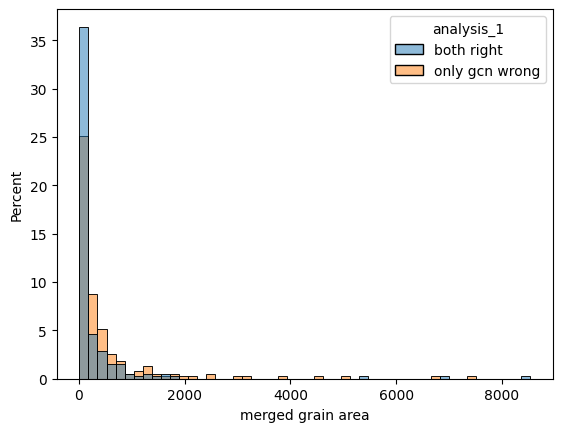

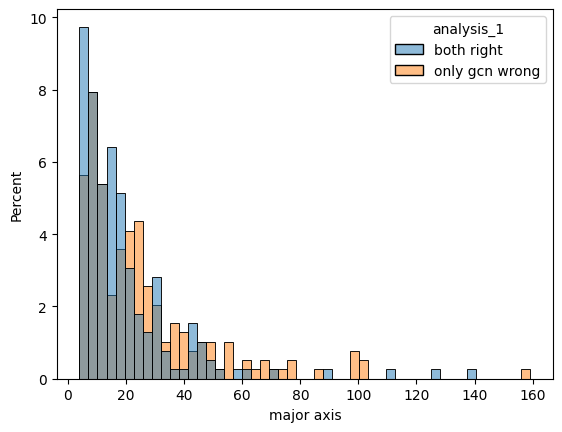

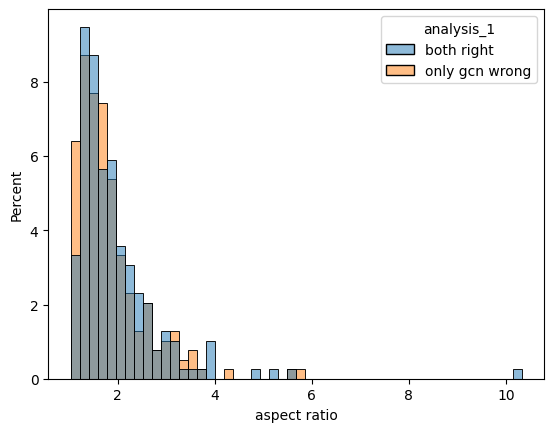

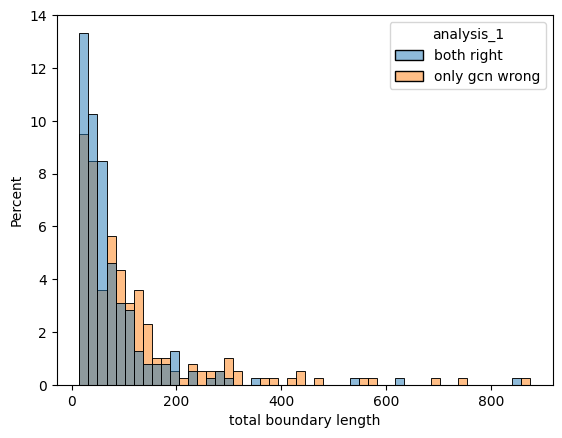

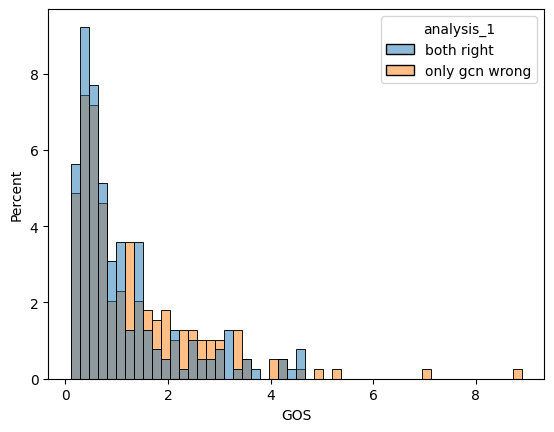

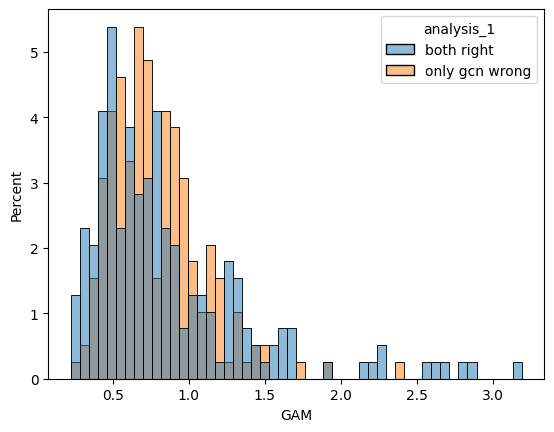

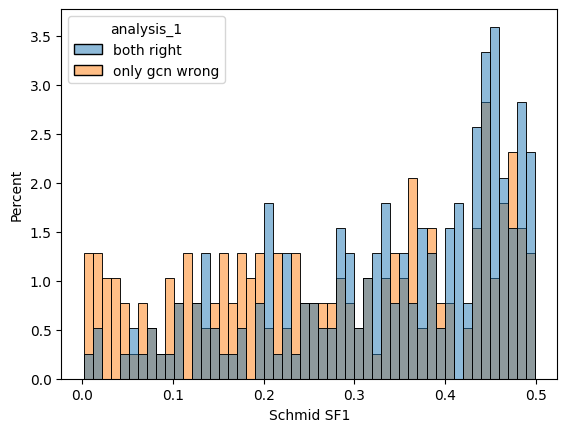

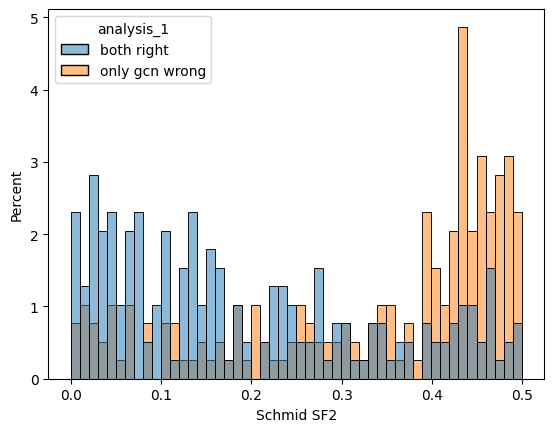

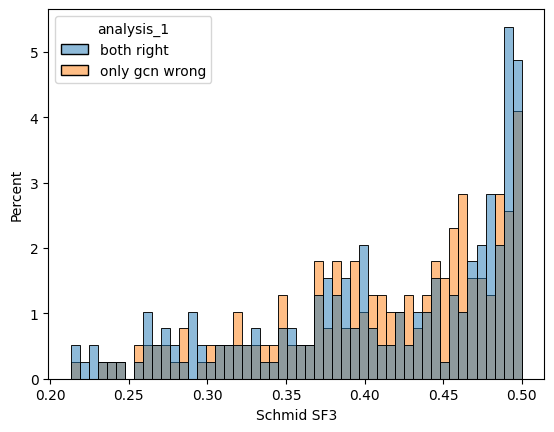

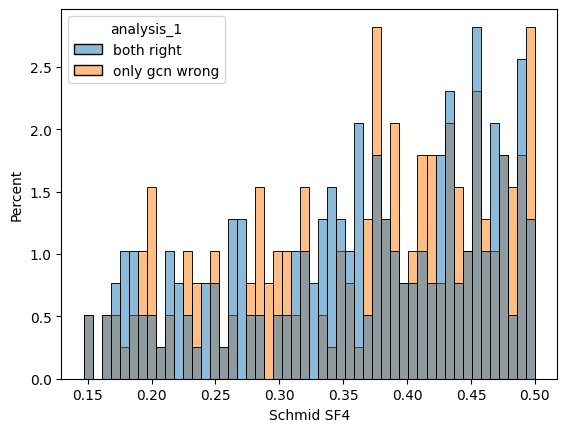

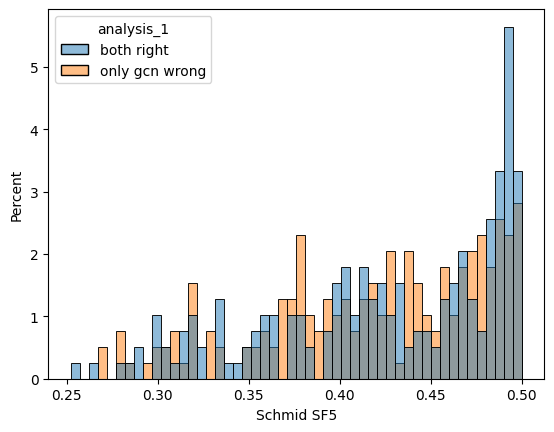

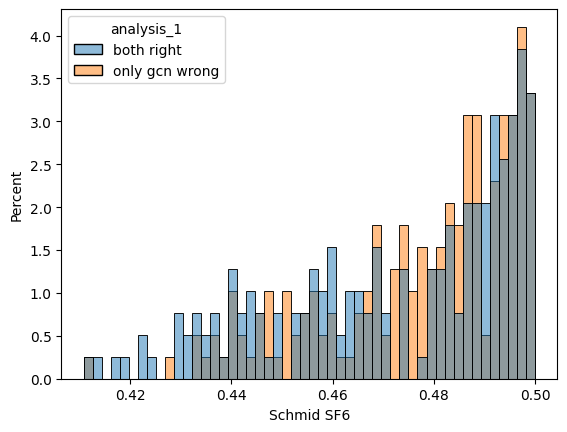

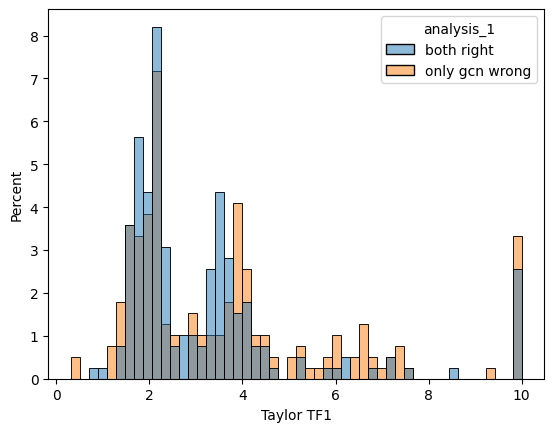

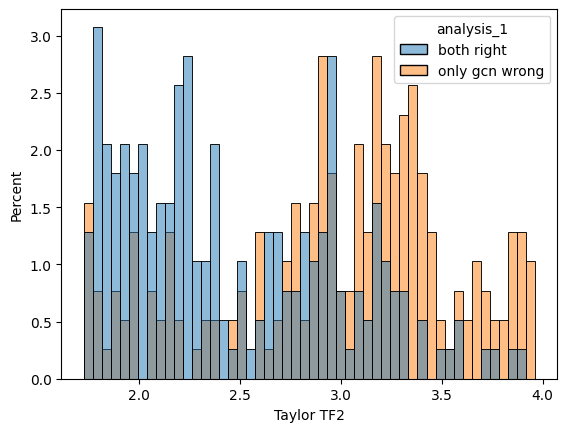

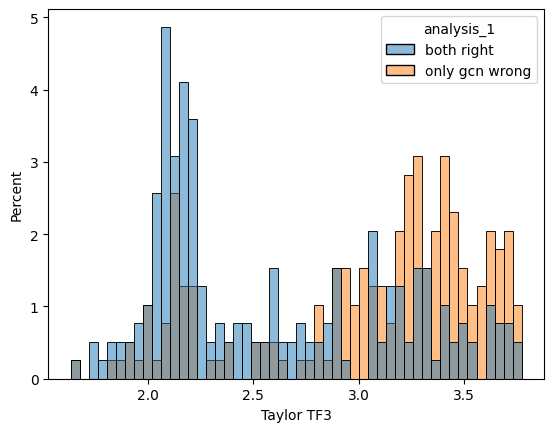

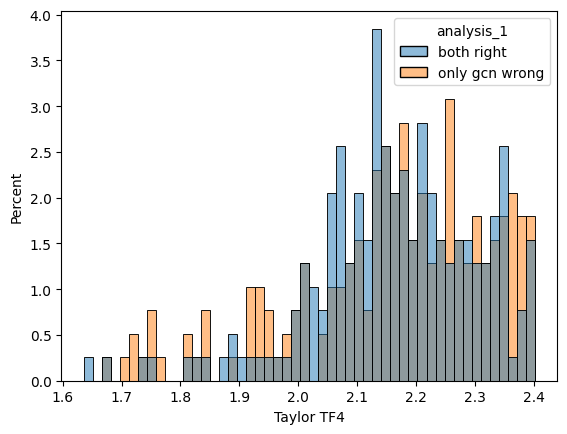

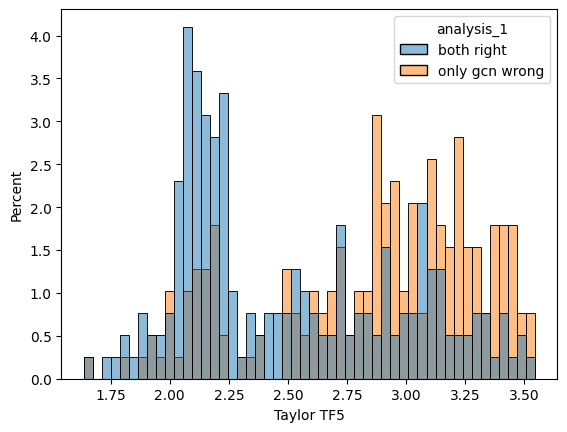

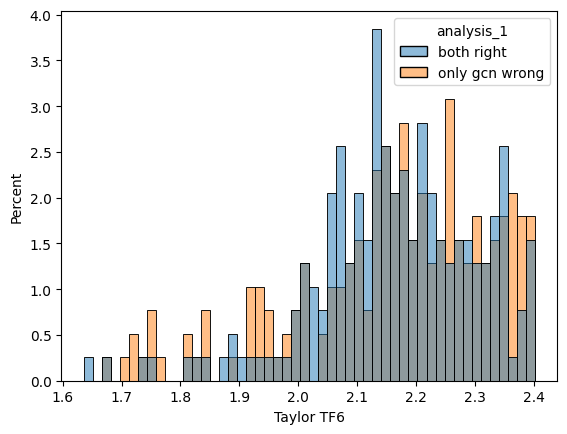

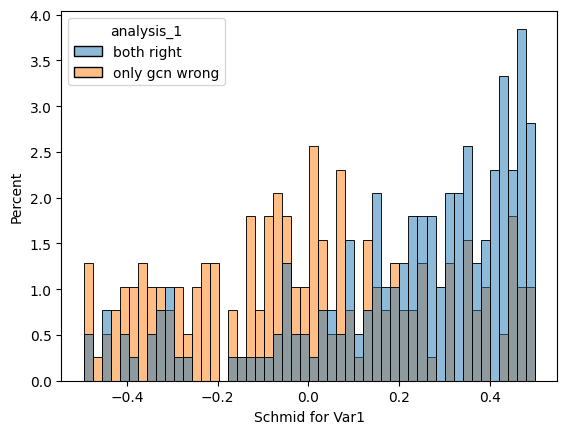

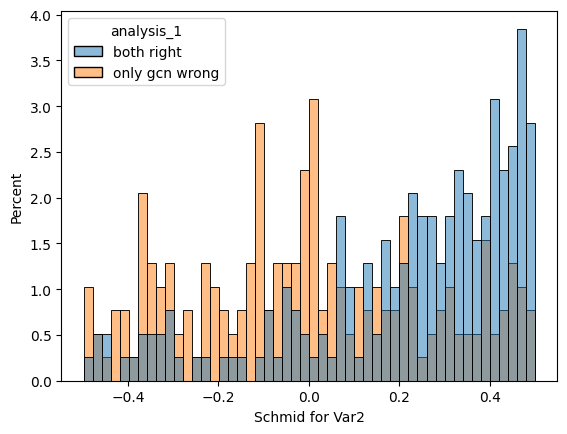

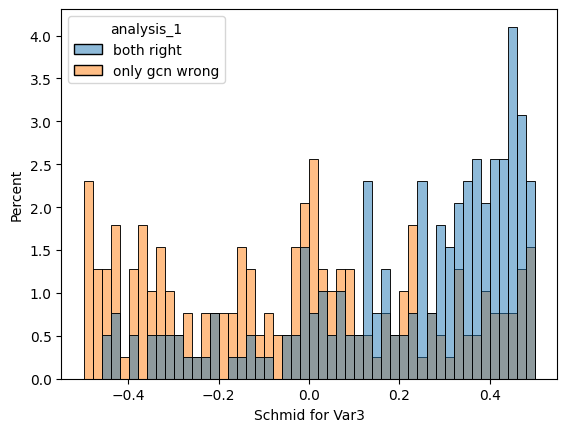

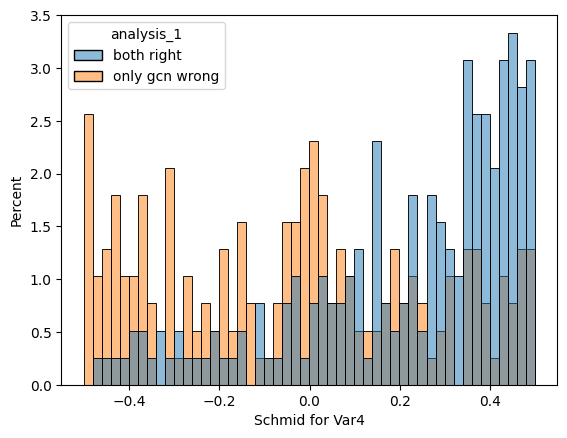

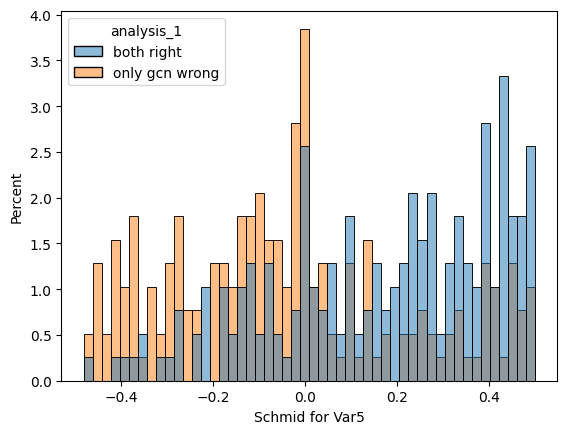

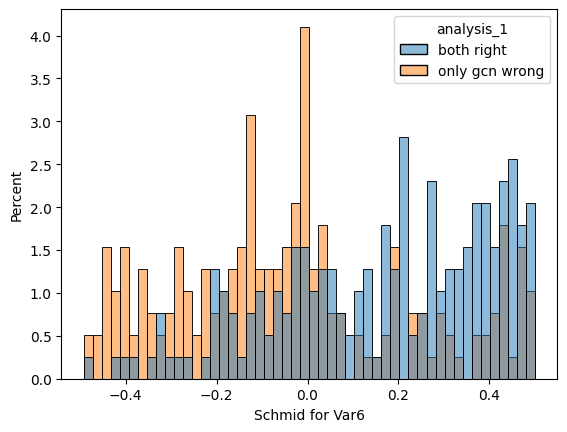

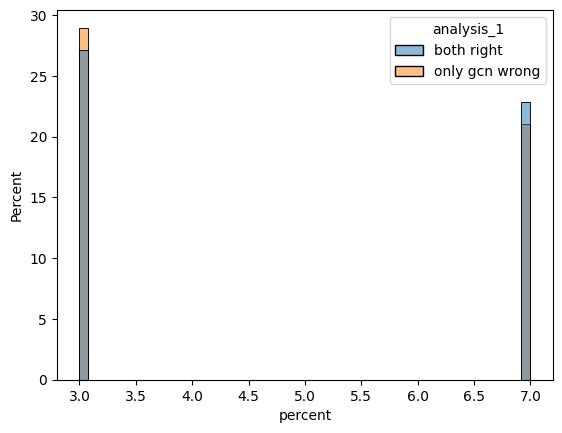

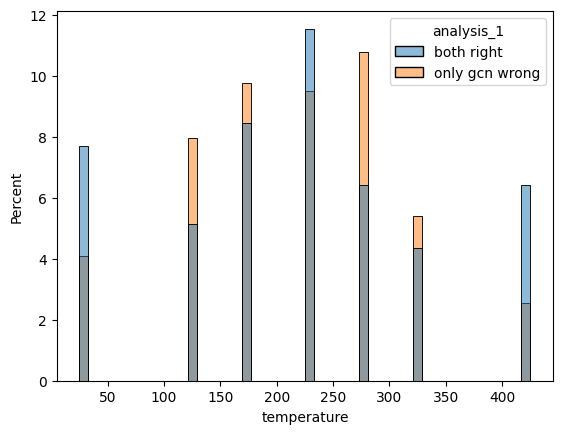

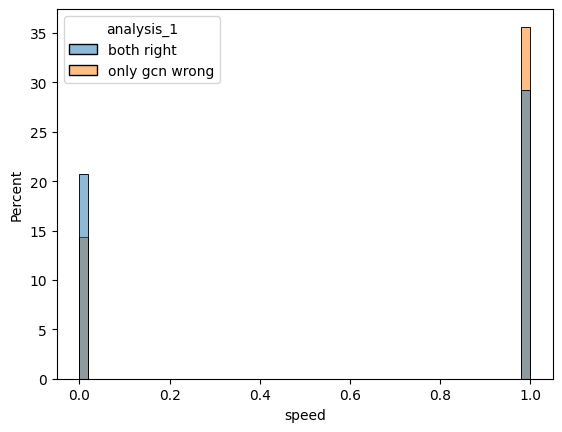

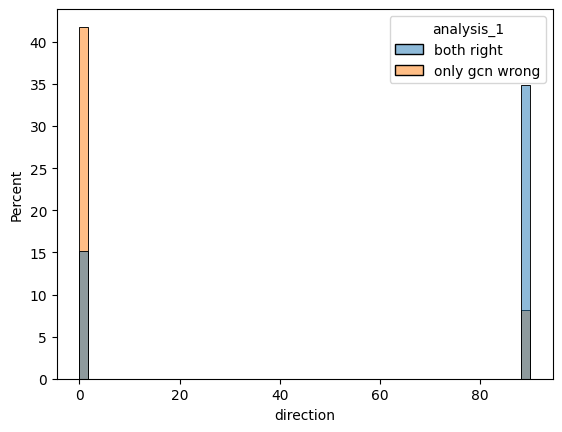

In [310]:
hue = "analysis_1"

for col in FEATURE_COLS:
    plt.figure()
    sns.histplot(data=df_1, x=col, hue=hue, multiple="layer", bins=50, stat="percent")
    plt.savefig(f"analysis_1_{col}.png")

In [311]:
df_2 = pd.concat([df_both_right, df_only_gcn_wrong])
df_2

merged ID  original grain id       phi1         phi       phi2  \
5              6                 15   5.647723    0.121668  17.860995   
32            33                111   8.477407  322.794289  42.719571   
98            99                331   7.389812  306.667009  19.496556   
177          178                615  35.515692  325.047335  27.762558   
184          185                644   8.895618  345.197913  47.864597   
...          ...                ...        ...         ...        ...   
16590        505                192  38.527122  327.305060  26.534495   
17439        822                298  25.913967  329.656889  39.118657   
17452        835                550  31.407294  314.286901  12.951540   
17453        836                552  45.706970  335.059713  21.128272   
18958        789                645  30.356023    4.758644  34.833031   

       merged grain area  parent Area  daughter Area  other area  \
5                     54           54              0           0   
32                    27           27              0           0   
98                    15           15              0           0   
177                   30           30              0           0   
184                   19           19              0           0   
...                  ...          ...            ...         ...   
16590                488          476             12           0   
17439               1979         1739            240           0   
17452               1229         1122             77          30   
17453               1069         1012             57           0   
18958                300          188            112           0   

       no. of parent grains  ...  \
5                         1  ...   
32                        1  ...   
98                        1  ...   
177                       1  ...   
184                       1  ...   
...                     ...  ...   
16590                     1  ...   
17439                     1  ...   
17452                     2  ...   
17453                     1  ...   
18958                     2  ...   

                                      neighbor grain ids  percent  \
5                                           11,15,34,466        3   
32                                        28,466,478,539        3   
98                                                89,111        3   
177                                              183,202        3   
184                                          194,552,562        3   
...                                                  ...      ...   
16590                        133,153,154,168,177,502,509        7   
17439            168,173,184,192,257,275,283,814,816,830        3   
17452  294,298,320,323,338,339,347,353,355,359,361,36...        3   
17453                    365,374,402,413,432,446,830,845        3   
18958                        531,546,553,560,673,788,792        3   

       temperature  speed  direction  set_num  twin_or_not  gcn_result  \
5              125      0          0        0            0       right   
32             125      0          0        0            0       right   
98             125      0          0        0            0       right   
177            125      0          0        0            0       right   
184            125      0          0        0            0       right   
...            ...    ...        ...      ...          ...         ...   
16590          275      1         90       23            1       wrong   
17439          325      1         90       24            1       wrong   
17452          325      1         90       24            1       wrong   
17453          325      1         90       24            1       wrong   
18958          425      1         90       26            1       wrong   

       mlp_result      analysis_1  
5           right      both right  
32          right      both right  
98          right      both right  
177         right 

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\3464522173.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


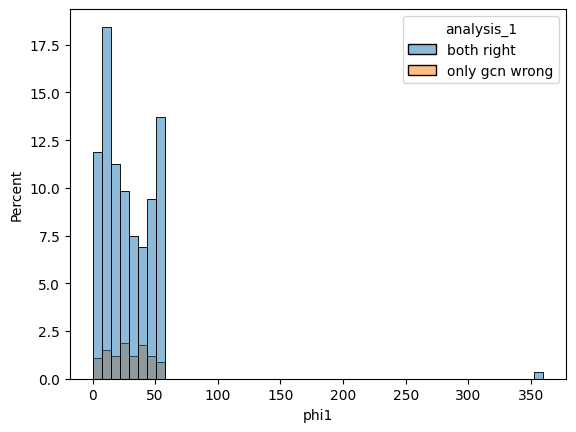

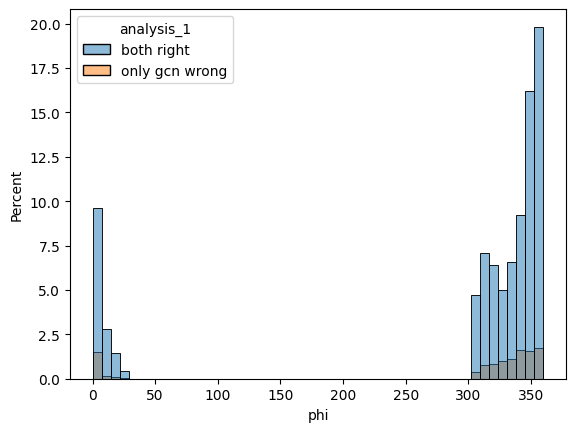

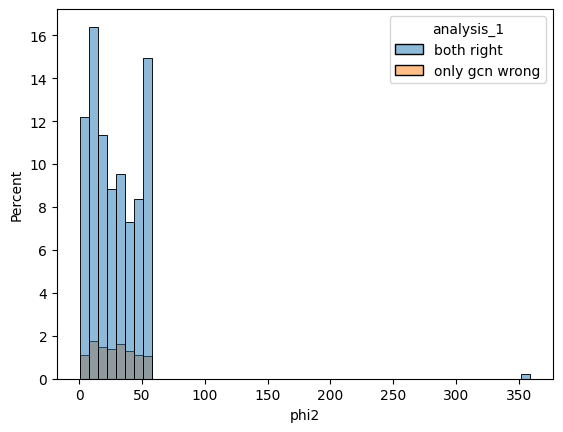

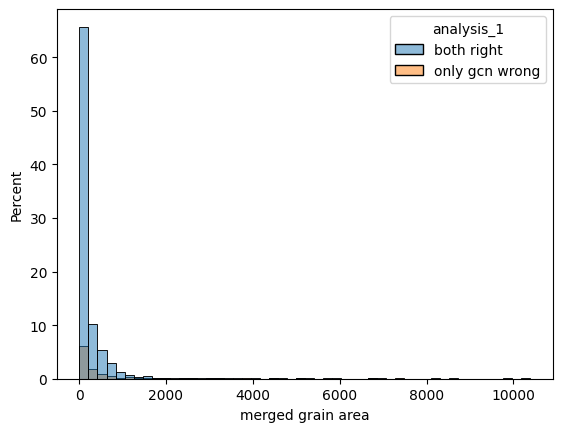

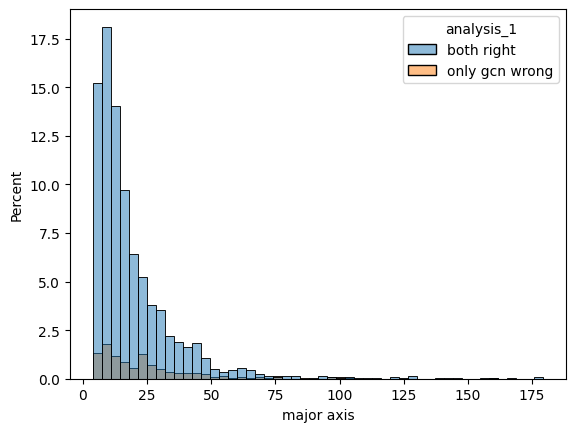

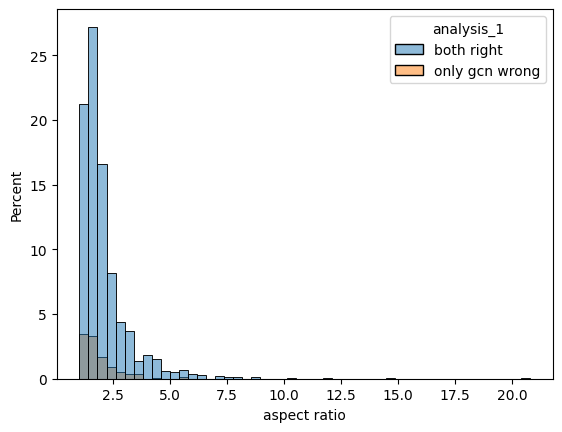

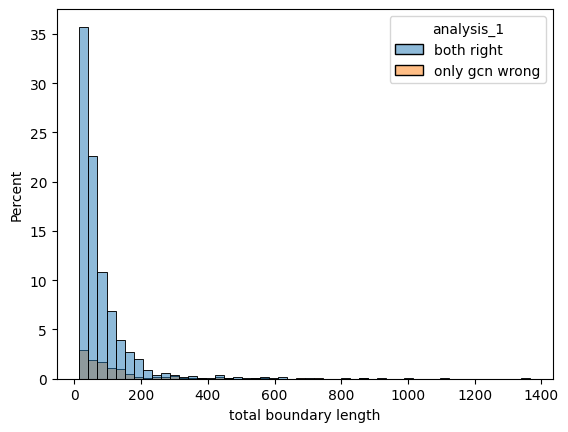

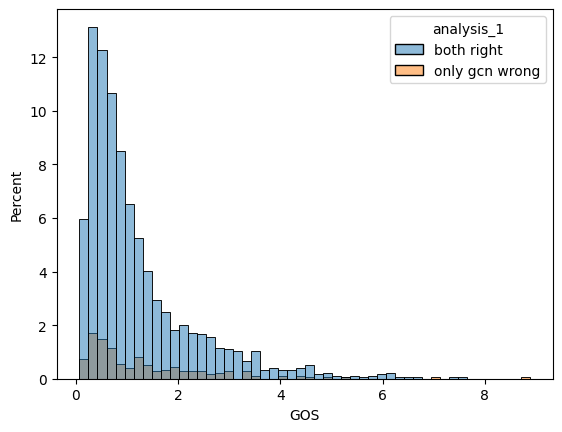

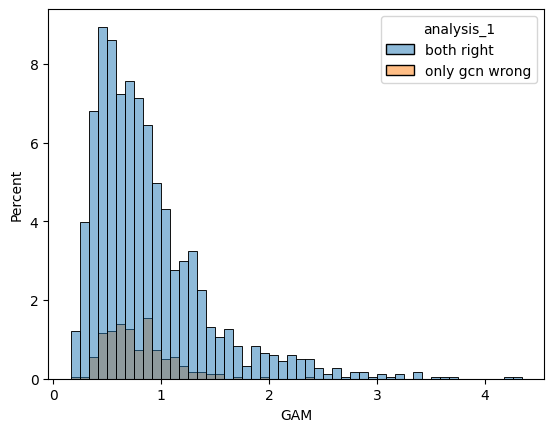

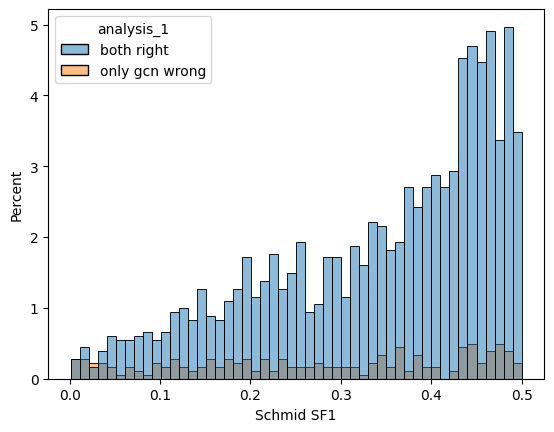

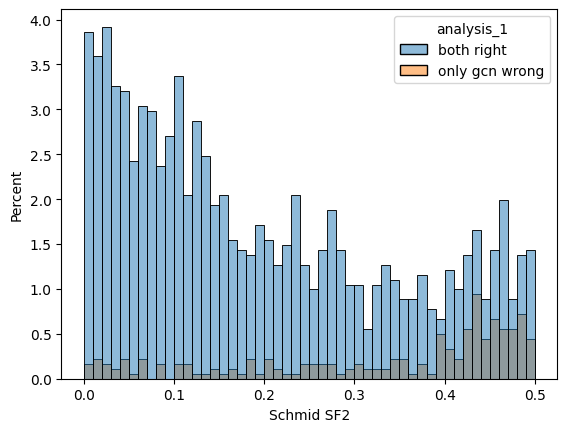

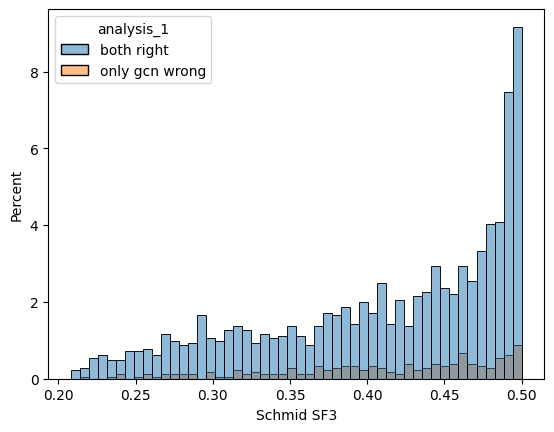

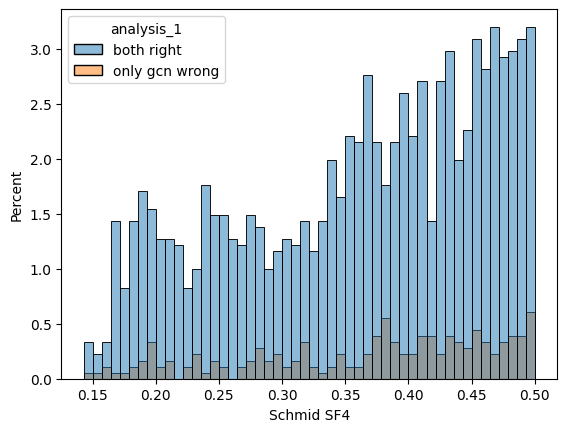

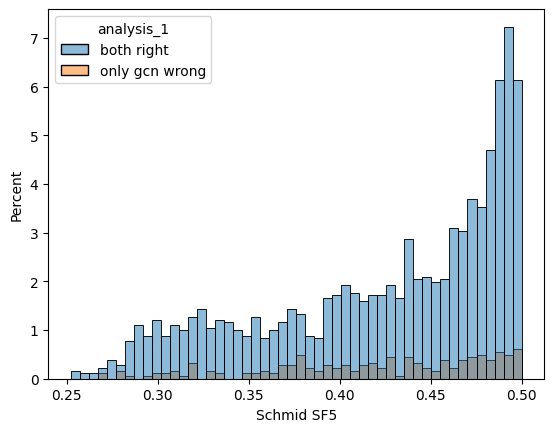

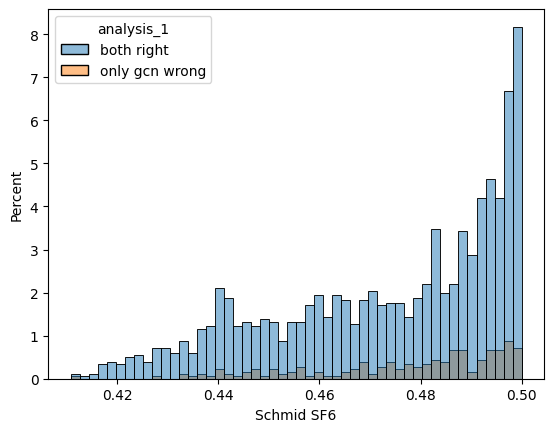

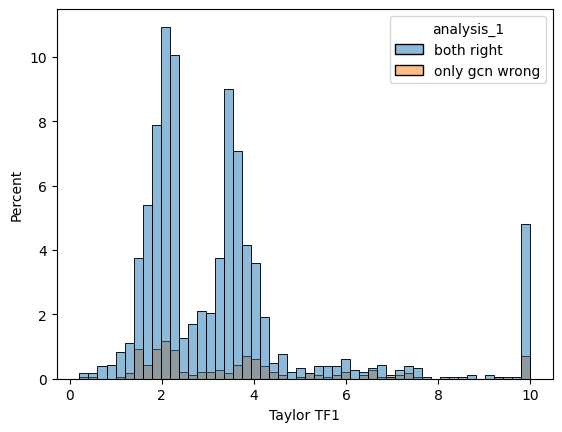

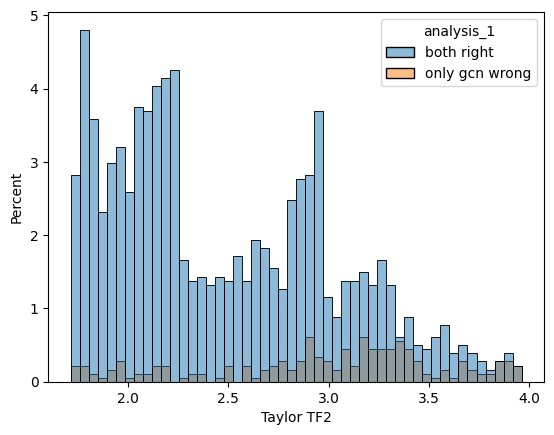

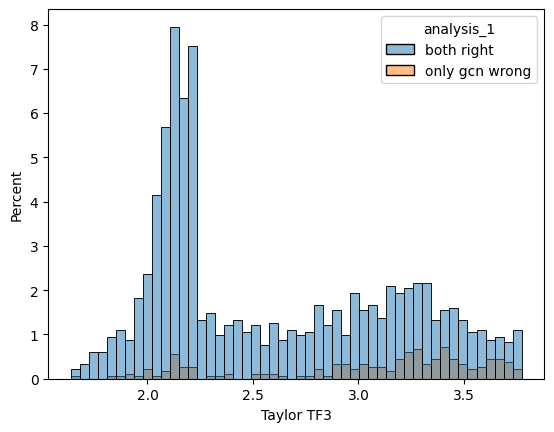

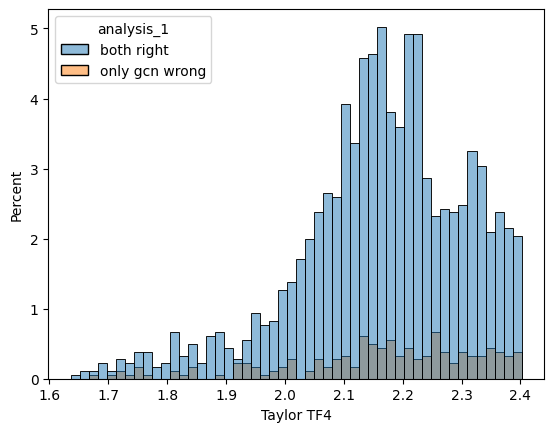

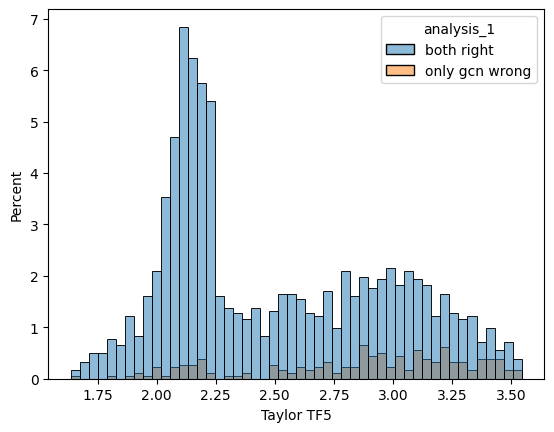

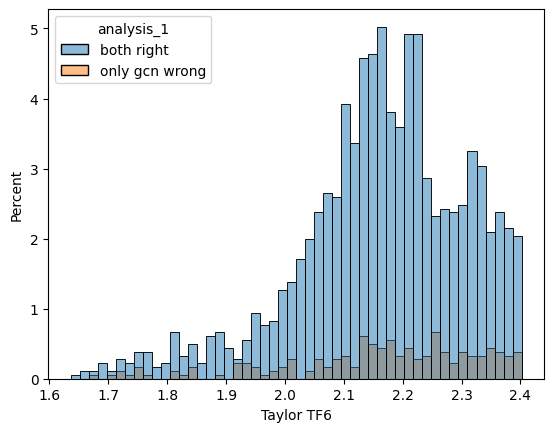

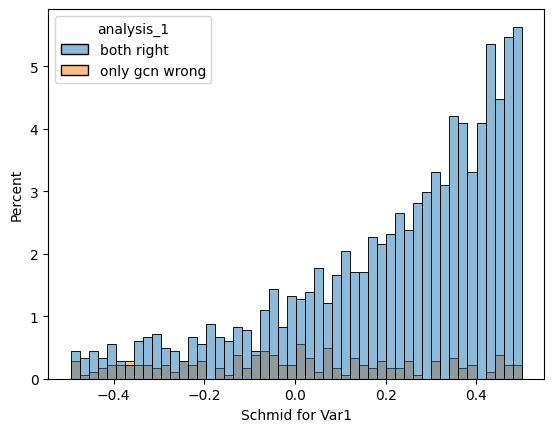

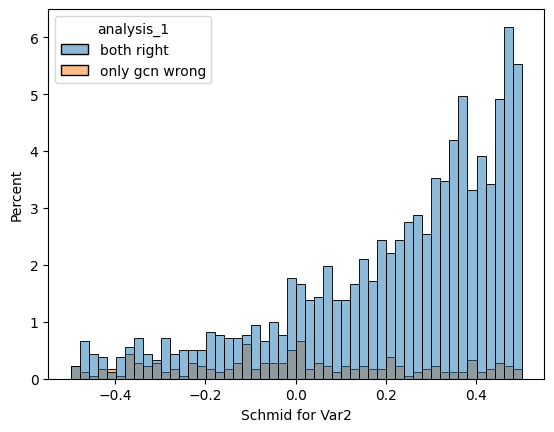

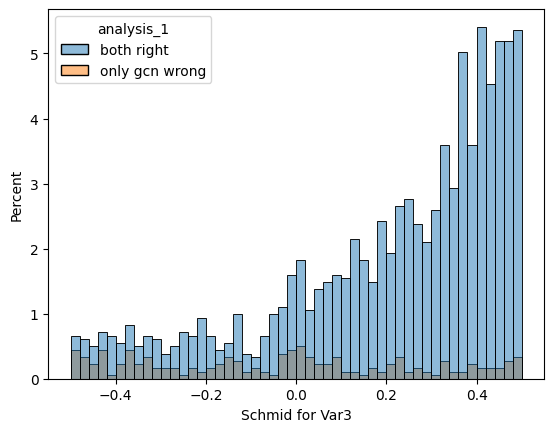

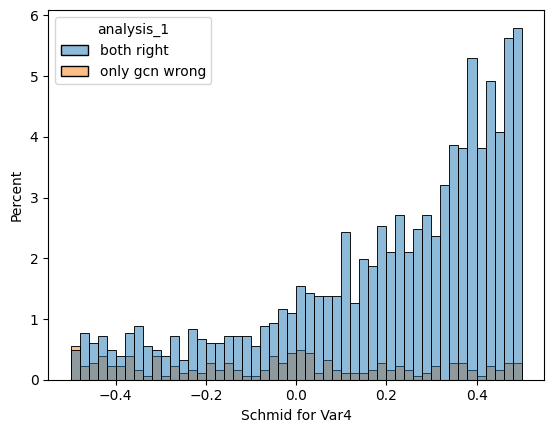

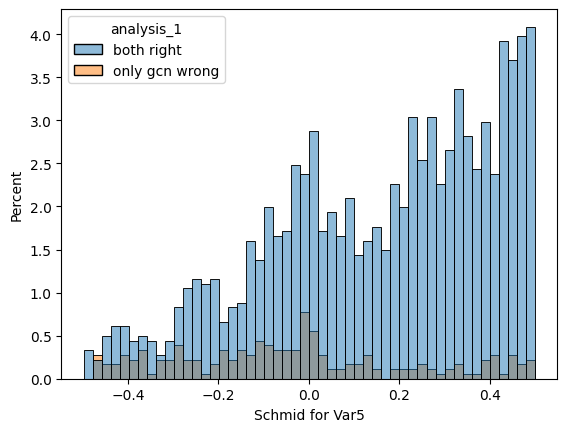

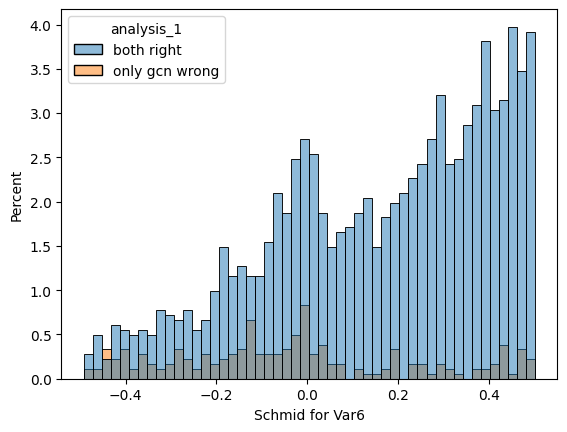

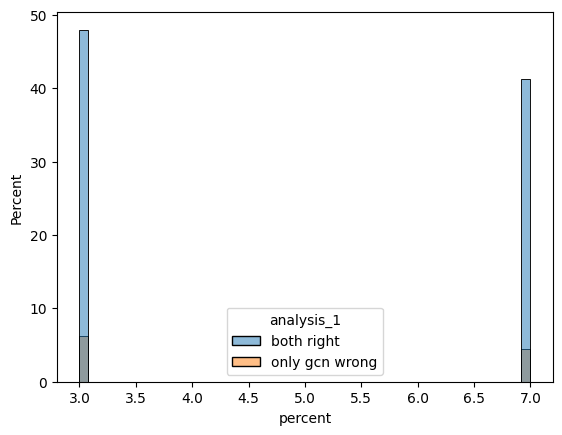

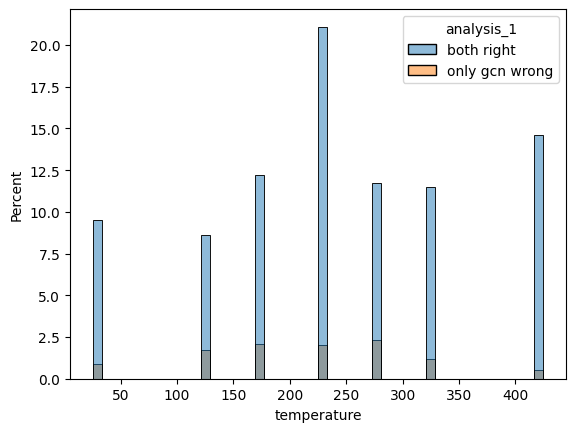

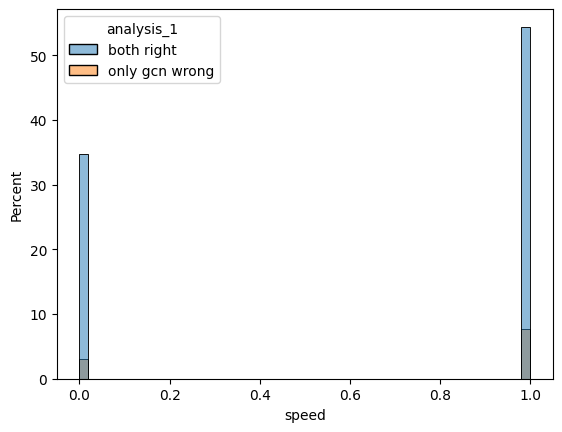

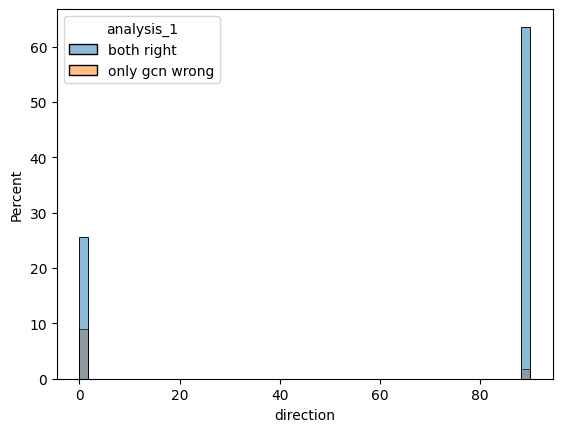

In [312]:
hue = "analysis_1"

for col in FEATURE_COLS:
    plt.figure()
    sns.histplot(data=df_2, x=col, hue=hue, multiple="layer", bins=50, stat="percent")
    plt.savefig(f"analysis_2_{col}.png")

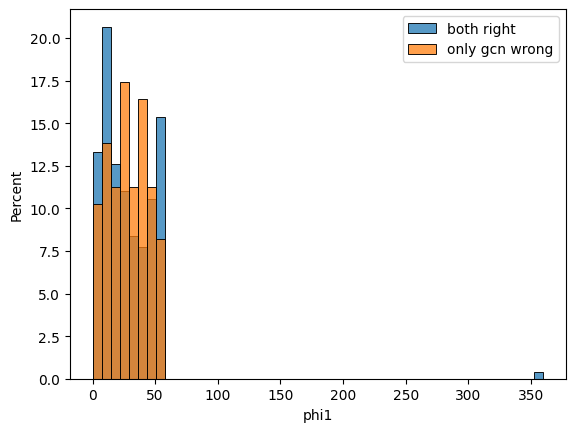

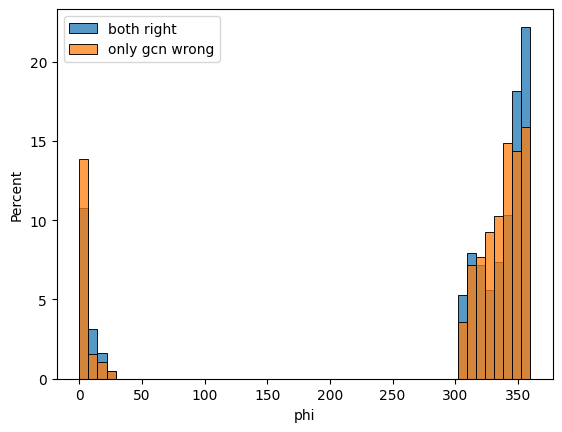

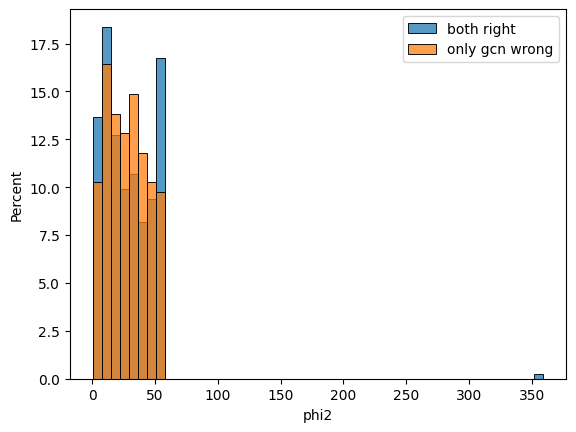

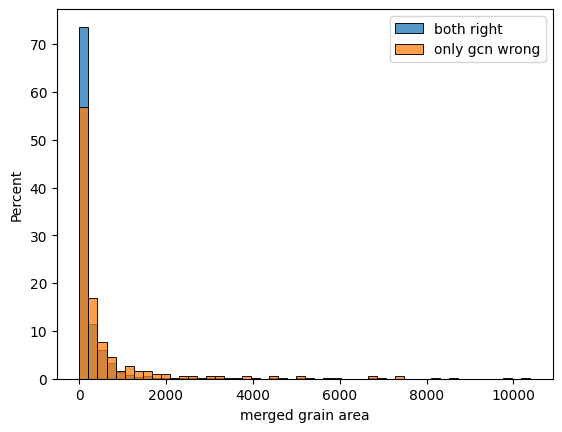

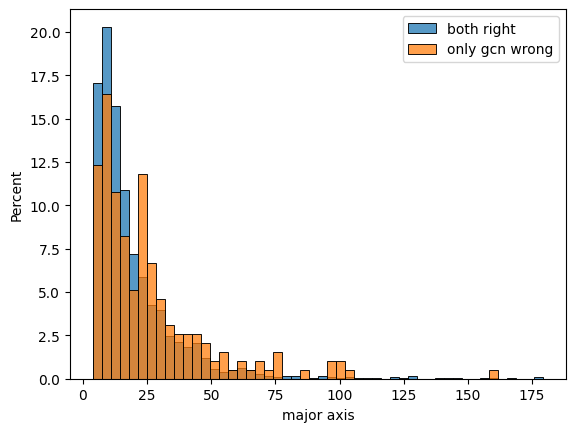

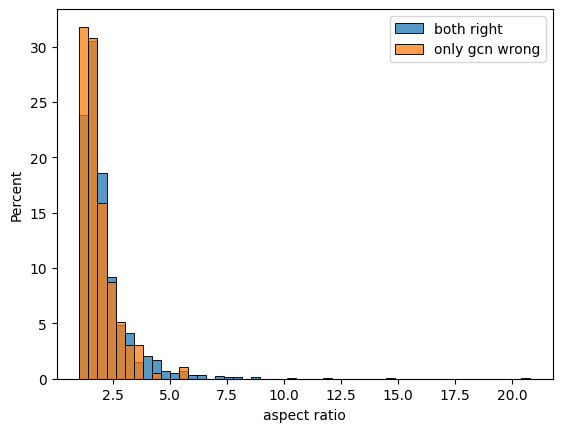

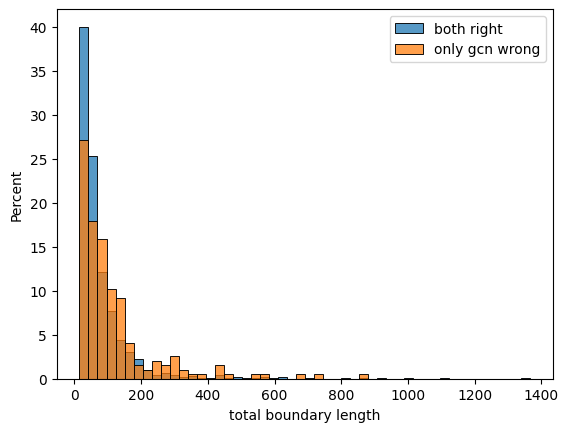

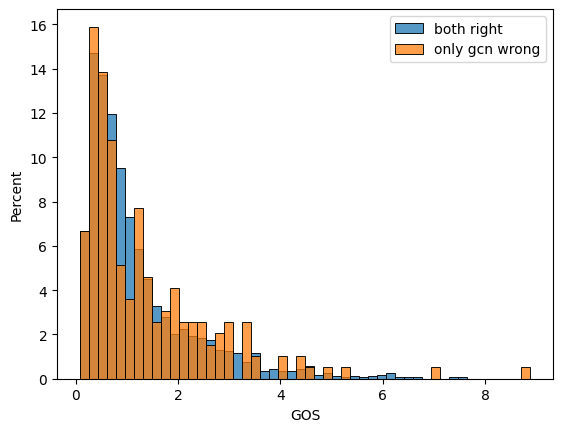

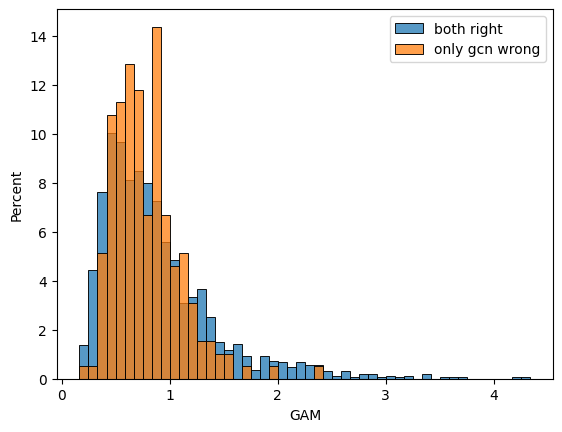

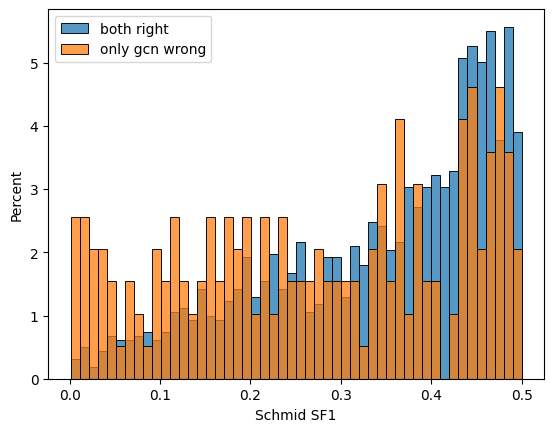

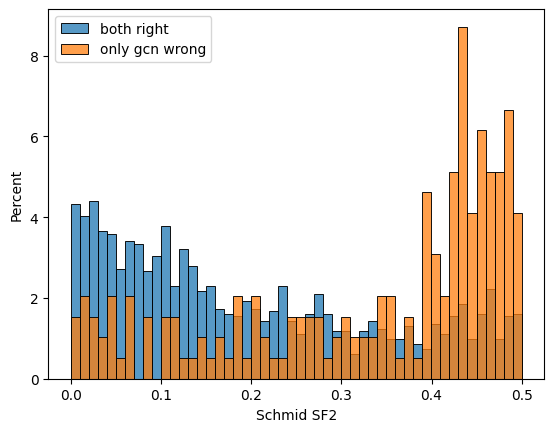

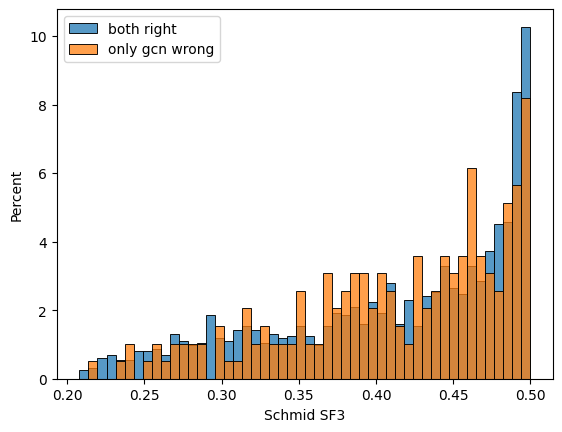

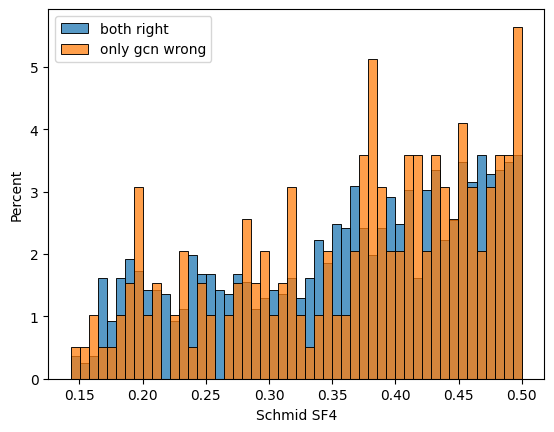

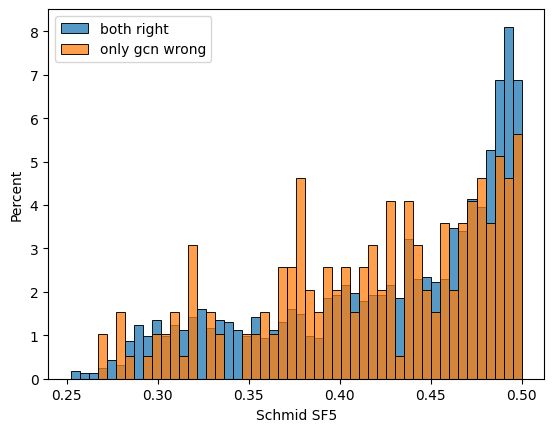

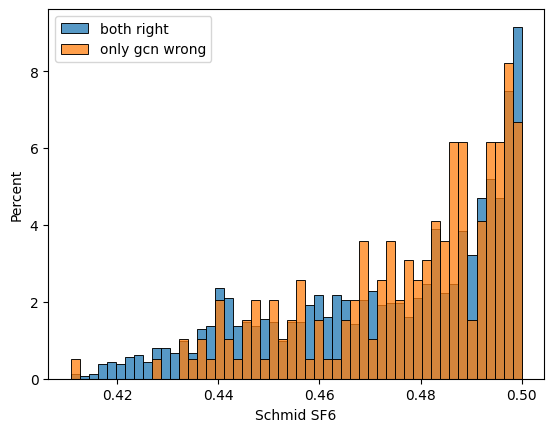

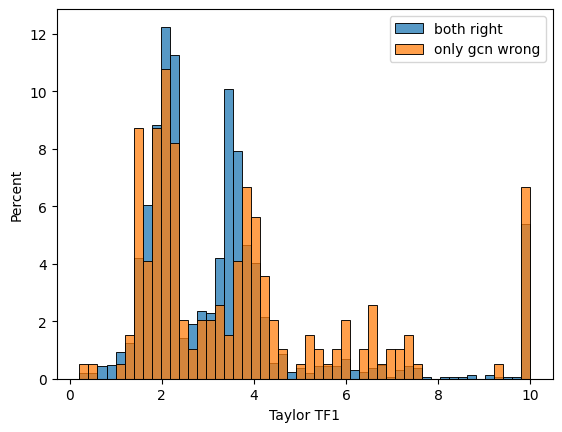

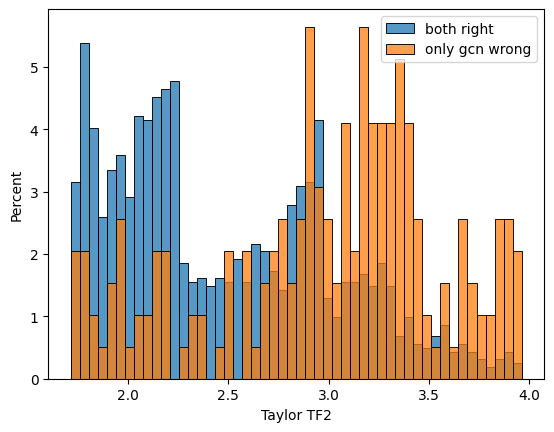

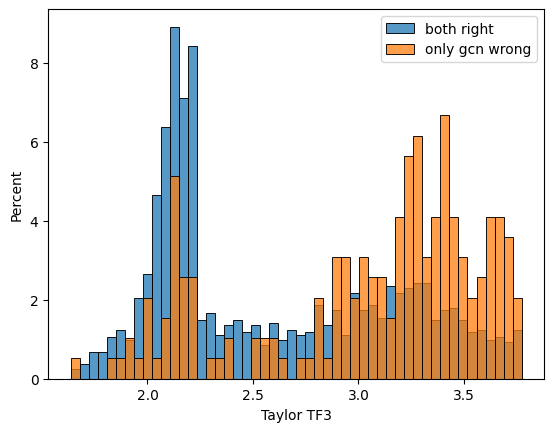

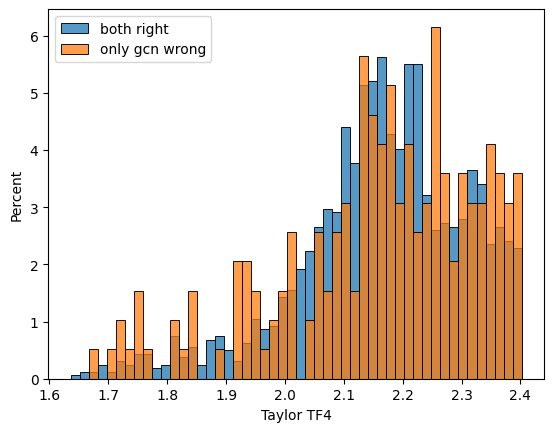

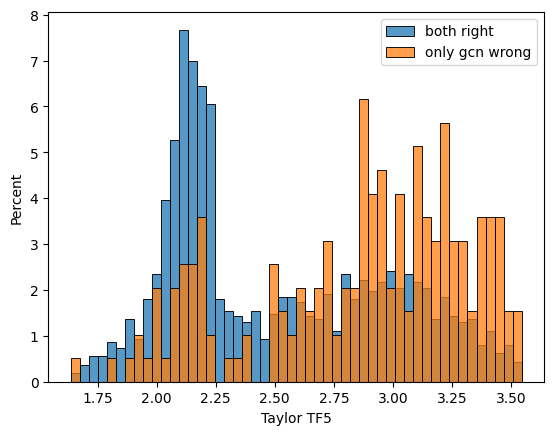

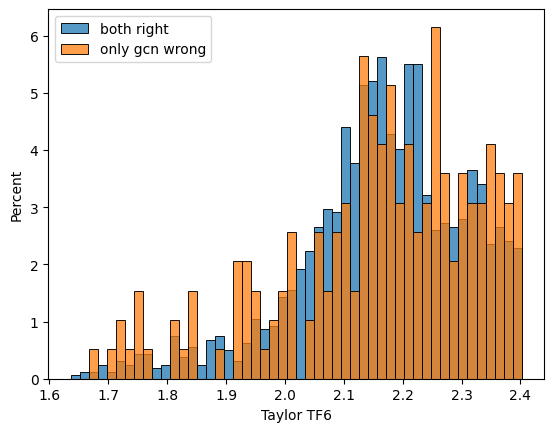

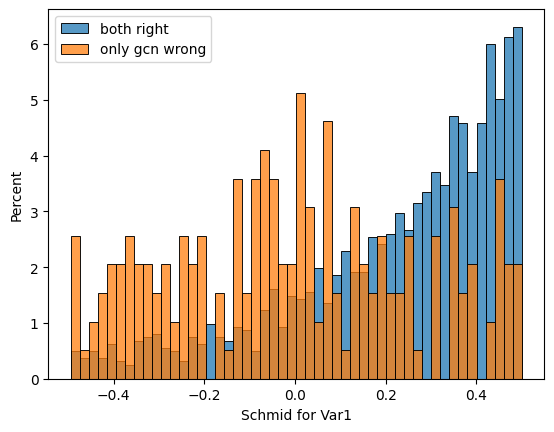

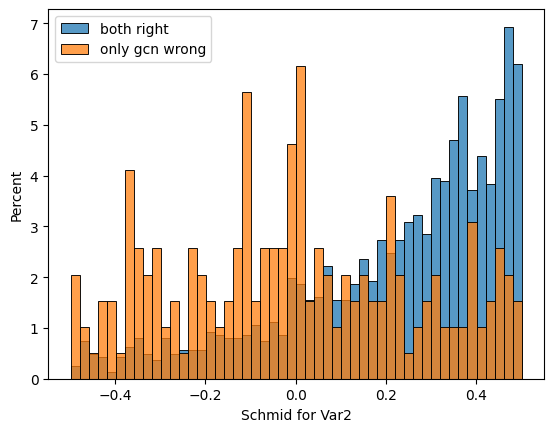

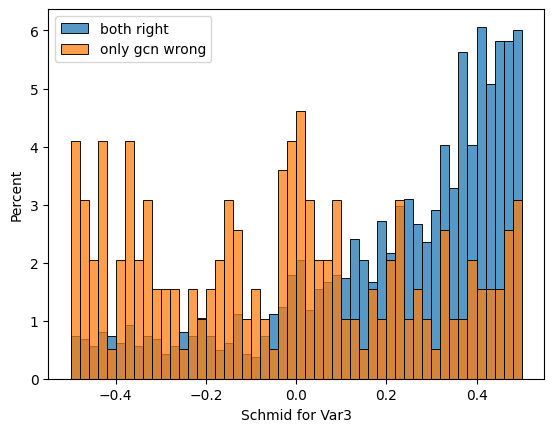

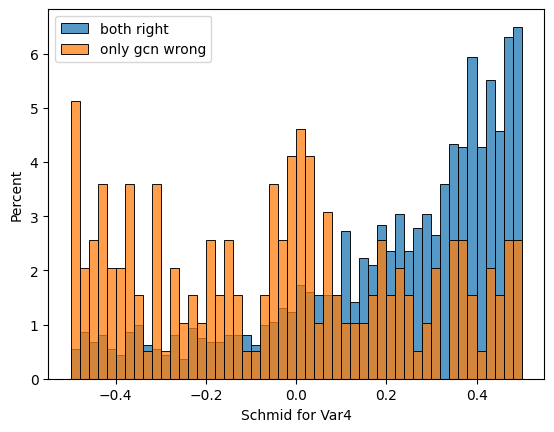

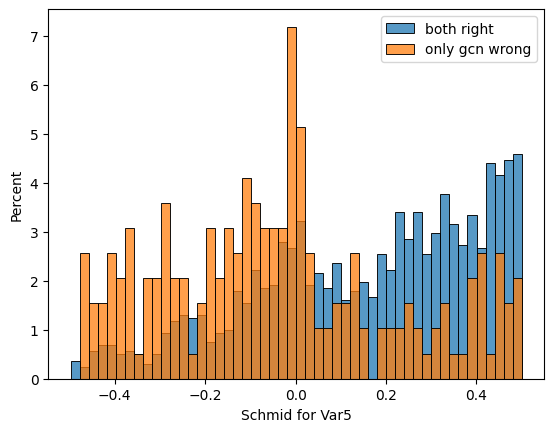

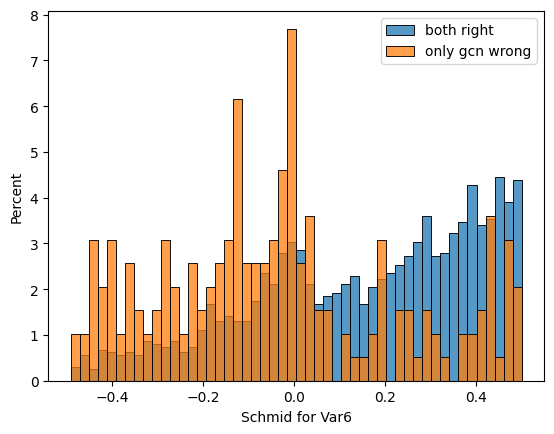

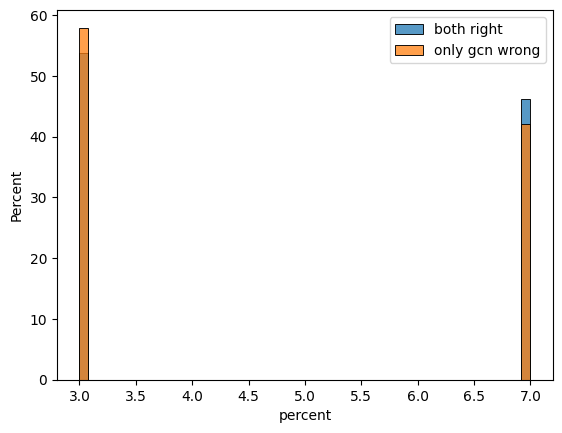

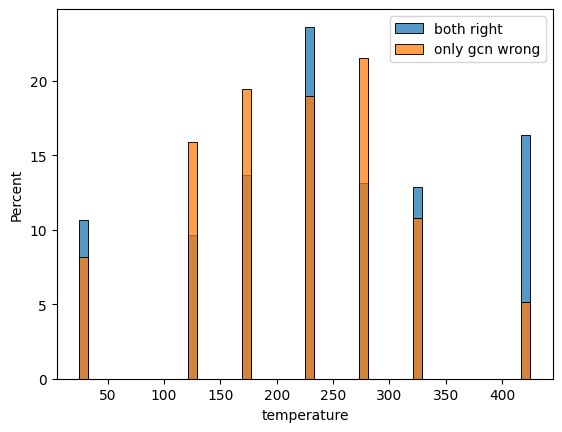

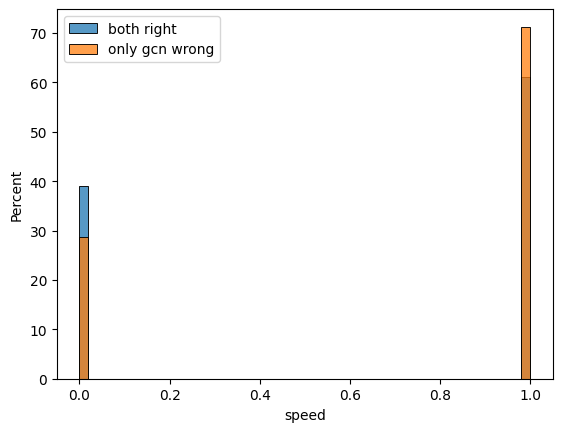

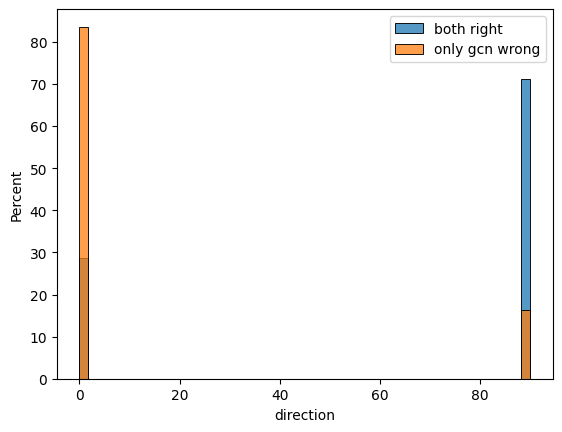

In [331]:
for col in FEATURE_COLS:
    plt.figure()
    bin_range = [df_2[col].min(), df_2[col].max()]
    sns.histplot(data=df_both_right, x=col, binrange=bin_range, bins=50, stat="percent")
    sns.histplot(data=df_only_gcn_wrong, x=col, binrange=bin_range, bins=50, stat="percent")
    plt.legend(["both right", "only gcn wrong"])
    plt.savefig(f"analysis_1_{col}.png")
    plt.show()

In [333]:
df_2.columns

Index(['merged ID', 'original grain id', 'phi1', 'phi', 'phi2',
       'merged grain area', 'parent Area', 'daughter Area', 'other area',
       'no. of parent grains', 'no. of daughter grains',
       'daughter grains percent', 'other daughters', 'other daughters area',
       'major axis', 'aspect ratio', 'total boundary length',
       'border boundary length', 'internal boundary length', 'GOS', 'GAM',
       'Schmid SF1', 'Schmid SF2', 'Schmid SF3', 'Schmid SF4', 'Schmid SF5',
       'Schmid SF6', 'Taylor TF1', 'Taylor TF2', 'Taylor TF3', 'Taylor TF4',
       'Taylor TF5', 'Taylor TF6', 'Twin Count for Var1',
       'Twin Count for Var2', 'Twin Count for Var3', 'Twin Count for Var4',
       'Twin Count for Var5', 'Twin Count for Var6', 'Area Twinned for Var1',
       'Area Twinned for Var2', 'Area Twinned for Var3',
       'Area Twinned for Var4', 'Area Twinned for Var5',
       'Area Twinned for Var6', 'Schmid for Var1', 'Schmid for Var2',
       'Schmid for Var3', 'Schmid for Var

In [335]:
col = "neighbor grains count"
plt.figure()
bin_range = [df_2[col].min(), df_2[col].max()]
sns.histplot(data=df_both_right, x=col, binrange=bin_range, bins=50, stat="percent")
sns.histplot(data=df_only_gcn_wrong, x=col, binrange=bin_range, bins=50, stat="percent")
plt.legend(["both right", "only gcn wrong"])
plt.show()

In [ ]:
col = "neighbor grains count"
plt.figure()
bin_range = [df_2[col].min(), df_2[col].max()]
sns.histplot(data=df_both_right, x=col, binrange=bin_range, bins=50, stat="percent")
sns.histplot(data=df_only_gcn_wrong, x=col, binrange=bin_range, bins=50, stat="percent")
plt.legend(["both right", "only gcn wrong"])
plt.show()

### Twin / Not Twin 특징별 분포 확인

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


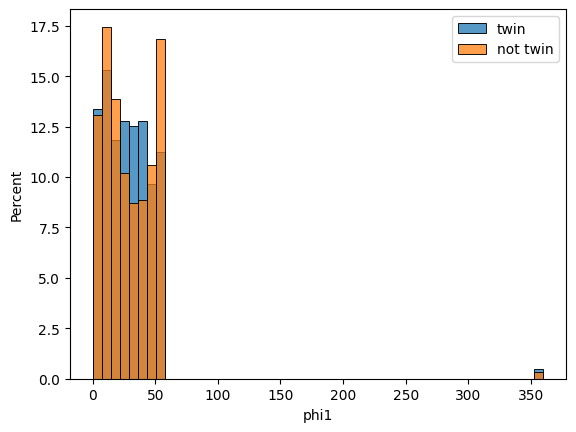

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


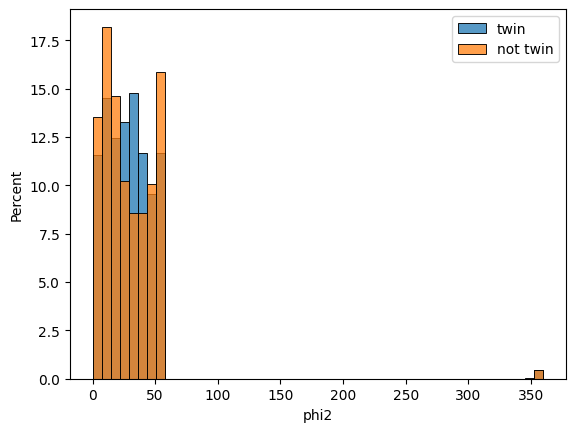

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


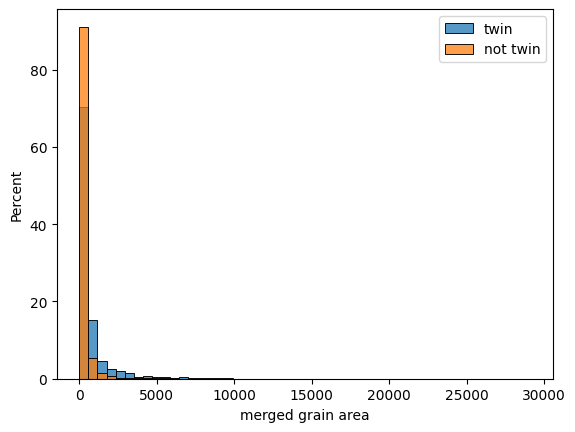

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


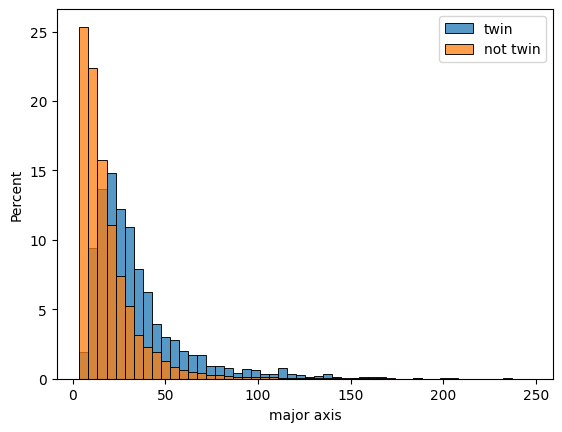

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


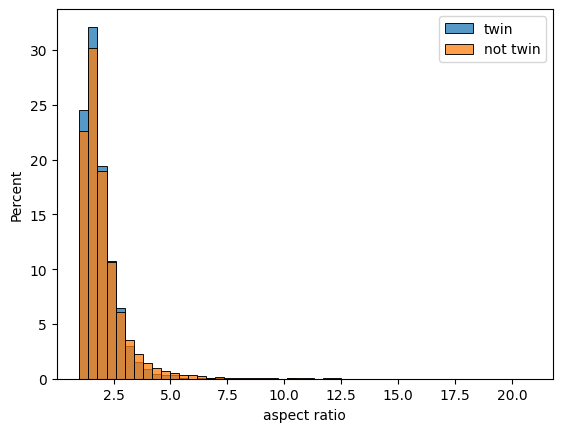

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


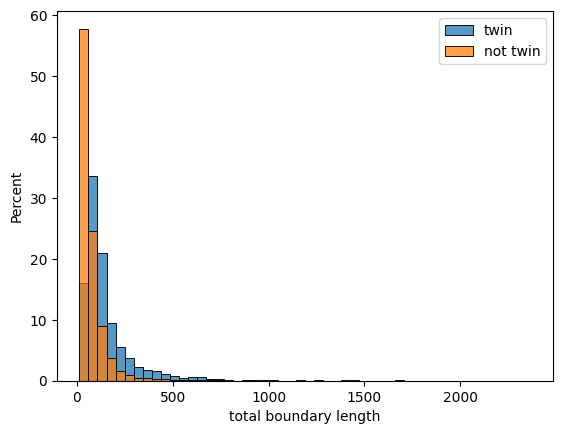

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


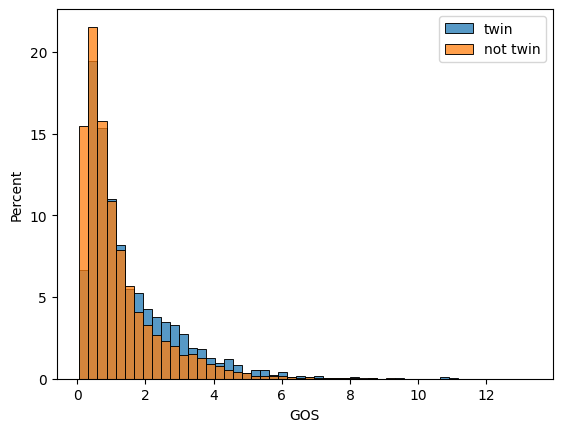

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


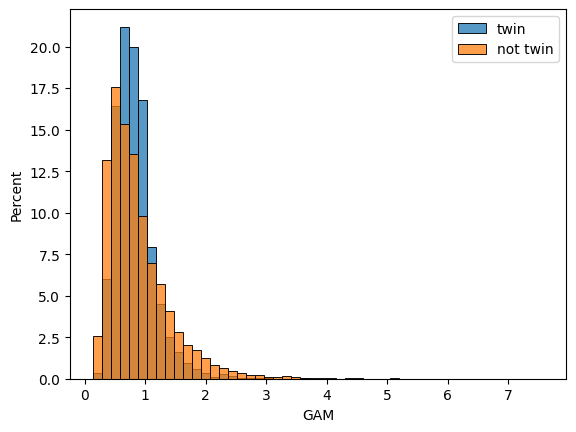

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


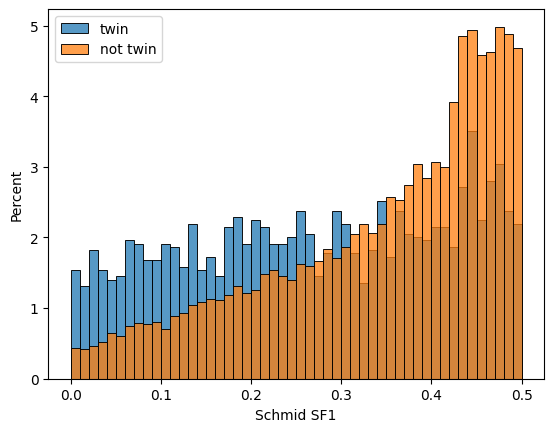

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


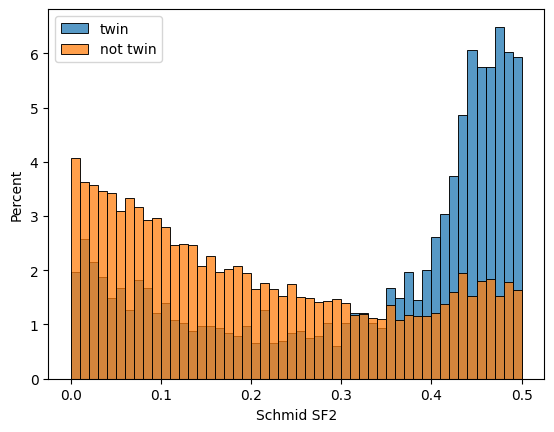

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


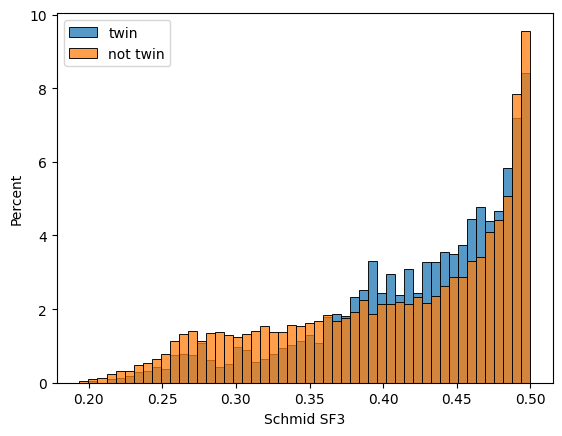

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


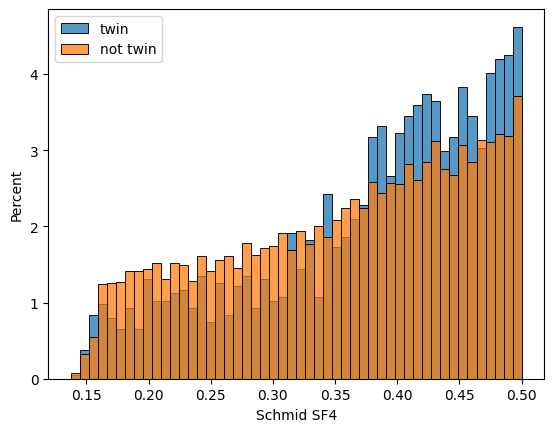

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


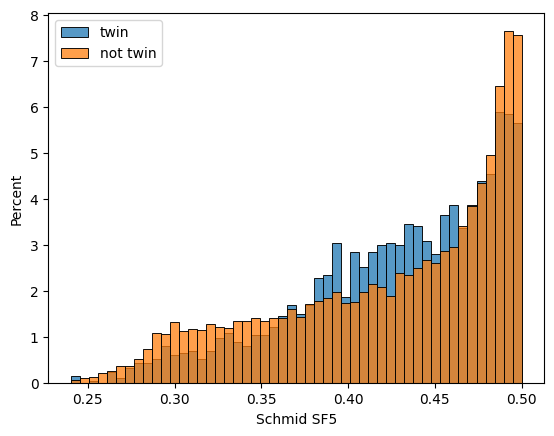

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


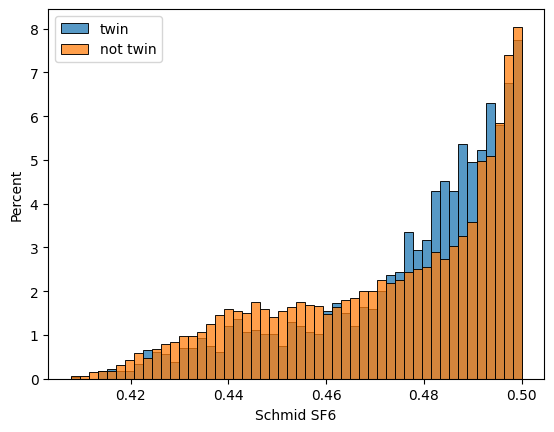

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


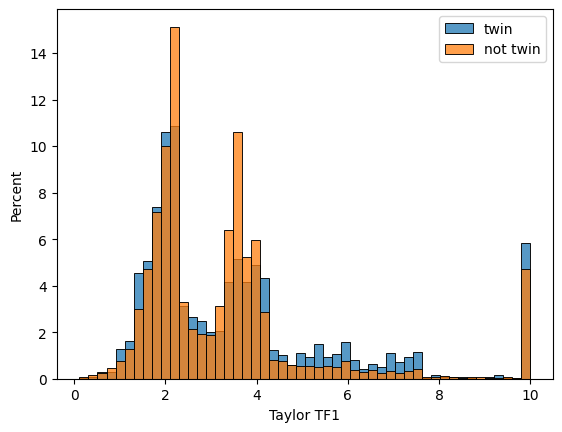

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


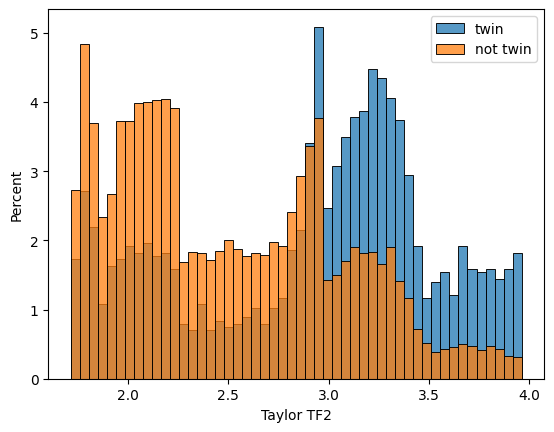

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


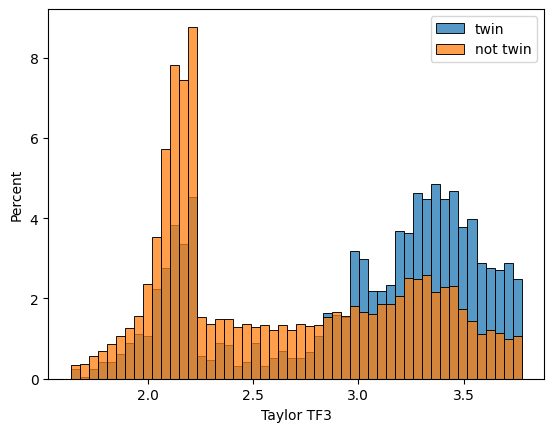

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


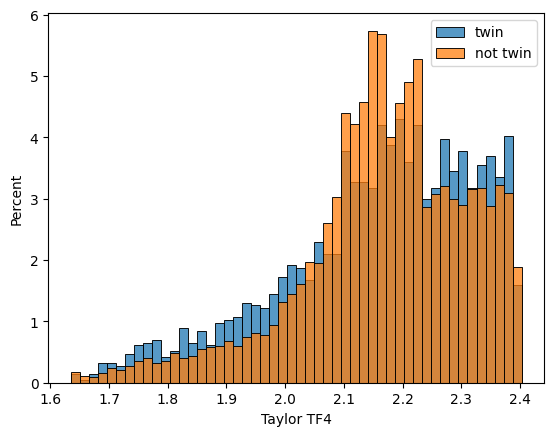

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


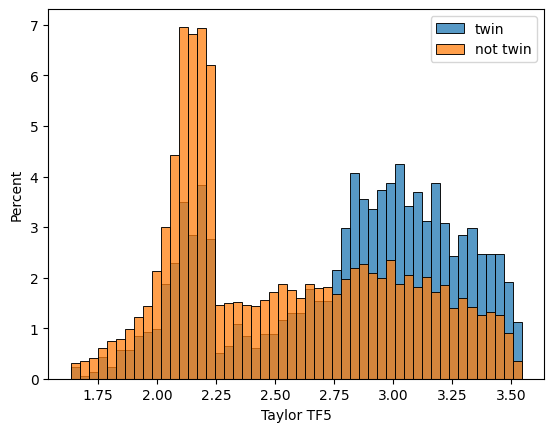

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


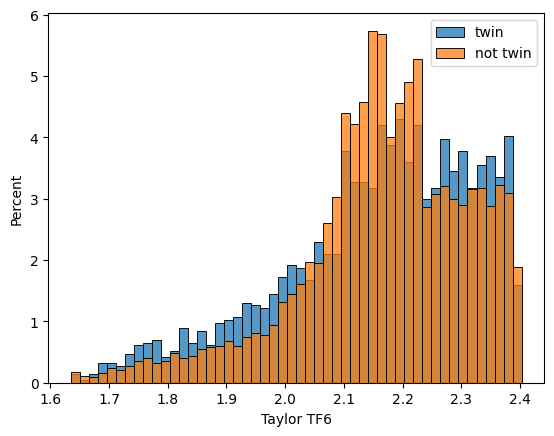

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


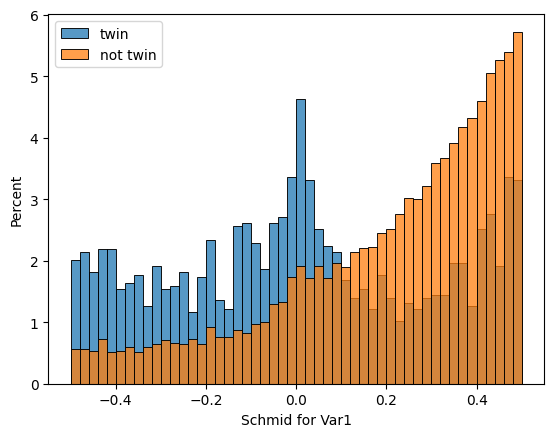

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


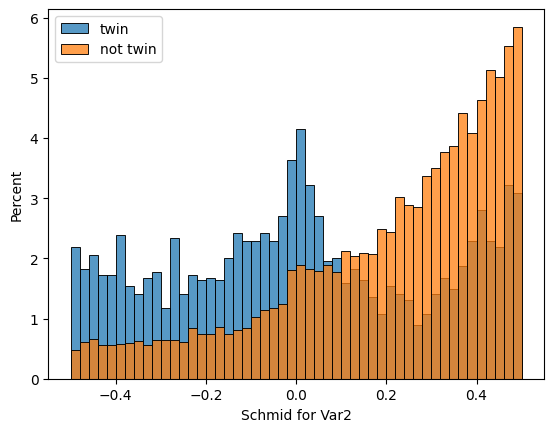

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


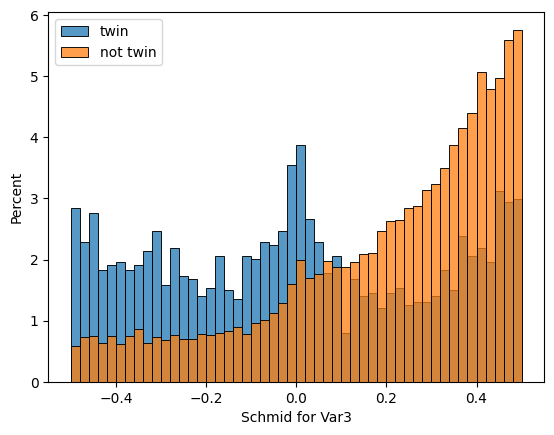

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


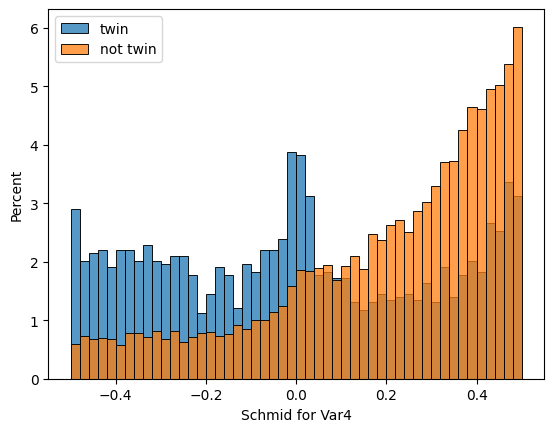

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


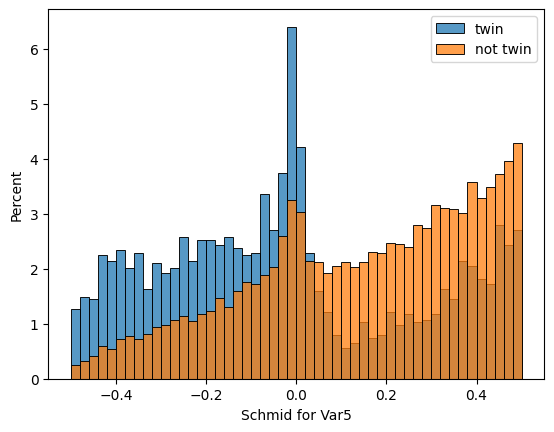

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


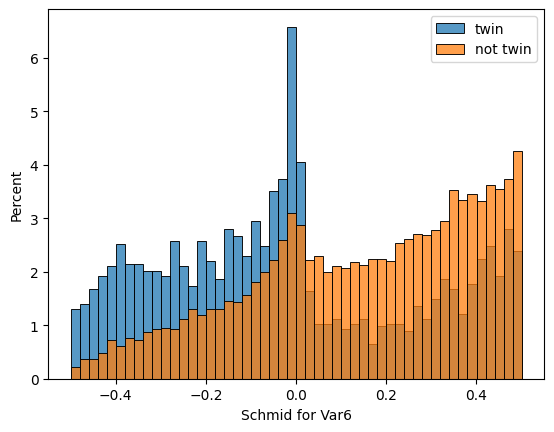

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


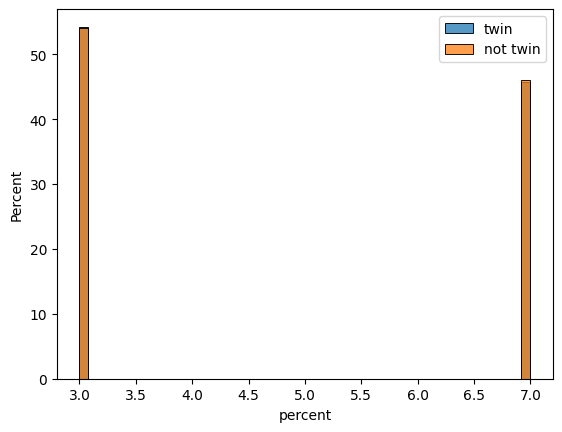

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


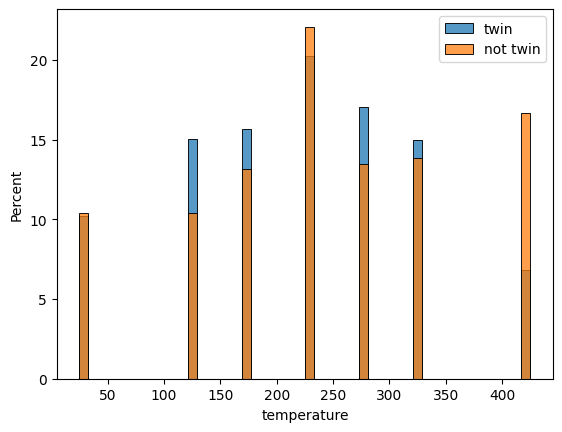

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


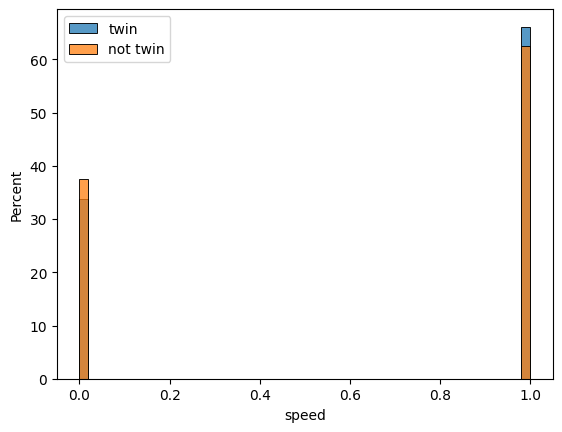

C:\Users\msi\AppData\Local\Temp\ipykernel_49996\4192295637.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


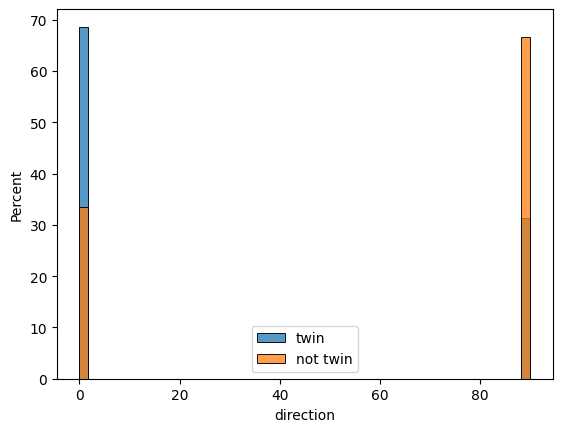

In [514]:
for col in FEATURE_COLS:
    plt.figure()
    bin_range = [df[col].min(), df[col].max()]
    sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")
    sns.histplot(data=df[df_with_y_again["twin_or_not"] != 1], x=col, binrange=bin_range, bins=50, stat="percent")
    plt.legend(["twin", "not twin"])
    plt.savefig(f"analysis_2_twin_not_{col}_train_only.png")
    plt.show()

In [398]:
file_path_list[18]

WindowsPath('C:/Users/msi/Desktop/workspace/042_materials_GNN/Data Sets for ML/Data Sets for ML/V90/225_LS/3%/MergedGrainsData_V90_225_0083_3pct.xlsx')

In [ ]:
for col in FEATURE_COLS:
    plt.figure()
    bin_range = [df_2[col].min(), df_2[col].max()]
    sns.histplot(data=df_both_right, x=col, binrange=bin_range, bins=50, stat="percent")
    sns.histplot(data=df_only_gcn_wrong, x=col, binrange=bin_range, bins=50, stat="percent")
    plt.legend(["both right", "only gcn wrong"])
    plt.savefig(f"analysis_1_{col}.png")
    plt.show()

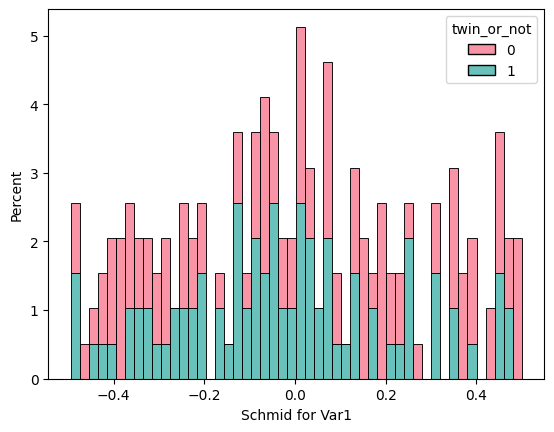

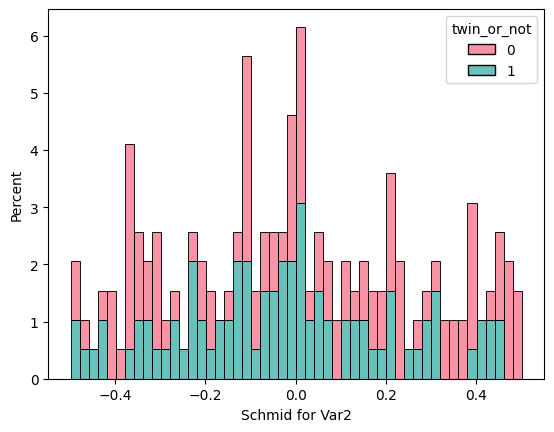

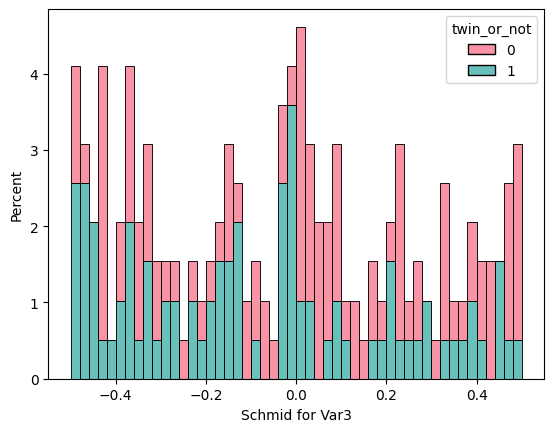

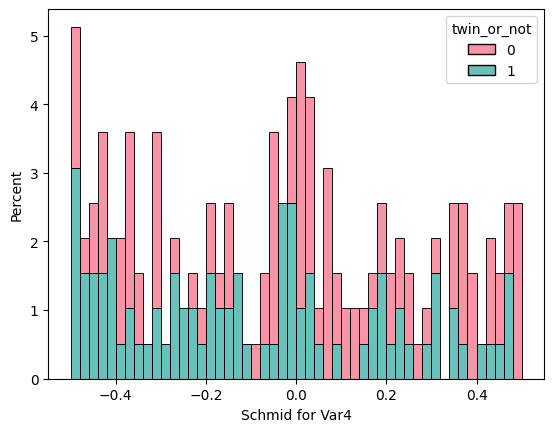

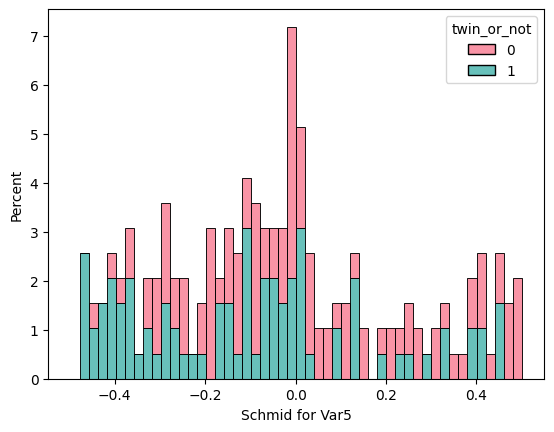

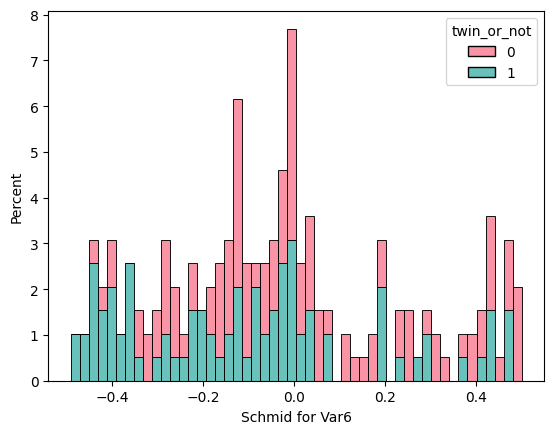

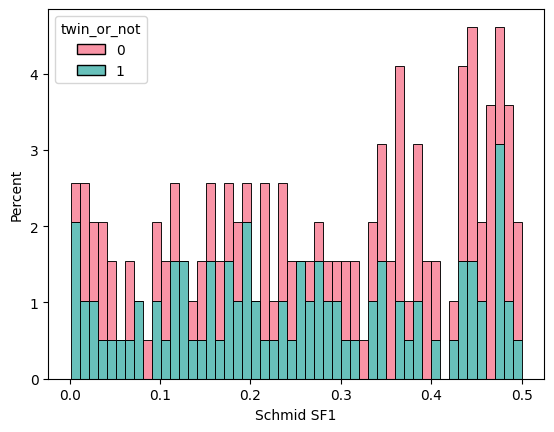

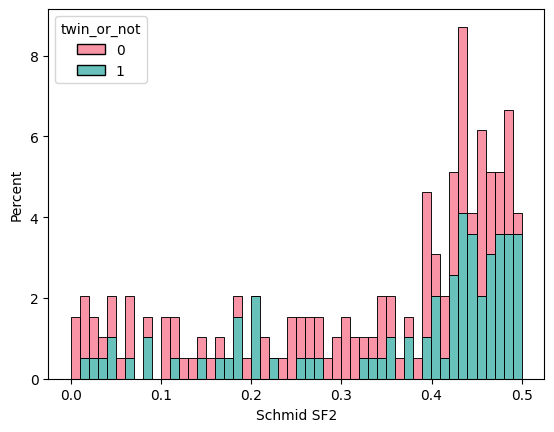

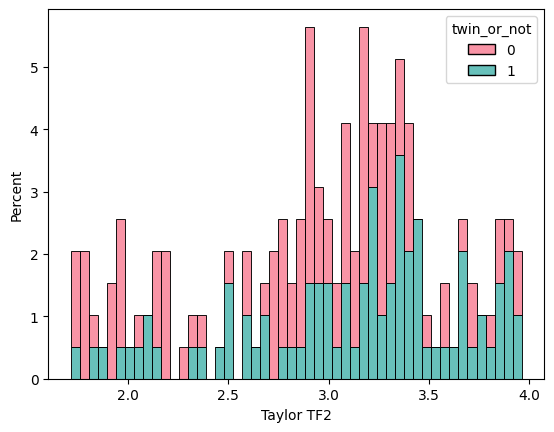

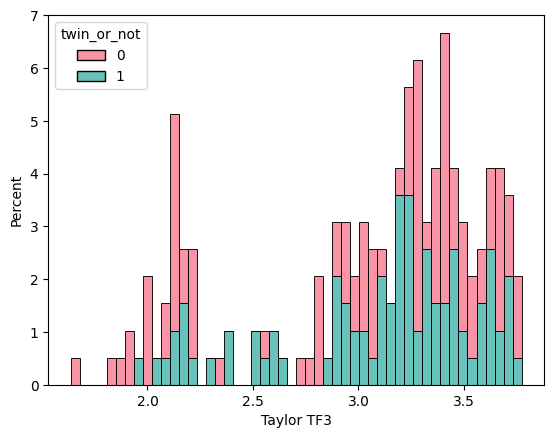

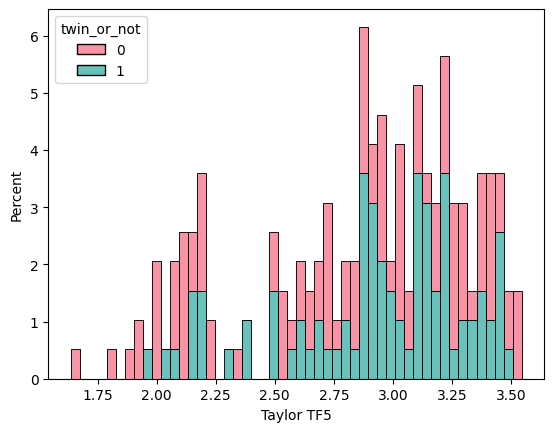

In [430]:
inspection_cols = [
    "Schmid for Var1",
    "Schmid for Var2",
    "Schmid for Var3",
    "Schmid for Var4",
    "Schmid for Var5",
    "Schmid for Var6",
    "Schmid SF1",
    "Schmid SF2",
    "Taylor TF2",
    "Taylor TF3",
    "Taylor TF5",
]
for col in inspection_cols:
    plt.figure()
    bin_range = [df_2[col].min(), df_2[col].max()]
    sns.histplot(data=df_only_gcn_wrong, x=col, bins=50, hue="twin_or_not", multiple="stack", binrange=bin_range, stat="percent", palette="husl")
    plt.savefig(f"analysis_3_twin_not_gcn_wrong_{col}")
    plt.show()

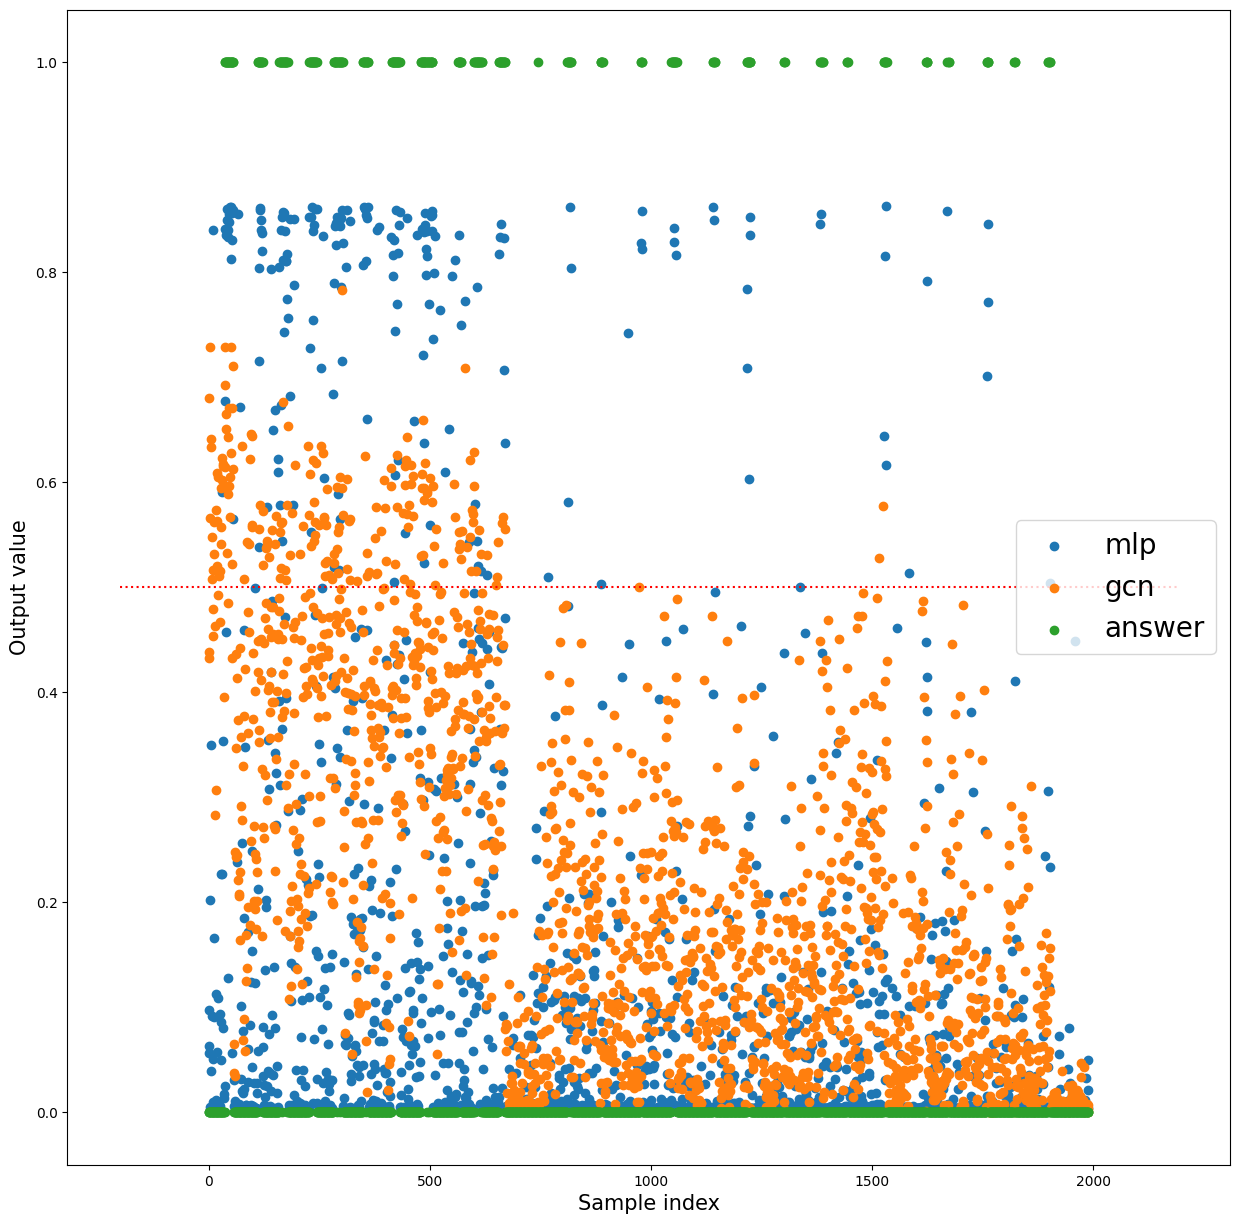

In [515]:
y_mlp = F.sigmoid(out_mlp.squeeze()).numpy()
y_gcn = F.sigmoid(out_gcn[data.test_mask]).numpy()
length = np.arange(len(y_mlp))
plt.figure(figsize=(15, 15))
plt.scatter(x=length, y=y_mlp)
plt.scatter(x=length, y=y_gcn)
plt.scatter(x=length, y=y_true)
plt.hlines(y=0.5, xmin=min(length)-200, xmax=max(length)+200, colors="red", linestyles="dotted")
plt.legend(["mlp", "gcn", "answer"], fontsize=20)
plt.xlabel("Sample index", fontsize=15)
plt.ylabel("Output value", fontsize=15)
plt.show()

In [464]:
out_mlp.squeeze().numpy()

array([-2.2259417, -2.8226595, -2.6961317, ..., -2.9592993, -5.492772 ,
       -3.83086  ], dtype=float32)

In [502]:
df_only_gcn_wrong[df_only_gcn_wrong["Schmid for Var1"] < 0]["twin_or_not"].value_counts(normalize=True)

twin_or_not
0    0.505051
1    0.494949
Name: proportion, dtype: float64

In [496]:
32 / 54

0.5925925925925926

In [505]:
df_test_only[df_test_only["Schmid for Var1"] < 0]["twin_or_not"].value_counts(normalize=True)

twin_or_not
0    0.717391
1    0.282609
Name: proportion, dtype: float64

In [511]:
df_train_only = df_with_y_again[data.train_mask.numpy()]

In [512]:
df_train_only[df_train_only["Schmid for Var1"] < 0]["twin_or_not"].value_counts(normalize=True)

twin_or_not
0    0.719489
1    0.280511
Name: proportion, dtype: float64

In [384]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GATConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GATConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GATConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = self.log_softmax(x)
        x = x.squeeze()
        return x


model = GAT(hidden_channels=64)
print(f"GAT model number of params: {count_parameters(model.parameters()):,}")

345,091
GAT model number of params: 345,091


In [385]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight) # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.7486 / Val_loss: 0.7305
Epoch: 002, Train_loss: 0.6068 / Val_loss: 0.6118
Epoch: 003, Train_loss: 0.5774 / Val_loss: 0.5909
Epoch: 004, Train_loss: 0.5147 / Val_loss: 0.5306
Epoch: 005, Train_loss: 0.5227 / Val_loss: 0.5622
Epoch: 006, Train_loss: 0.4805 / Val_loss: 0.5135
Epoch: 007, Train_loss: 0.4968 / Val_loss: 0.5334
Epoch: 008, Train_loss: 0.4871 / Val_loss: 0.5074
Epoch: 009, Train_loss: 0.4701 / Val_loss: 0.4936
Epoch: 010, Train_loss: 0.4633 / Val_loss: 0.4811
Epoch: 011, Train_loss: 0.4564 / Val_loss: 0.4959
Epoch: 012, Train_loss: 0.4852 / Val_loss: 0.5006
Epoch: 013, Train_loss: 0.4734 / Val_loss: 0.4908
Epoch: 014, Train_loss: 0.4234 / Val_loss: 0.4675
Epoch: 015, Train_loss: 0.4220 / Val_loss: 0.4391
Epoch: 016, Train_loss: 0.4191 / Val_loss: 0.4266
Epoch: 017, Train_loss: 0.4107 / Val_loss: 0.4257
Epoch: 018, Train_loss: 0.3902 / Val_loss: 0.3937
Epoch: 019, Train_loss: 0.4030 / Val_loss: 0.4113
Epoch: 020, Train_loss: 0.3878 / Val_loss: 0.3893


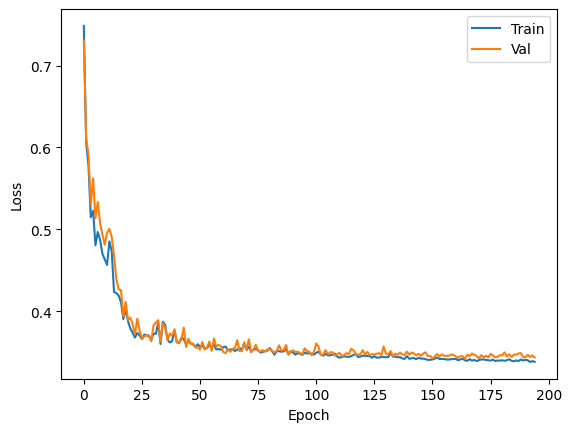

In [386]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [387]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = F.sigmoid(out).round()
# pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

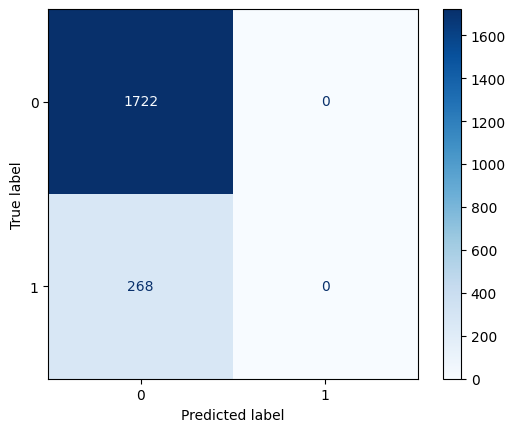

Accuracy: 0.8653
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [388]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

#### 외곽선에 걸친 샘플 제거

In [112]:
BORDER_COL = 'border boundary length'
df_inside = df[df[BORDER_COL] == 0]
df_inside = df_inside.reset_index(drop=True)

In [113]:
df_inside.shape

(17123, 64)

In [114]:
edges_2 = []
edge_info_2 = df_inside[EDGE_COL].map(lambda x: list(map(int, x.split(","))))
for i, e_list in enumerate(edge_info_2):
    df_set = df_inside[df_inside["set_num"] == df_inside.iloc[i]["set_num"]]
    indices_included = df_set["merged ID"].tolist()
    for e in e_list:
        if e in indices_included:
            idx = df_set.index[df_set["merged ID"] == e].tolist()[0]
            new = [i, idx]
            edges_2.append(new)
        
edge_index_2 = torch.Tensor(edges_2).to(dtype=torch.long).t()

In [116]:
df_inside[df_inside["set_num"] == df_inside["set_num"].iloc[-1]][:50]

merged ID  original grain id       phi1         phi        phi2  \
16313          9                  9  10.134939    7.609234   51.019148   
16314         10                 10  52.390215  355.674708    2.241037   
16315         11                 11   8.105772    8.579832   53.733370   
16316         13                 13  15.607356  323.174189   40.657522   
16317         17                 17  54.604796  354.143851    9.170345   
16318         18                 18  24.977943  311.062411   16.112529   
16319         22                 22  30.436445  355.589853   36.563338   
16320         23                 23  15.222485  341.649022   51.687015   
16321         24                 24  46.440236  356.917186    6.967073   
16322         25                 25  14.047018  314.795996   32.222028   
16323         27                 27  35.553611    3.270333   10.135429   
16324         28                 28   7.653132  338.574001   49.365111   
16325         29                 29  14.820576  338.390486   48.939989   
16326         30                 30  17.051021    0.156308   51.787541   
16327         32                 32   9.240585   14.314289   53.828400   
16328         33                 33  21.147104  356.335233   14.810760   
16329         34                 34  15.099269  353.940717   40.693667   
16330         35                 35  13.791844  357.290715   54.574528   
16331         36                 36  12.877590  335.274752   48.591635   
16332         37                 37  17.262324  349.760352   46.759322   
16333         38                 38   9.109405  350.656409   51.953856   
16334         39                 39  31.714256  357.002482   18.060793   
16335         40                 40  51.832110  337.952850    8.196501   
16336         41                 41   0.633709   16.403603   54.786900   
16337         42                 42  17.159597  346.039535   49.477372   
16338         43                 43   3.796878    6.751793   56.135051   
16339         45                 45  17.471864  344.278443   38.247134   
16340         47                 47   0.572267    3.716215   56.798984   
16341         48                 48  55.726294  347.806764  357.198771   
16342         49                 49  48.124394  356.976764    5.713481   
16343         50                 50  22.202953  348.727708   41.582752   
16344         51                 51  18.431843  356.919211   13.843801   
16345         52                 52   0.638964    4.920309   56.909500   
16346         53                 53  20.989656  347.767621   49.639879   
16347         54                 54   4.122304    5.210379   55.242046   
16348         55                 55  18.072932  345.763559   32.809639   
16349         56                 56  24.653067  353.179202   22.924458   
16350         57                 57  28.027314  355.815105    7.543931   
16351         58                 58   8.655573  358.629039   52.220041   
16352         59                 59  55.281259  359.795267    4.716441   
16353         60                 60  52.577998  338.121911    2.799577   
16354         62                 62  42.813665    1.290964    4.469400   
16355         63                 63   9.043335  326.928095   45.888912   
16356         64                 64  45.528404  358.183578   17.567750   
16357         65                 66  48.665439    0.976885    6.797544   
16358         67                 68  35.710401  353.761228   14.476225   
16359         68                 69  22.544753  315.373442   25.766177   
16360         69                 70  55.359783  345.855469    0.749303   
16361         70                 71  29.906929  359.195873   29.209403   
16362         71                 72  14.548695  359.438003   16.973167   

       merged grain area  parent Area  daughter Area  other area  \
16313                 26           26              0           0   
16314                 31           31              0           0   
16315                 20    

In [117]:
d = pd.DataFrame(edge_index_2.t())

In [118]:
sum(d.apply(lambda x: set(x), axis=1).value_counts() != 2)

0

In [119]:
y = (df_inside["daughter grains percent"] > 0).map(int).to_numpy()

In [120]:
np.random.seed(1105)

train_ratio = 0.7

pos_indices = np.where(y == 1)[0]
pos_indices_train, pos_indices_others = train_test_split(
    pos_indices,
    train_size=train_ratio
)
pos_indices_val, pos_indices_test = train_test_split(
    pos_indices_others,
    train_size=0.5
)
assert len(pos_indices) == len(pos_indices_train) + len(pos_indices_val) + len(pos_indices_test)
assert set(pos_indices.tolist()) == set(pos_indices_train.tolist()) | set(pos_indices_val.tolist()) | set(pos_indices_test.tolist())
assert len(set(pos_indices_train.tolist()).intersection(set(pos_indices_val.tolist())).intersection(set(pos_indices_test.tolist()))) == 0

neg_indices = np.where(y == 0)[0]
neg_indices_train, neg_indices_others = train_test_split(
    neg_indices,
    train_size=train_ratio
)
neg_indices_val, neg_indices_test = train_test_split(
    neg_indices_others,
    train_size=0.5
)
assert len(neg_indices) == len(neg_indices_train) + len(neg_indices_val) + len(neg_indices_test)
assert set(neg_indices.tolist()) == set(neg_indices_train.tolist()) | set(neg_indices_val.tolist()) | set(neg_indices_test.tolist())
assert len(set(neg_indices_train.tolist()).intersection(set(neg_indices_val.tolist())).intersection(set(neg_indices_test.tolist()))) == 0

train_indices = pos_indices_train.tolist() + neg_indices_train.tolist()
val_indices = pos_indices_val.tolist() + neg_indices_val.tolist()
test_indices = pos_indices_test.tolist() + neg_indices_test.tolist()

print(f"{len(train_indices) = }")
print(f"{len(val_indices) = }")
print(f"{len(test_indices) = }")

print("split done!")

len(train_indices) = 11985
len(val_indices) = 2568
len(test_indices) = 2570
split done!


In [121]:
tmp_train_mask = np.zeros_like(y)
for i in train_indices:
    tmp_train_mask[i-1] = 1
train_mask = torch.Tensor(tmp_train_mask).to(dtype=bool)

tmp_val_mask = np.zeros_like(y)
for i in val_indices:
    tmp_val_mask[i-1] = 1
val_mask = torch.Tensor(tmp_val_mask).to(dtype=bool)

tmp_test_mask = np.zeros_like(y)
for i in test_indices:
    tmp_test_mask[i-1] = 1
test_mask = torch.Tensor(tmp_test_mask).to(dtype=bool)

assert (train_mask.to(dtype=torch.int16) + val_mask.to(dtype=torch.int16) + test_mask.to(dtype=torch.int16) == 1).all()

In [123]:
X_train = df_inside.loc[train_mask.numpy(), FEATURE_COLS_COMBINED]
X_val = df_inside.loc[val_mask.numpy(), FEATURE_COLS_COMBINED]
X_test = df_inside.loc[test_mask.numpy(), FEATURE_COLS_COMBINED]
y_train = y[train_mask.numpy()]
y_val = y[val_mask.numpy()]
y_test = y[test_mask.numpy()]

print(f"{X_train.shape = } / {X_val.shape} / {X_test.shape}")
print(f"{y_train.shape = } / {y_val.shape} / {y_test.shape}")

X_train.shape = (11985, 37) / (2568, 37) / (2570, 37)
y_train.shape = (11985,) / (2568,) / (2570,)


In [124]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

In [125]:
X = np.zeros_like(df_inside[FEATURE_COLS_COMBINED])
X[train_mask.numpy(), :] = X_train_norm
X[val_mask.numpy(), :] = X_val_norm
X[test_mask.numpy(), :] = X_test_norm

In [126]:
data = Data(
    x=torch.Tensor(X),
    y=torch.Tensor(y),
    edge_index=edge_index_2,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)

In [127]:
data

Data(x=[17123, 37], edge_index=[2, 83670], y=[17123], train_mask=[17123], val_mask=[17123], test_mask=[17123])

In [128]:
pd.DataFrame(X, columns=FEATURE_COLS_COMBINED).describe()

phi1           phi          phi2  merged grain area  \
count  17123.000000  17123.000000  17123.000000       17123.000000   
mean       0.000091     -0.008845     -0.001181           0.003959   
std        1.006248      1.007257      0.987813           1.036677   
min       -1.146707     -2.397293     -1.037841          -0.392884   
25%       -0.662429      0.211954     -0.609968          -0.359526   
50%       -0.133267      0.419341     -0.153048          -0.266702   
75%        0.623382      0.518119      0.547273          -0.015788   
max       13.093166      0.586332     11.979039          41.818664   

         major axis  aspect ratio  total boundary length           GOS  \
count  17123.000000  17123.000000           17123.000000  17123.000000   
mean       0.001663     -0.004465               0.003008     -0.003440   
std        1.006943      1.000889               1.010298      0.995232   
min       -0.930830     -0.954593              -0.741825     -0.992347   
25%       -0.637034     -0.558032              -0.524897     -0.661993   
50%       -0.286277     -0.263945              -0.275430     -0.345437   
75%        0.282332      0.209386               0.158425      0.281441   
max       12.305729     18.159432              17.317414     10.335580   

                GAM    Schmid SF1  ...       percent   temperature  \
count  17123.000000  17123.000000  ...  17123.000000  17123.000000   
mean      -0.005561     -0.002470  ...     -0.000135     -0.006306   
std        0.998924      1.004218  ...      1.000018      1.002915   
min       -1.416668     -2.546751  ...     -0.923563     -1.858679   
25%       -0.686405     -0.712000  ...     -0.923563     -0.555567   
50%       -0.249297      0.272575  ...     -0.923563     -0.121196   
75%        0.368762      0.840674  ...      1.082763      0.747545   
max       12.640965      1.259806  ...      1.082763      1.616286   

              speed     direction  no. of parent grains   parent Area  \
count  17123.000000  17123.000000          17123.000000  17123.000000   
mean      -0.007106     -0.004999              0.001539      0.003972   
std        1.001933      1.001320              0.978406      1.045869   
min       -1.308023     -1.294304             -0.168452     -0.398878   
25%       -1.308023     -1.294304             -0.168452     -0.364077   
50%        0.764512      0.772616             -0.168452     -0.267583   
75%        0.764512      0.772616             -0.168452     -0.011321   
max        0.764512      0.772616             30.103375     45.323315   

       daughter Area    other area  other daughters  other daughters area  
count   17123.000000  17123.000000     17123.000000          17123.000000  
mean        0.001997      0.001178        -0.001249             -0.001520  
std         0.971000      0.955256         0.917844              0.907737  
min        -0.137489     -0.061509        -0.062160             -0.042847  
25%        -0.137489     -0.061509        -0.062160             -0.042847  
50%        -0.137489     -0.061509        -0.062160             -0.042847  
75%        -0.137489     -0.061509        -0.062160             -0.042847  
max        39.256709     59.951914        54.449387             66.344868  

[8 rows x 37 columns]

In [131]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=1105
)

rf_model.fit(X_train_norm, y[train_mask])
y_pred = rf_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


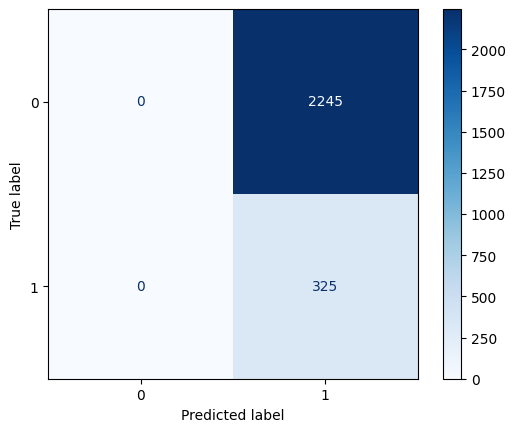

Accuracy: 0.1265
Precision: 0.1265
Recall: 1.0000
f1 score: 0.2245


In [132]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [133]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    random_state=1105
)

lr_model.fit(X_train_norm, y[train_mask])
y_pred = lr_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


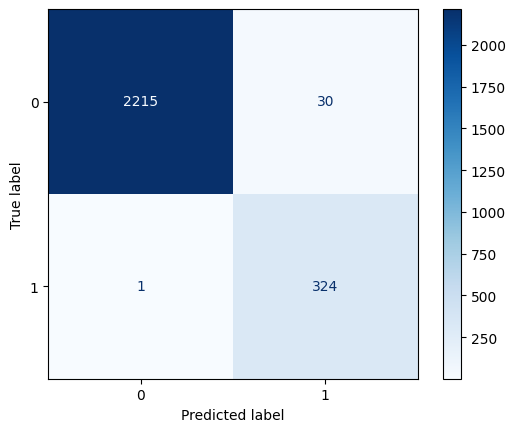

Accuracy: 0.9879
Precision: 0.9153
Recall: 0.9969
f1 score: 0.9543


In [134]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [135]:
from sklearn.svm import LinearSVC

class_weight = {
    0: 1.0,
    1: 5.0
}
svc_model = LinearSVC(
    class_weight=class_weight,
    random_state=1105
)

svc_model.fit(X_train_norm, y[train_mask])
y_pred = svc_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


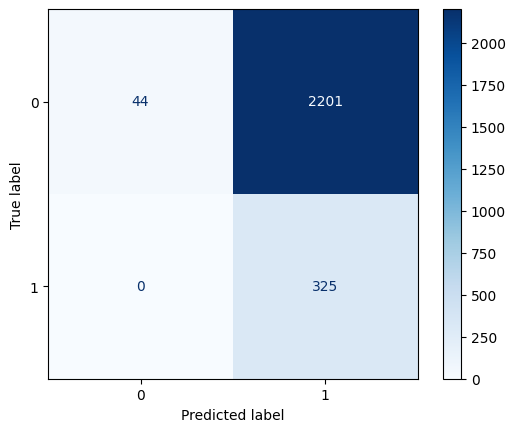

Accuracy: 0.1436
Precision: 0.1287
Recall: 1.0000
f1 score: 0.2280


In [136]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [137]:
def count_parameters(params):
    num = sum(p.numel() for p in params if p.requires_grad)
    print(f"{num:,}")
    return num

In [138]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels * 2)
        self.lin3 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.lin4 = Linear(hidden_channels * 4, hidden_channels * 8)
        self.lin5 = Linear(hidden_channels * 8, hidden_channels * 4)
        self.lin6 = Linear(hidden_channels * 4, hidden_channels * 2)
        self.lin7 = Linear(hidden_channels * 2, 1)
        self.norm1 = torch.nn.LayerNorm(hidden_channels)
        self.norm2 = torch.nn.LayerNorm(hidden_channels * 2)
        self.norm3 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm4 = torch.nn.LayerNorm(hidden_channels * 8)
        self.norm5 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm6 = torch.nn.LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin7(x)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x
    
model = MLP(hidden_channels=64)
print(f"MLP model number of params: {count_parameters(model.parameters()):,}")

342,401
MLP model number of params: 342,401


In [139]:
weight = torch.Tensor([1.0, 2.5])
criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    X_tmp = data.x[data.train_mask]
    y_tmp = data.y[data.train_mask]
    preds = model(X_tmp).squeeze()  # Perform a single forward pass.
    loss = criterion(preds, y_tmp)  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_X_tmp = data.x[data.val_mask]
        v_y_tmp = data.y[data.val_mask]
        v_preds = model(v_X_tmp).squeeze()
        v_loss = criterion(v_preds, v_y_tmp)
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.7374 / Val_loss: 0.4199
Epoch: 002, Train_loss: 0.5138 / Val_loss: 0.3888
Epoch: 003, Train_loss: 0.4263 / Val_loss: 0.3966
Epoch: 004, Train_loss: 0.3961 / Val_loss: 0.4070
Epoch: 005, Train_loss: 0.3917 / Val_loss: 0.4145
Epoch: 006, Train_loss: 0.3945 / Val_loss: 0.4187
Epoch: 007, Train_loss: 0.3985 / Val_loss: 0.4199
Epoch: 008, Train_loss: 0.3973 / Val_loss: 0.4187
Epoch: 009, Train_loss: 0.4006 / Val_loss: 0.4160
Epoch: 010, Train_loss: 0.4022 / Val_loss: 0.4119
Epoch: 011, Train_loss: 0.4001 / Val_loss: 0.4071
Epoch: 012, Train_loss: 0.3985 / Val_loss: 0.4020
Epoch: 013, Train_loss: 0.3972 / Val_loss: 0.3970
Epoch: 014, Train_loss: 0.3955 / Val_loss: 0.3924
Epoch: 015, Train_loss: 0.3899 / Val_loss: 0.3885
Epoch: 016, Train_loss: 0.3896 / Val_loss: 0.3853
Epoch: 017, Train_loss: 0.3907 / Val_loss: 0.3828
Epoch: 018, Train_loss: 0.3868 / Val_loss: 0.3810
Epoch: 019, Train_loss: 0.3882 / Val_loss: 0.3798
Epoch: 020, Train_loss: 0.3872 / Val_loss: 0.3791


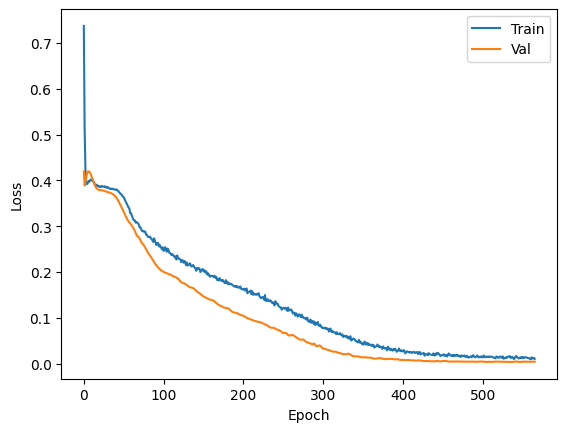

In [140]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

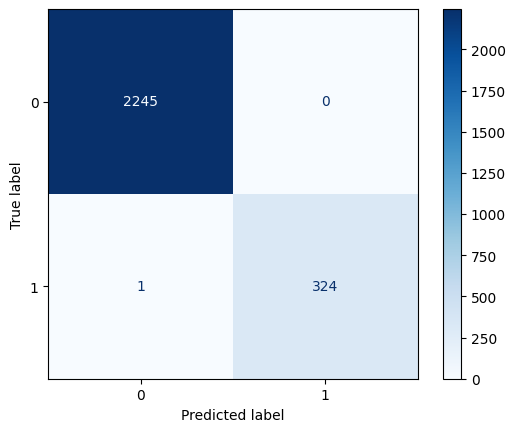

Accuracy: 0.9996
Precision: 1.0000
Recall: 0.9969
f1 score: 0.9985


In [141]:
model.eval()
X_tmp_test = data.x[data.test_mask]
y_tmp_test = data.y[data.test_mask]
with torch.no_grad():
    out = model(X_tmp_test)
# pred = out.argmax(dim=1)  # Use the class with highest probability.
pred = F.sigmoid(out).round()

cm = confusion_matrix(y_tmp_test, pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Precision: {precision_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Recall: {recall_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"f1 score: {f1_score(y_tmp_test.numpy(), pred.numpy()):.4f}")

In [142]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GCNConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GCNConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        x = x.squeeze()
        # x = self.log_softmax(x)
        return x

model = GCN(hidden_channels=64)
print(f"GCN model number of params: {count_parameters(model.parameters()):,}")

342,401
GCN model number of params: 342,401


In [143]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.6669 / Val_loss: 0.6627
Epoch: 002, Train_loss: 0.4735 / Val_loss: 0.4831
Epoch: 003, Train_loss: 0.4823 / Val_loss: 0.4958
Epoch: 004, Train_loss: 0.4837 / Val_loss: 0.4936
Epoch: 005, Train_loss: 0.4688 / Val_loss: 0.4788
Epoch: 006, Train_loss: 0.4437 / Val_loss: 0.4383
Epoch: 007, Train_loss: 0.4261 / Val_loss: 0.4271
Epoch: 008, Train_loss: 0.4074 / Val_loss: 0.4068
Epoch: 009, Train_loss: 0.4039 / Val_loss: 0.4012
Epoch: 010, Train_loss: 0.4048 / Val_loss: 0.4085
Epoch: 011, Train_loss: 0.4030 / Val_loss: 0.4021
Epoch: 012, Train_loss: 0.4022 / Val_loss: 0.4046
Epoch: 013, Train_loss: 0.3949 / Val_loss: 0.4042
Epoch: 014, Train_loss: 0.3954 / Val_loss: 0.3939
Epoch: 015, Train_loss: 0.3899 / Val_loss: 0.3898
Epoch: 016, Train_loss: 0.3846 / Val_loss: 0.3865
Epoch: 017, Train_loss: 0.3876 / Val_loss: 0.3809
Epoch: 018, Train_loss: 0.3842 / Val_loss: 0.3842
Epoch: 019, Train_loss: 0.3861 / Val_loss: 0.3882
Epoch: 020, Train_loss: 0.3837 / Val_loss: 0.3893


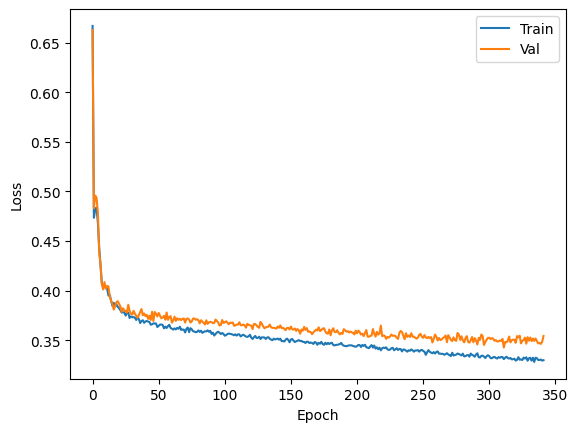

In [144]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [145]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = F.sigmoid(out).round()
# pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

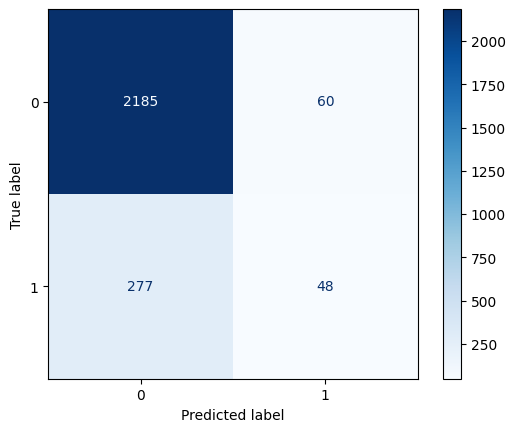

Accuracy: 0.8689
Precision: 0.4444
Recall: 0.1477
f1 score: 0.2217


In [146]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [147]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GATConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GATConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GATConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = self.log_softmax(x)
        x = x.squeeze()
        return x


model = GAT(hidden_channels=64)
print(f"GAT model number of params: {count_parameters(model.parameters()):,}")

345,091
GAT model number of params: 345,091


In [148]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight) # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.7613 / Val_loss: 0.7407
Epoch: 002, Train_loss: 0.6618 / Val_loss: 0.6763
Epoch: 003, Train_loss: 0.5760 / Val_loss: 0.5628
Epoch: 004, Train_loss: 0.5240 / Val_loss: 0.5167
Epoch: 005, Train_loss: 0.5120 / Val_loss: 0.5100
Epoch: 006, Train_loss: 0.4928 / Val_loss: 0.4901
Epoch: 007, Train_loss: 0.4686 / Val_loss: 0.4570
Epoch: 008, Train_loss: 0.4501 / Val_loss: 0.4432
Epoch: 009, Train_loss: 0.4539 / Val_loss: 0.4395
Epoch: 010, Train_loss: 0.4442 / Val_loss: 0.4328
Epoch: 011, Train_loss: 0.4393 / Val_loss: 0.4544
Epoch: 012, Train_loss: 0.4398 / Val_loss: 0.4345
Epoch: 013, Train_loss: 0.4474 / Val_loss: 0.4320
Epoch: 014, Train_loss: 0.4436 / Val_loss: 0.4539
Epoch: 015, Train_loss: 0.4126 / Val_loss: 0.4173
Epoch: 016, Train_loss: 0.4135 / Val_loss: 0.4155
Epoch: 017, Train_loss: 0.3972 / Val_loss: 0.3901
Epoch: 018, Train_loss: 0.4038 / Val_loss: 0.3900
Epoch: 019, Train_loss: 0.3870 / Val_loss: 0.3798
Epoch: 020, Train_loss: 0.3926 / Val_loss: 0.3828


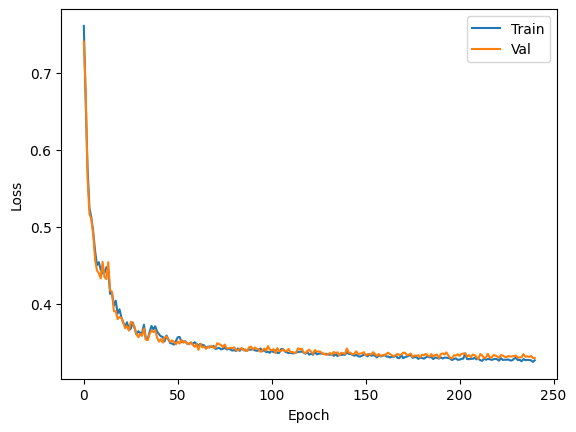

In [149]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

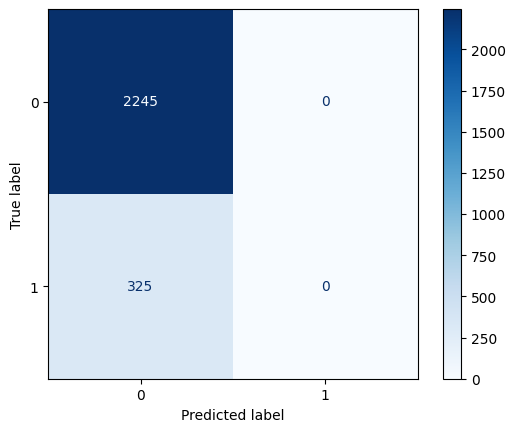

Accuracy: 0.8735
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [150]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = F.sigmoid(out).round()
# pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [151]:
sum(y) / len(y)

np.float64(0.12702213397185072)